# Reinforcement Learning based Virtual Screening
Protein-Ligan pose prediction using RL

## Spatial block arrangement using RL CNN-DQN
__Input__
- Sandbox with block and the surface placemnt

__Output__
- <x, y, $\theta$> for block wrt Sandbox

In [1]:
from block_world.env import Env
from agents.ddpg_agent import DDPGAgent
from matplotlib import pyplot as plt
import numpy as np

/Users/in-justin.jose/.miniconda/envs/rl-virtual-screening/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/in-justin.jose/.miniconda/envs/rl-virtual-screening/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/in-justin.jose/.miniconda/envs/rl-virtual-screening/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([

### Generating the sandbox
The block world generates a block and places it in the surface by randomizing <x, y, $\theta$>. The $\theta$ rotated block is stored in the _block_ property of the Block class.

Both the block and the surface are combined together into a single sandbox image. (More here)

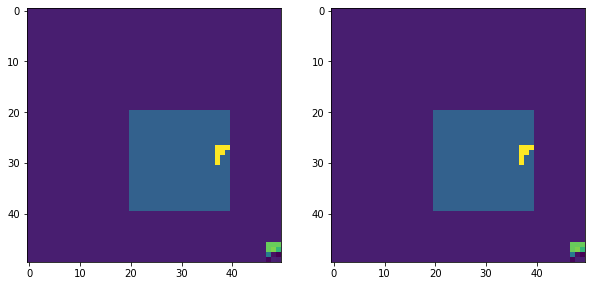

In [2]:
env = Env()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.imshow(env.block.sandbox)
ax2.imshow(env.block.original_sandbox)
plt.show()

In [3]:
print(env.block.rotate_angle, env.block.shift_x, env.block.shift_y)

40 27 37


In [4]:
surface_x = range(env.block.surface_index * env.block.surface_width, ( env.block.surface_index + 1 ) * env.block.surface_width)
surface_y = range(env.block.surface_index * env.block.surface_height, ( env.block.surface_index + 1 ) * env.block.surface_height)
print(round(29.62186666) in surface_x, surface_y)
print(list(surface_x), surface_y)
    

True range(20, 40)
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] range(20, 40)


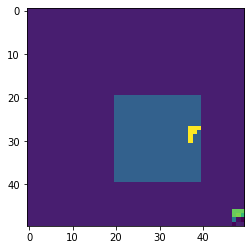

-0.1 [29.62186666, 32.59963543, 120.51585655] (2, 3)


In [5]:
xx = env.action_space.sample()
xx = [ 29.62186666, 32.59963543, 120.51585655]
state, reward, t = env.step(xx)
plt.imshow(env.block.sandbox)
plt.show()
print(reward, xx, env.action_space.action_bounds.shape)

### Converting sandbox image to tensors for CNN consumption
The sandbox image needs to be converted into an image consumable by the CNN

In [6]:
agent = DDPGAgent(env)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
actions =  agent.play(100)

Actiual states:  29 29 -179
True [-5.33664737  0.48524768  4.39780465] 2.21659351670775 1
True [-4.97089111 -0.80613238  4.50398293] 2.189228238937543 2
True [-4.46670915 -0.41828396  2.88666192] 2.2178801144062614 3
True [-4.73305806 -0.7697069   7.10911794] 2.186655984817304 4
True [-4.48774651 -0.90338439  5.25724335] 2.194283181198101 5
True [-4.58396955 -0.42322523  5.81650972] 2.1929680371731983 6
True [-4.45288922 -0.186686    7.128151  ] 2.199312595610527 7
True [-4.58842006 -0.0424472   8.5041964 ] 2.195198086556963 8
True [-4.72180568 -0.03762096  9.17016813] 2.1969745047035176 9
True [-4.99814918e+00  6.20410638e-03  8.38503462e+00] -0.1 10
True [-4.68127137  0.14611698  7.42076004] -0.1 11
True [-4.34643523 -0.24213902  4.79706221] 2.217822906137855 12
True [-4.50162097 -0.26291005  4.76728595] 2.217575877503889 13
True [-4.51809844 -0.16924153  3.31644138] 2.218100409072626 14
True [-4.74123987 -0.1213232   3.32586182] 2.2128605566944226 15
True [-5.08253951  0.16733549  2

True [-5.60149139 -0.44286835 16.27329293] -0.1 194
True [-5.97544343 -0.87865621 16.32591509] -0.1 195
True [-5.6574768  -0.9208243  15.85441966] -0.1 196
True [-6.05247024 -0.99796718 15.57991617] -0.1 197
True [-5.8389066  -1.14931781 15.7963284 ] -0.1 198
True [-5.89404115 -1.56206466 15.30256603] -0.1 199
True [-5.52655991 -1.12304604 16.86344217] -0.1 200
True [-5.62510926 -0.81244413 15.246273  ] -0.1 201
True [-5.75353727 -0.91087932 15.09751015] -0.1 202
True [-5.9578451  -0.33917625 13.45119769] -0.1 203
True [-6.12063061 -0.29914653 12.62628253] -0.1 204
True [-5.86847603 -0.26194313 12.91846067] -0.1 205
True [-5.76212909 -0.1258353   9.84623336] -0.1 206
True [-6.17908384 -0.22202018 10.53390352] -0.1 207
True [-5.89947443  0.17912418  9.94126246] -0.1 208
True [-5.81102286 -0.33300901 12.64858543] -0.1 209
True [-6.11968531 -0.3146546  13.97581112] -0.1 210
True [-6.23213479 -0.41552404 14.12130823] -0.1 211
True [-5.6582879  -0.63937837 12.3788794 ] -0.1 212
True [-5.535

True [-5.30017212  0.61603946  4.19635138] -0.1 367
True [-5.08135549  0.18247415  3.5129359 ] -0.1 368
True [-4.70932662 -0.18995281  3.05883369] -0.1 369
True [-4.99307524 -0.17148838  4.00282765] -0.1 370
True [-5.22110176 -0.72168651  4.10031705] -0.1 371
True [-5.45109664 -0.78600829  5.56890682] -0.1 372
True [-5.6241105  -0.6882171   7.57106207] -0.1 373
True [-5.75793426 -0.77659088  8.57960325] -0.1 374
True [-5.75424408 -0.55278311  7.87840793] -0.1 375
True [-6.29485437 -1.11753756  7.74527656] -0.1 376
True [-6.64286453 -1.65265623  7.49253579] -0.1 377
True [-6.37577708 -1.78718239  6.09555809] -0.1 378
True [-7.01933988 -1.95688071  5.18048206] -0.1 379
True [-7.47180811 -2.29934654  5.31479855] -0.1 380
True [-7.4785403  -2.18163227  4.52799268] -0.1 381
True [-7.50262437 -2.24577428  3.50542981] -0.1 382
True [-7.44518212 -2.59417053  1.43130129] -0.1 383
True [-7.20474038 -2.81632603  1.39077439] -0.1 384
True [-7.29155396 -2.78266431  0.39477972] -0.1 385
True [-7.609

32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 11/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 12/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 13/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9440 - acc: 0.0

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

Episode: 1 Return: -3.974198435875882 episode_length: 500
Actiual states:  30 29 179
True [ -27.89024233  -47.         -180.        ] 1.0479609444720928 1
True [ -27.97256689  -47.         -180.        ] 5.347653710271368 2
True [ -28.22566071  -47.         -180.        ] -0.1 3
True [ -27.80267684  -47.         -180.        ] -0.1 4
True [ -27.65883705  -47.         -180.        ] -0.1 5
True [ -27.47729397  -47.         -180.        ] -0.1 6
True [ -27.62153912  -47.         -180.        ] -0.1 7
True [ -27.76003276  -47.         -180.        ] -0.1 8
True [ -27.50771756  -47.         -180.        ] -0.1 9
True [ -28.0050353  -47.        -180.       ] -0.1 10
True [ -28.0596609  -47.        -180.       ] -0.1 11
True [ -28.31250654  -47.         -180.        ] -0.1 12
True [ -28.01692966  -47.         -180.        ] -0.1 13
True [ -28.05893664  -47.         -180.        ] -0.1 14
True [ -28.23931047  -47.         -180.        ] -0.1 15
True [ -28.74632525  -47.         -180.        ]

True [ -27.7471544  -47.        -180.       ] -0.1 158
True [ -27.7114532  -47.        -180.       ] -0.1 159
True [ -27.74263444  -47.         -180.        ] -0.1 160
True [ -27.73513162  -47.         -180.        ] -0.1 161
True [ -27.70607057  -47.         -180.        ] -0.1 162
True [ -27.55932879  -47.         -180.        ] -0.1 163
True [ -27.75659508  -47.         -180.        ] -0.1 164
True [ -27.56074065  -47.         -180.        ] -0.1 165
True [ -27.62057458  -47.         -180.        ] -0.1 166
True [ -27.61747909  -47.         -180.        ] -0.1 167
True [ -27.50998217  -47.         -180.        ] -0.1 168
True [ -28.04712068  -47.         -180.        ] -0.1 169
True [ -28.24544718  -47.         -180.        ] -0.1 170
True [ -28.22752723  -47.         -180.        ] -0.1 171
True [ -28.45873761  -47.         -180.        ] -0.1 172
True [ -28.26893392  -47.         -180.        ] -0.1 173
True [ -28.19965127  -47.         -180.        ] -0.1 174
True [ -28.20172011 

True [ -27.31344758  -47.         -180.        ] -0.1 313
True [ -27.06532358  -47.         -180.        ] -0.1 314
True [ -26.73700007  -47.         -180.        ] -0.1 315
True [ -27.30713778  -47.         -180.        ] -0.1 316
True [ -27.32251514  -47.         -180.        ] -0.1 317
True [ -27.2261981  -47.        -180.       ] -0.1 318
True [ -27.19025336  -47.         -180.        ] -0.1 319
True [ -27.47836438  -47.         -180.        ] -0.1 320
True [ -27.25758582  -47.         -180.        ] -0.1 321
True [ -27.05785183  -47.         -180.        ] -0.1 322
True [ -27.0200493  -47.        -180.       ] -0.1 323
True [ -27.05182885  -47.         -180.        ] -0.1 324
True [ -27.07912597  -47.         -180.        ] -0.1 325
True [ -26.98605128  -47.         -180.        ] -0.1 326
True [ -27.01651244  -47.         -180.        ] -0.1 327
True [ -26.73734867  -47.         -180.        ] -0.1 328
True [ -27.11414715  -47.         -180.        ] -0.1 329
True [ -27.5148681  

True [ -30.14803331  -47.         -180.        ] -0.1 471
True [ -30.67945058  -47.         -180.        ] -0.1 472
True [ -30.86473494  -47.         -180.        ] -0.1 473
True [ -30.86093514  -47.         -180.        ] -0.1 474
True [ -31.08521436  -47.         -180.        ] -0.1 475
True [ -30.63032088  -47.         -180.        ] -0.1 476
True [ -30.26368385  -47.         -180.        ] -0.1 477
True [ -30.14664444  -47.         -180.        ] -0.1 478
True [ -30.25203558  -47.         -180.        ] -0.1 479
True [ -30.35198471  -47.         -180.        ] -0.1 480
True [ -30.89237591  -47.         -180.        ] -0.1 481
True [ -30.91417618  -47.         -180.        ] -0.1 482
True [ -30.97990475  -47.         -180.        ] -0.1 483
True [ -31.03777059  -47.         -180.        ] -0.1 484
True [ -30.8660617  -47.        -180.       ] -0.1 485
True [ -30.96481579  -47.         -180.        ] -0.1 486
True [ -30.60940589  -47.         -180.        ] -0.1 487
True [ -30.640489

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

True [ -32.05365575  -47.         -180.        ] -0.1 30
True [ -32.17302805  -47.         -180.        ] -0.1 31
True [ -31.99109078  -47.         -180.        ] -0.1 32
True [ -32.30825522  -47.         -180.        ] -0.1 33
True [ -31.90916418  -47.         -180.        ] -0.1 34
True [ -31.80538466  -47.         -180.        ] -0.1 35
True [ -32.14417302  -47.         -180.        ] -0.1 36
True [ -32.47804655  -47.         -180.        ] -0.1 37
True [ -32.28671128  -47.         -180.        ] -0.1 38
True [ -32.32951024  -47.         -180.        ] -0.1 39
True [ -32.02283043  -47.         -180.        ] -0.1 40
True [ -31.94659653  -47.         -180.        ] -0.1 41
True [ -31.90907073  -47.         -180.        ] -0.1 42
True [ -31.85071748  -47.         -180.        ] -0.1 43
True [ -31.63140044  -47.         -180.        ] -0.1 44
True [ -31.21918477  -47.         -180.        ] -0.1 45
True [ -31.169945  -47.       -180.      ] -0.1 46
True [ -31.4430905  -47.        -180.

True [ -32.35925038  -47.         -180.        ] -0.1 176
True [ -32.49322606  -47.         -180.        ] -0.1 177
True [ -32.47839038  -47.         -180.        ] -0.1 178
True [ -32.41709514  -47.         -180.        ] -0.1 179
True [ -32.23146186  -47.         -180.        ] -0.1 180
True [ -32.40244045  -47.         -180.        ] -0.1 181
True [ -31.99685028  -47.         -180.        ] -0.1 182
True [ -32.27347223  -47.         -180.        ] -0.1 183
True [ -32.06084378  -47.         -180.        ] -0.1 184
True [ -32.00082078  -47.         -180.        ] -0.1 185
True [ -32.28966899  -47.         -180.        ] -0.1 186
True [ -31.97678397  -47.         -180.        ] -0.1 187
True [ -32.13727158  -47.         -180.        ] -0.1 188
True [ -32.47621089  -47.         -180.        ] -0.1 189
True [ -33.07753346  -47.         -180.        ] -0.1 190
True [ -33.26350417  -47.         -180.        ] -0.1 191
True [ -33.15571555  -47.         -180.        ] -0.1 192
True [ -33.177

True [ -32.58232708  -47.         -180.        ] -0.1 339
True [ -32.57381018  -47.         -180.        ] -0.1 340
True [ -32.48342393  -47.         -180.        ] -0.1 341
True [ -32.42729576  -47.         -180.        ] -0.1 342
True [ -32.59731789  -47.         -180.        ] -0.1 343
True [ -32.96890691  -47.         -180.        ] -0.1 344
True [ -33.10187799  -47.         -180.        ] -0.1 345
True [ -33.0901043  -47.        -180.       ] -0.1 346
True [ -32.76426989  -47.         -180.        ] -0.1 347
True [ -32.51507531  -47.         -180.        ] -0.1 348
True [ -32.586204  -47.       -180.      ] -0.1 349
True [ -32.48122213  -47.         -180.        ] -0.1 350
True [ -32.10180292  -47.         -180.        ] -0.1 351
True [ -31.82267987  -47.         -180.        ] -0.1 352
True [ -31.84132784  -47.         -180.        ] -0.1 353
True [ -31.82277963  -47.         -180.        ] -0.1 354
True [ -31.65409373  -47.         -180.        ] -0.1 355
True [ -31.87999736  -4

True [ -32.11560993  -47.         -180.        ] -0.1 485
True [ -31.97856195  -47.         -180.        ] -0.1 486
True [ -32.22198092  -47.         -180.        ] -0.1 487
True [ -31.90323463  -47.         -180.        ] -0.1 488
True [ -31.63310403  -47.         -180.        ] -0.1 489
True [ -31.84226333  -47.         -180.        ] -0.1 490
True [ -31.86577617  -47.         -180.        ] -0.1 491
True [ -32.09867089  -47.         -180.        ] -0.1 492
True [ -31.95497617  -47.         -180.        ] -0.1 493
True [ -31.23424149  -47.         -180.        ] -0.1 494
True [ -30.86904889  -47.         -180.        ] -0.1 495
True [ -30.76019209  -47.         -180.        ] -0.1 496
True [ -30.8161255  -47.        -180.       ] -0.1 497
True [ -31.0912597  -47.        -180.       ] -0.1 498
True [ -31.06466515  -47.         -180.        ] -0.1 499
True [ -31.32886052  -47.         -180.        ] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

True [ -28.06878913  -47.         -180.        ] -0.1 31
True [ -28.4931696  -47.        -180.       ] -0.1 32
True [ -28.63951995  -47.         -180.        ] -0.1 33
True [ -28.8363038  -47.        -180.       ] -0.1 34
True [ -29.09397383  -47.         -180.        ] -0.1 35
True [ -28.98949289  -47.         -180.        ] -0.1 36
True [ -29.22649749  -47.         -180.        ] -0.1 37
True [ -29.41529951  -47.         -180.        ] -0.1 38
True [ -29.40042642  -47.         -180.        ] -0.1 39
True [ -29.38332937  -47.         -180.        ] -0.1 40
True [ -29.381825  -47.       -180.      ] -0.1 41
True [ -29.32610528  -47.         -180.        ] -0.1 42
True [ -29.75177675  -47.         -180.        ] -0.1 43
True [ -29.75661934  -47.         -180.        ] -0.1 44
True [ -29.75588686  -47.         -180.        ] -0.1 45
True [ -29.71700772  -47.         -180.        ] -0.1 46
True [ -29.88709845  -47.         -180.        ] -0.1 47
True [ -29.76145402  -47.         -180.    

True [ -35.25738004  -47.         -180.        ] -0.1 183
True [ -35.30901103  -47.         -180.        ] -0.1 184
True [ -35.50189658  -47.         -180.        ] -0.1 185
True [ -35.3704279  -47.        -180.       ] -0.1 186
True [ -35.46578067  -47.         -180.        ] -0.1 187
True [ -35.76607882  -47.         -180.        ] -0.1 188
True [ -35.34217488  -47.         -180.        ] -0.1 189
True [ -35.20626581  -47.         -180.        ] -0.1 190
True [ -35.08622283  -47.         -180.        ] -0.1 191
True [ -35.1522916  -47.        -180.       ] -0.1 192
True [ -35.27622287  -47.         -180.        ] -0.1 193
True [ -35.20847721  -47.         -180.        ] -0.1 194
True [ -35.06777978  -47.         -180.        ] -0.1 195
True [ -35.13877656  -47.         -180.        ] -0.1 196
True [ -35.36830962  -47.         -180.        ] -0.1 197
True [ -35.69941884  -47.         -180.        ] -0.1 198
True [ -35.98633429  -47.         -180.        ] -0.1 199
True [ -35.82076162 

True [ -34.44015968  -47.         -180.        ] -0.1 339
True [ -34.59946413  -47.         -180.        ] -0.1 340
True [ -34.9565842  -47.        -180.       ] -0.1 341
True [ -35.00431722  -47.         -180.        ] -0.1 342
True [ -34.95674771  -47.         -180.        ] -0.1 343
True [ -35.30786824  -47.         -180.        ] -0.1 344
True [ -35.35859471  -47.         -180.        ] -0.1 345
True [ -35.34478615  -47.         -180.        ] -0.1 346
True [ -35.44011531  -47.         -180.        ] -0.1 347
True [ -35.36139869  -47.         -180.        ] -0.1 348
True [ -35.53664083  -47.         -180.        ] -0.1 349
True [ -35.40539566  -47.         -180.        ] -0.1 350
True [ -35.57948836  -47.         -180.        ] -0.1 351
True [ -35.35239685  -47.         -180.        ] -0.1 352
True [ -35.31103782  -47.         -180.        ] -0.1 353
True [ -35.16386667  -47.         -180.        ] -0.1 354
True [ -35.3081376  -47.        -180.       ] -0.1 355
True [ -35.23503471 

True [ -34.66945457  -47.         -180.        ] -0.1 487
True [ -34.50313147  -47.         -180.        ] -0.1 488
True [ -34.56810216  -47.         -180.        ] -0.1 489
True [ -34.13142534  -47.         -180.        ] -0.1 490
True [ -34.3484391  -47.        -180.       ] -0.1 491
True [ -34.88565616  -47.         -180.        ] -0.1 492
True [ -34.94318595  -47.         -180.        ] -0.1 493
True [ -35.47050288  -47.         -180.        ] -0.1 494
True [ -35.44415987  -47.         -180.        ] -0.1 495
True [ -35.62488192  -47.         -180.        ] -0.1 496
True [ -35.33043632  -47.         -180.        ] -0.1 497
True [ -35.21590314  -47.         -180.        ] -0.1 498
True [ -35.55369597  -47.         -180.        ] -0.1 499
True [ -35.56216132  -47.         -180.        ] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.9365 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.9365 - acc: 

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

True [ -29.65201385  -47.         -180.        ] -0.1 29
True [ -29.54336897  -47.         -180.        ] -0.1 30
True [ -29.36332853  -47.         -180.        ] -0.1 31
True [ -29.51870875  -47.         -180.        ] -0.1 32
True [ -29.6864796  -47.        -180.       ] -0.1 33
True [ -29.55240281  -47.         -180.        ] -0.1 34
True [ -29.91081865  -47.         -180.        ] -0.1 35
True [ -29.72939879  -47.         -180.        ] -0.1 36
True [ -29.86473156  -47.         -180.        ] -0.1 37
True [ -29.88945673  -47.         -180.        ] -0.1 38
True [ -29.66468473  -47.         -180.        ] -0.1 39
True [ -29.63113868  -47.         -180.        ] -0.1 40
True [ -28.9714541  -47.        -180.       ] -0.1 41
True [ -28.69671957  -47.         -180.        ] -0.1 42
True [ -29.0246457  -47.        -180.       ] -0.1 43
True [ -29.2393631  -47.        -180.       ] -0.1 44
True [ -30.02114503  -47.         -180.        ] -0.1 45
True [ -30.03671216  -47.         -180.    

True [ -27.0335922  -47.        -180.       ] -0.1 179
True [ -26.75057762  -47.         -180.        ] -0.1 180
True [ -26.6996646  -47.        -180.       ] -0.1 181
True [ -26.64235712  -47.         -180.        ] -0.1 182
True [ -26.31624266  -47.         -180.        ] -0.1 183
True [ -25.97633074  -47.         -180.        ] -0.1 184
True [ -25.92893766  -47.         -180.        ] -0.1 185
True [ -25.7665599  -47.        -180.       ] -0.1 186
True [ -25.70635376  -47.         -180.        ] -0.1 187
True [ -25.97668469  -47.         -180.        ] -0.1 188
True [ -26.14291841  -47.         -180.        ] -0.1 189
True [ -25.92533348  -47.         -180.        ] -0.1 190
True [ -26.2654679  -47.        -180.       ] -0.1 191
True [ -26.70838739  -47.         -180.        ] -0.1 192
True [ -26.40596976  -47.         -180.        ] -0.1 193
True [ -26.18939765  -47.         -180.        ] -0.1 194
True [ -26.15952377  -47.         -180.        ] -0.1 195
True [ -26.04864034  -47. 

True [ -25.78820815  -47.         -180.        ] -0.1 327
True [ -25.89212508  -47.         -180.        ] -0.1 328
True [ -26.31754694  -47.         -180.        ] -0.1 329
True [ -26.34875163  -47.         -180.        ] -0.1 330
True [ -26.38142581  -47.         -180.        ] -0.1 331
True [ -26.93190163  -47.         -180.        ] -0.1 332
True [ -27.37593576  -47.         -180.        ] -0.1 333
True [ -27.34120672  -47.         -180.        ] -0.1 334
True [ -27.04153588  -47.         -180.        ] -0.1 335
True [ -26.93445967  -47.         -180.        ] -0.1 336
True [ -27.38121683  -47.         -180.        ] -0.1 337
True [ -27.67031479  -47.         -180.        ] -0.1 338
True [ -27.950433  -47.       -180.      ] -0.1 339
True [ -27.93782002  -47.         -180.        ] -0.1 340
True [ -27.96485366  -47.         -180.        ] -0.1 341
True [ -28.18766298  -47.         -180.        ] -0.1 342
True [ -28.90468994  -47.         -180.        ] -0.1 343
True [ -28.61834671 

True [ -29.24731913  -47.         -180.        ] -0.1 489
True [ -29.33695932  -47.         -180.        ] -0.1 490
True [ -29.22243724  -47.         -180.        ] -0.1 491
True [ -28.92597683  -47.         -180.        ] -0.1 492
True [ -29.0919619  -47.        -180.       ] -0.1 493
True [ -29.18269665  -47.         -180.        ] -0.1 494
True [ -29.14762085  -47.         -180.        ] -0.1 495
True [ -29.1900407  -47.        -180.       ] -0.1 496
True [ -28.68245865  -47.         -180.        ] -0.1 497
True [ -29.02811095  -47.         -180.        ] -0.1 498
True [ -28.49263379  -47.         -180.        ] -0.1 499
True [ -28.29959891  -47.         -180.        ] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.9470 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.9470 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.9470 - acc: 0.0000e+00
Epoch 4

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

True [ -32.04265143  -47.         -180.        ] -0.1 31
True [ -32.40141841  -47.         -180.        ] -0.1 32
True [ -32.11932486  -47.         -180.        ] -0.1 33
True [ -32.07536024  -47.         -180.        ] -0.1 34
True [ -31.56826248  -47.         -180.        ] -0.1 35
True [ -31.41376183  -47.         -180.        ] -0.1 36
True [ -31.61669101  -47.         -180.        ] -0.1 37
True [ -31.69104494  -47.         -180.        ] -0.1 38
True [ -31.63437279  -47.         -180.        ] -0.1 39
True [ -31.88408284  -47.         -180.        ] -0.1 40
True [ -31.76507358  -47.         -180.        ] -0.1 41
True [ -31.92071718  -47.         -180.        ] -0.1 42
True [ -31.89805217  -47.         -180.        ] -0.1 43
True [ -31.93825322  -47.         -180.        ] -0.1 44
True [ -31.9334222  -47.        -180.       ] -0.1 45
True [ -32.04378939  -47.         -180.        ] -0.1 46
True [ -32.17839241  -47.         -180.        ] -0.1 47
True [ -32.43907783  -47.         

True [ -35.12122344  -47.         -180.        ] -0.1 183
True [ -34.8930409  -47.        -180.       ] -0.1 184
True [ -34.96631284  -47.         -180.        ] -0.1 185
True [ -34.89972481  -47.         -180.        ] -0.1 186
True [ -35.39656794  -47.         -180.        ] -0.1 187
True [ -35.49486049  -47.         -180.        ] -0.1 188
True [ -35.23799684  -47.         -180.        ] -0.1 189
True [ -34.93593563  -47.         -180.        ] -0.1 190
True [ -34.80364315  -47.         -180.        ] -0.1 191
True [ -34.99320514  -47.         -180.        ] -0.1 192
True [ -34.9183212  -47.        -180.       ] -0.1 193
True [ -35.18332966  -47.         -180.        ] -0.1 194
True [ -34.9760751  -47.        -180.       ] -0.1 195
True [ -34.75864399  -47.         -180.        ] -0.1 196
True [ -34.59374204  -47.         -180.        ] -0.1 197
True [ -34.53383336  -47.         -180.        ] -0.1 198
True [ -34.34701401  -47.         -180.        ] -0.1 199
True [ -34.37850174  -4

True [ -30.49790733  -47.         -180.        ] -0.1 331
True [ -30.74041249  -47.         -180.        ] -0.1 332
True [ -30.73773559  -47.         -180.        ] -0.1 333
True [ -30.64124058  -47.         -180.        ] -0.1 334
True [ -31.14991645  -47.         -180.        ] -0.1 335
True [ -31.13282549  -47.         -180.        ] -0.1 336
True [ -31.27018694  -47.         -180.        ] -0.1 337
True [ -31.31545611  -47.         -180.        ] -0.1 338
True [ -31.5629123  -47.        -180.       ] -0.1 339
True [ -31.45924747  -47.         -180.        ] -0.1 340
True [ -31.16737064  -47.         -180.        ] -0.1 341
True [ -30.7771635  -47.        -180.       ] -0.1 342
True [ -30.85852811  -47.         -180.        ] -0.1 343
True [ -30.37572221  -47.         -180.        ] -0.1 344
True [ -30.44556579  -47.         -180.        ] -0.1 345
True [ -30.33505354  -47.         -180.        ] -0.1 346
True [ -30.37419742  -47.         -180.        ] -0.1 347
True [ -30.01506262 

True [ -32.62905248  -47.         -180.        ] -0.1 489
True [ -32.8372819  -47.        -180.       ] -0.1 490
True [ -32.91026418  -47.         -180.        ] -0.1 491
True [ -33.1185622  -47.        -180.       ] -0.1 492
True [ -33.33254226  -47.         -180.        ] -0.1 493
True [ -33.13041414  -47.         -180.        ] -0.1 494
True [ -33.30523354  -47.         -180.        ] -0.1 495
True [ -33.29081646  -47.         -180.        ] -0.1 496
True [ -33.67443265  -47.         -180.        ] -0.1 497
True [ -33.43394058  -47.         -180.        ] -0.1 498
True [ -33.57684045  -47.         -180.        ] -0.1 499
True [ -33.23153891  -47.         -180.        ] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.8677 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.8677 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.8677 - acc: 0.0000e+00
Epoch 4

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

True [ -32.08090948  -47.         -180.        ] -0.1 29
True [ -32.25288814  -47.         -180.        ] -0.1 30
True [ -32.70168753  -47.         -180.        ] -0.1 31
True [ -32.47487518  -47.         -180.        ] -0.1 32
True [ -32.51824955  -47.         -180.        ] -0.1 33
True [ -32.88154367  -47.         -180.        ] -0.1 34
True [ -32.99770207  -47.         -180.        ] -0.1 35
True [ -33.40336495  -47.         -180.        ] -0.1 36
True [ -33.53358172  -47.         -180.        ] -0.1 37
True [ -33.84963675  -47.         -180.        ] -0.1 38
True [ -33.59900049  -47.         -180.        ] -0.1 39
True [ -33.93411836  -47.         -180.        ] -0.1 40
True [ -33.72036191  -47.         -180.        ] -0.1 41
True [ -33.85983651  -47.         -180.        ] -0.1 42
True [ -33.78676935  -47.         -180.        ] -0.1 43
True [ -34.26560917  -47.         -180.        ] -0.1 44
True [ -34.24036816  -47.         -180.        ] -0.1 45
True [ -33.73196486  -47.      

True [ -33.00808681  -47.         -180.        ] -0.1 175
True [ -32.84729705  -47.         -180.        ] -0.1 176
True [ -32.41390037  -47.         -180.        ] -0.1 177
True [ -32.25097499  -47.         -180.        ] -0.1 178
True [ -32.41930271  -47.         -180.        ] -0.1 179
True [ -32.32626337  -47.         -180.        ] -0.1 180
True [ -32.3768231  -47.        -180.       ] -0.1 181
True [ -32.12584685  -47.         -180.        ] -0.1 182
True [ -31.89973456  -47.         -180.        ] -0.1 183
True [ -31.63462487  -47.         -180.        ] -0.1 184
True [ -31.88523912  -47.         -180.        ] -0.1 185
True [ -31.45475517  -47.         -180.        ] -0.1 186
True [ -31.08661876  -47.         -180.        ] -0.1 187
True [ -31.18545839  -47.         -180.        ] -0.1 188
True [ -31.3035552  -47.        -180.       ] -0.1 189
True [ -31.52283512  -47.         -180.        ] -0.1 190
True [ -31.28824667  -47.         -180.        ] -0.1 191
True [ -31.21495371 

True [ -34.82493025  -47.         -180.        ] -0.1 323
True [ -35.03574813  -47.         -180.        ] -0.1 324
True [ -34.81171064  -47.         -180.        ] -0.1 325
True [ -34.91844205  -47.         -180.        ] -0.1 326
True [ -34.65865691  -47.         -180.        ] -0.1 327
True [ -35.04983632  -47.         -180.        ] -0.1 328
True [ -34.84818711  -47.         -180.        ] -0.1 329
True [ -34.44794469  -47.         -180.        ] -0.1 330
True [ -34.71407077  -47.         -180.        ] -0.1 331
True [ -34.52026994  -47.         -180.        ] -0.1 332
True [ -34.86010872  -47.         -180.        ] -0.1 333
True [ -34.94825866  -47.         -180.        ] -0.1 334
True [ -34.79270733  -47.         -180.        ] -0.1 335
True [ -34.60957394  -47.         -180.        ] -0.1 336
True [ -34.19245377  -47.         -180.        ] -0.1 337
True [ -34.38931291  -47.         -180.        ] -0.1 338
True [ -34.21591539  -47.         -180.        ] -0.1 339
True [ -34.143

True [ -35.38887561  -47.         -180.        ] -0.1 484
True [ -35.45184215  -47.         -180.        ] -0.1 485
True [ -35.85298616  -47.         -180.        ] -0.1 486
True [ -36.24034309  -47.         -180.        ] -0.1 487
True [ -36.47874158  -47.         -180.        ] -0.1 488
True [ -36.85352833  -47.         -180.        ] -0.1 489
True [ -36.81554389  -47.         -180.        ] -0.1 490
True [ -36.86661633  -47.         -180.        ] -0.1 491
True [ -36.88411404  -47.         -180.        ] -0.1 492
True [ -37.01334098  -47.         -180.        ] -0.1 493
True [ -36.88392511  -47.         -180.        ] -0.1 494
True [ -37.01265169  -47.         -180.        ] -0.1 495
True [ -37.18125037  -47.         -180.        ] -0.1 496
True [ -36.83024673  -47.         -180.        ] -0.1 497
True [ -37.59885192  -47.         -180.        ] -0.1 498
True [ -37.76358896  -47.         -180.        ] -0.1 499
True [ -37.45997489  -47.         -180.        ] -0.1 500
Epoch 1/20
32/

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

True [ -27.86945214  -47.         -180.        ] -0.1 32
True [ -27.74985954  -47.         -180.        ] -0.1 33
True [ -27.62531705  -47.         -180.        ] -0.1 34
True [ -27.55507328  -47.         -180.        ] -0.1 35
True [ -27.53690711  -47.         -180.        ] -0.1 36
True [ -27.22675802  -47.         -180.        ] -0.1 37
True [ -27.42741215  -47.         -180.        ] -0.1 38
True [ -27.5414936  -47.        -180.       ] -0.1 39
True [ -27.66275126  -47.         -180.        ] -0.1 40
True [ -27.58325829  -47.         -180.        ] -0.1 41
True [ -27.65525193  -47.         -180.        ] -0.1 42
True [ -27.71460308  -47.         -180.        ] -0.1 43
True [ -27.74346118  -47.         -180.        ] -0.1 44
True [ -27.88745403  -47.         -180.        ] -0.1 45
True [ -28.0951619  -47.        -180.       ] -0.1 46
True [ -27.49454566  -47.         -180.        ] -0.1 47
True [ -27.70998698  -47.         -180.        ] -0.1 48
True [ -27.57946512  -47.         -18

True [ -24.37322032  -47.         -180.        ] -0.1 183
True [ -24.22955123  -47.         -180.        ] -0.1 184
True [ -24.44634247  -47.         -180.        ] -0.1 185
True [ -24.20369369  -47.         -180.        ] -0.1 186
True [ -24.14292726  -47.         -180.        ] -0.1 187
True [ -24.05225027  -47.         -180.        ] -0.1 188
True [ -24.14251512  -47.         -180.        ] -0.1 189
True [ -24.45957362  -47.         -180.        ] -0.1 190
True [ -24.45272035  -47.         -180.        ] -0.1 191
True [ -24.12930963  -47.         -180.        ] -0.1 192
True [ -24.33775541  -47.         -180.        ] -0.1 193
True [ -24.55596458  -47.         -180.        ] -0.1 194
True [ -24.10675775  -47.         -180.        ] -0.1 195
True [ -24.56262382  -47.         -180.        ] -0.1 196
True [ -24.13416554  -47.         -180.        ] -0.1 197
True [ -23.97040139  -47.         -180.        ] -0.1 198
True [ -24.12650565  -47.         -180.        ] -0.1 199
True [ -24.022

True [ -23.34049971  -47.         -180.        ] -0.1 331
True [ -23.67080753  -47.         -180.        ] -0.1 332
True [ -23.54236546  -47.         -180.        ] -0.1 333
True [ -23.44746426  -47.         -180.        ] -0.1 334
True [ -23.91887235  -47.         -180.        ] -0.1 335
True [ -23.37401005  -47.         -180.        ] -0.1 336
True [ -23.20479835  -47.         -180.        ] -0.1 337
True [ -23.73976343  -47.         -180.        ] -0.1 338
True [ -23.83217266  -47.         -180.        ] -0.1 339
True [ -23.93526276  -47.         -180.        ] -0.1 340
True [ -23.87719828  -47.         -180.        ] -0.1 341
True [ -24.28963956  -47.         -180.        ] -0.1 342
True [ -24.14617962  -47.         -180.        ] -0.1 343
True [ -23.75664866  -47.         -180.        ] -0.1 344
True [ -24.2488692  -47.        -180.       ] -0.1 345
True [ -24.04845979  -47.         -180.        ] -0.1 346
True [ -23.64615367  -47.         -180.        ] -0.1 347
True [ -23.842971

True [ -24.91984864  -47.         -180.        ] -0.1 492
True [ -24.87919436  -47.         -180.        ] -0.1 493
True [ -25.4523199  -47.        -180.       ] -0.1 494
True [ -25.3879369  -47.        -180.       ] -0.1 495
True [ -25.03265308  -47.         -180.        ] -0.1 496
True [ -24.81794589  -47.         -180.        ] -0.1 497
True [ -24.70843359  -47.         -180.        ] -0.1 498
True [ -24.49640821  -47.         -180.        ] -0.1 499
True [ -24.3280276  -47.        -180.       ] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.9150 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.9150 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.9150 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.9150 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.9150 

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

True [ -28.58980771  -47.         -180.        ] -0.1 23
True [ -28.57834714  -47.         -180.        ] -0.1 24
True [ -28.53743735  -47.         -180.        ] -0.1 25
True [ -28.68201043  -47.         -180.        ] -0.1 26
True [ -28.8227193  -47.        -180.       ] -0.1 27
True [ -28.78027036  -47.         -180.        ] -0.1 28
True [ -28.94127649  -47.         -180.        ] -0.1 29
True [ -28.66353295  -47.         -180.        ] -0.1 30
True [ -28.54244211  -47.         -180.        ] -0.1 31
True [ -28.71056103  -47.         -180.        ] -0.1 32
True [ -28.73414735  -47.         -180.        ] -0.1 33
True [ -28.12308419  -47.         -180.        ] -0.1 34
True [ -28.45255043  -47.         -180.        ] -0.1 35
True [ -28.83860163  -47.         -180.        ] -0.1 36
True [ -28.42482552  -47.         -180.        ] -0.1 37
True [ -28.36379834  -47.         -180.        ] -0.1 38
True [ -28.35232248  -47.         -180.        ] -0.1 39
True [ -27.73753653  -47.         

True [ -29.83062654  -47.         -180.        ] -0.1 178
True [ -29.82899673  -47.         -180.        ] -0.1 179
True [ -30.18173168  -47.         -180.        ] -0.1 180
True [ -30.26473295  -47.         -180.        ] -0.1 181
True [ -30.58430923  -47.         -180.        ] -0.1 182
True [ -30.72605165  -47.         -180.        ] -0.1 183
True [ -30.83109682  -47.         -180.        ] -0.1 184
True [ -31.02396774  -47.         -180.        ] -0.1 185
True [ -30.57799319  -47.         -180.        ] -0.1 186
True [ -30.64069953  -47.         -180.        ] -0.1 187
True [ -30.49187085  -47.         -180.        ] -0.1 188
True [ -30.46897039  -47.         -180.        ] -0.1 189
True [ -31.02877575  -47.         -180.        ] -0.1 190
True [ -31.04924747  -47.         -180.        ] -0.1 191
True [ -31.10344274  -47.         -180.        ] -0.1 192
True [ -30.60682349  -47.         -180.        ] -0.1 193
True [ -31.25262065  -47.         -180.        ] -0.1 194
True [ -31.098

True [ -29.57776353  -47.         -180.        ] -0.1 329
True [ -29.26365866  -47.         -180.        ] -0.1 330
True [ -29.566375  -47.       -180.      ] -0.1 331
True [ -29.53026604  -47.         -180.        ] -0.1 332
True [ -29.65213078  -47.         -180.        ] -0.1 333
True [ -29.52788749  -47.         -180.        ] -0.1 334
True [ -29.25520635  -47.         -180.        ] -0.1 335
True [ -29.15494497  -47.         -180.        ] -0.1 336
True [ -29.48218903  -47.         -180.        ] -0.1 337
True [ -29.83814538  -47.         -180.        ] -0.1 338
True [ -29.53687152  -47.         -180.        ] -0.1 339
True [ -29.3025486  -47.        -180.       ] -0.1 340
True [ -29.66293573  -47.         -180.        ] -0.1 341
True [ -29.54845737  -47.         -180.        ] -0.1 342
True [ -28.81468596  -47.         -180.        ] -0.1 343
True [ -28.84284489  -47.         -180.        ] -0.1 344
True [ -28.67412092  -47.         -180.        ] -0.1 345
True [ -27.95936329  -4

True [ -28.54005118  -47.         -180.        ] -0.1 488
True [ -28.5187212  -47.        -180.       ] -0.1 489
True [ -28.27910125  -47.         -180.        ] -0.1 490
True [ -28.16737844  -47.         -180.        ] -0.1 491
True [ -28.67474918  -47.         -180.        ] -0.1 492
True [ -29.24823526  -47.         -180.        ] -0.1 493
True [ -28.96696594  -47.         -180.        ] -0.1 494
True [ -28.97381006  -47.         -180.        ] -0.1 495
True [ -28.39581927  -47.         -180.        ] -0.1 496
True [ -28.76413372  -47.         -180.        ] -0.1 497
True [ -27.98124401  -47.         -180.        ] -0.1 498
True [ -27.80466227  -47.         -180.        ] -0.1 499
True [ -28.33656491  -47.         -180.        ] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.8599 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.8599 - acc: 0.0000e+00
Epoch 3/20
32/32 [=============================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

True [ -28.59851767  -47.         -180.        ] -0.1 24
True [ -28.41081085  -47.         -180.        ] -0.1 25
True [ -28.57991761  -47.         -180.        ] -0.1 26
True [ -28.0733578  -47.        -180.       ] -0.1 27
True [ -28.62370721  -47.         -180.        ] -0.1 28
True [ -28.79967594  -47.         -180.        ] -0.1 29
True [ -28.27414314  -47.         -180.        ] -0.1 30
True [ -28.25762353  -47.         -180.        ] -0.1 31
True [ -28.40609826  -47.         -180.        ] -0.1 32
True [ -28.33265127  -47.         -180.        ] -0.1 33
True [ -28.05706863  -47.         -180.        ] -0.1 34
True [ -28.0882087  -47.        -180.       ] -0.1 35
True [ -28.46614123  -47.         -180.        ] -0.1 36
True [ -28.70928203  -47.         -180.        ] -0.1 37
True [ -29.06202644  -47.         -180.        ] -0.1 38
True [ -29.16205341  -47.         -180.        ] -0.1 39
True [ -29.47699955  -47.         -180.        ] -0.1 40
True [ -29.25753209  -47.         -18

True [ -25.36928699  -47.         -180.        ] -0.1 184
True [ -24.8562708  -47.        -180.       ] -0.1 185
True [ -24.79330799  -47.         -180.        ] -0.1 186
True [ -25.04103306  -47.         -180.        ] -0.1 187
True [ -25.22006523  -47.         -180.        ] -0.1 188
True [ -24.63242368  -47.         -180.        ] -0.1 189
True [ -24.83530734  -47.         -180.        ] -0.1 190
True [ -24.99573747  -47.         -180.        ] -0.1 191
True [ -24.39257397  -47.         -180.        ] -0.1 192
True [ -24.36595789  -47.         -180.        ] -0.1 193
True [ -24.22075373  -47.         -180.        ] -0.1 194
True [ -24.0973973  -47.        -180.       ] -0.1 195
True [ -24.20508717  -47.         -180.        ] -0.1 196
True [ -24.22606752  -47.         -180.        ] -0.1 197
True [ -25.03994645  -47.         -180.        ] -0.1 198
True [ -25.21424715  -47.         -180.        ] -0.1 199
True [ -25.21390472  -47.         -180.        ] -0.1 200
True [ -25.07696095 

True [ -24.39721654  -47.         -180.        ] -0.1 329
True [ -23.99419745  -47.         -180.        ] -0.1 330
True [ -24.22659458  -47.         -180.        ] -0.1 331
True [ -24.38490301  -47.         -180.        ] -0.1 332
True [ -24.59042467  -47.         -180.        ] -0.1 333
True [ -24.44358767  -47.         -180.        ] -0.1 334
True [ -24.26238838  -47.         -180.        ] -0.1 335
True [ -23.98531193  -47.         -180.        ] -0.1 336
True [ -24.29165484  -47.         -180.        ] -0.1 337
True [ -24.27445545  -47.         -180.        ] -0.1 338
True [ -24.51933481  -47.         -180.        ] -0.1 339
True [ -24.99604084  -47.         -180.        ] -0.1 340
True [ -24.94907153  -47.         -180.        ] -0.1 341
True [ -25.56558374  -47.         -180.        ] -0.1 342
True [ -25.52581586  -47.         -180.        ] -0.1 343
True [ -25.55053666  -47.         -180.        ] -0.1 344
True [ -25.6549714  -47.        -180.       ] -0.1 345
True [ -25.777909

True [ -31.41579247  -47.         -180.        ] -0.1 497
True [ -31.65148414  -47.         -180.        ] -0.1 498
True [ -31.36272003  -47.         -180.        ] -0.1 499
True [ -31.16441089  -47.         -180.        ] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.8770 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.8770 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.8770 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -1.8770 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.8770 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.8770 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -1.8770 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/s

False [ 17.9896634   17.08520415 -91.98583131] 1.5329271506847117 99
False [-23.11239236 -41.90541672  32.80859308] 3.4842860108422644 100
False [-18.60584805 -12.89786329 -80.66384648] -0.1 101


/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -0.81292914  44.90187937 103.98573459] 2.203262400097219 102
False [26.16335678 17.93811292 91.07819924] 1.730634788745485 103
False [-31.8384541   23.43837213 -97.21954133] -0.1 104
False [ -41.63746095  -39.80560754 -164.25411597] -0.1 105
False [-12.87319644  43.3386443  127.08431133] -0.1 106
False [-38.85943769  24.93108907  30.87754001] -0.1 107
False [44.0937599  16.574084    8.91508332] -0.1 108
False [  39.84559571  -20.84575535 -171.86379929] 1.2568972581101787 109
False [  3.68038792 -23.67084729  41.25270909] 3.6052502653744263 110
False [ -5.36437496 -41.62864909 -48.33044821] 16.298441071527144 111
False [-37.67768349  35.36315976 -31.88040389] 1.080481399380265 112
False [  18.67767203  -32.20968676 -135.39659433] 3.1709933144161266 113
False [-28.74517645 -35.21123516  90.67537483] -0.1 114
False [11.32378165 11.7464378  24.26116357] 1.8766663542953306 115
False [ -2.83631331 -29.32095473 -55.6326449 ] -0.1 116
False [  22.564812     -7.71286163 -164.07074765] 1

False [33.32339116  1.79359697 56.48632264] 6.7958348547699945 272
False [ 45.84311628  18.05935788 124.08227581] -0.1 273
False [  40.20616529   31.03739302 -165.21313452] -0.1 274
False [ -21.14982958    3.91451927 -126.53623551] 2.83655829044351 275
False [-13.71259008 -46.52098841 -59.79982917] 1.1368783968622276 276
False [ 16.97645873 -18.1482407   54.65918344] 1.4500541314767599 277
False [-28.89129912 -28.20839167 -84.16456807] -0.1 278
False [ 33.6843602  -18.90307866 -41.88143242] -0.1 279
False [28.11633421 -7.30902332 94.74183872] 6.494318547187967 280
False [14.95059806 -8.44816129 67.66882589] -0.1 281
False [-27.8994043   45.06776333  81.85415904] 4.641923948477953 282
False [ 43.83806044   0.646957   159.9347389 ] -0.1 283
False [-40.29913855   1.0309705  -94.37413756] 1.185171823818397 284
False [  30.02418524   32.88519009 -134.59308809] 103.00661174345676 285
False [   3.70051027  -21.93265092 -138.59946921] -0.1 286
False [-23.83294218  26.44370726  51.32976984] -0.

Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.6137 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.6137 - acc: 0.0000e+00

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  19.54666829  -10.3469302  -139.08779216] 2.149051404372766 97
False [-12.4428469   -3.80418739  58.94501459] 1.9417350031185525 98
False [ 23.14432501  18.15619924 -81.77701753] 8.971414818547224 99
False [-29.43393956  14.03496649 161.55403047] -0.1 100
False [  31.40525202    7.4212833  -178.10106674] -0.1 101
False [-26.29745652 -36.95582366  22.68164745] -0.1 102
False [ -40.5247692     1.43074701 -137.72051292] 1.3566631936872193 103
False [ -20.79567399  -38.45366326 -105.41331191] 1.3577387730830053 104
False [-15.43101762  28.94318476 169.39778562] -0.1 105
False [ 42.51027501 -45.0887135   52.19814157] -0.1 106
False [26.02932398 -5.65377739 31.14502605] 1.589719499893532 107
False [-20.3770145   21.83229937  -3.46499405] 1.5058584974346645 108
False [-43.98326041  33.87115031 167.44442221] -0.1 109
False [ 24.98727087 -41.81412969 -87.72190032] 3.2449711171253273 110
False [ 19.83817007 -34.37077332 -56.14163993] -0.1 111
False [-13.72708715  21.7260228  -85.13856834

False [  25.57888998   38.81104728 -120.16059428] -0.1 263
False [-13.20191057 -23.31430187 -84.35951662] 2.8682566089662607 264
False [-37.13477655 -17.61683023 -14.12253228] -0.1 265
False [ -31.77508501   11.77691938 -165.08954749] -0.1 266
False [33.57826194 13.29570003 47.0918561 ] 1.3377315981023006 267
False [  16.32158237  -45.4816629  -115.24283054] 1.1402015082849335 268
False [30.4388092  19.21871028  7.00353103] 2.5733204283292412 269
False [ -3.87427311 -15.50690892 -55.51164707] 4.103626674009276 270
False [  18.25498668   -4.71336713 -102.93391578] 2.0608381839532566 271
False [ -1.4524815    9.49093519 -25.61472542] 2.435765573116136 272
False [-28.97411866 -33.90438989 179.29025378] 1.4157016477664937 273
False [ 38.27519457  40.85738968 -31.81464196] -0.1 274
False [ 34.50547298 -45.95748463 176.20609651] -0.1 275
False [-38.30081501  14.59411856 -69.68941632] 1.3079166145636567 276
False [ 22.12415277  -9.62660896 134.34139747] -0.1 277
False [ 31.0376679   20.803086

Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: -0.9631 - acc: 

False [  21.07535273  -46.55940751 -145.40160645] 1.7492253387785774 95
False [ 2.72653330e+01  1.00205307e-01 -1.09535338e+02] 2.6811765677294446 96
False [ 24.87766131 -20.16988581 -55.15162277] -0.1 97
False [ 40.70569664 -38.73463807 131.00938152] -0.1 98
False [ 35.42201032 -37.89916274  -1.23670572] -0.1 99
False [ 6.34691234 43.38311696 31.55445088] -0.1 100
False [ 44.10308041 -25.07287928  58.74435995] -0.1 101
False [-42.04066797  28.47915608 -35.21882905] 1.808781211356223 102
False [-16.6593988  -30.09443696   8.6168033 ] 1.5841866279413963 103
False [ -7.64064581 -46.77719591 140.48381801] -0.1 104
False [  6.86998834  25.3253748  -10.29047204] 1.7144590152659345 105
False [-44.34174398 -33.60958742 160.4426007 ] -0.1 106
False [-23.1444654   -1.3457128  -42.34739908] 3.112471536325407 107
False [39.98923456 33.30719844 80.47710651] 2.3196564275603078 108
False [-12.55675574 -13.6536717   22.84523953] 2.7206988924227575 109
False [ 33.0672644  -17.10951608  54.28034914] 2.

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 14.81631655 -42.93898232  35.97698521] 4.268456402481519 128
False [-16.57694791   0.60954658   3.03072227] 3.0979593804698697 129
False [-12.40426444  -6.27065448 103.4669851 ] 3.4117265355893034 130
False [ -24.27315186   11.80517855 -108.80154744] 2.7502116409910595 131
False [ 18.56446039  43.02589694 120.32379934] -0.1 132
False [-28.87326133 -18.2116278  -32.33249922] 5.562138772494772 133
False [ 34.83487074 -16.27470622  40.7091041 ] -0.1 134
False [ 30.2060992  -34.37575523  78.94581957] -0.1 135
False [  -5.416238     -0.74470648 -106.56821814] -0.1 136
False [ 33.25986332 -35.36365381 171.71571999] -0.1 137
False [-13.43464168  31.57686702 -29.64974023] -0.1 138
False [ 12.67959409  -3.36639112 -28.79788101] 3.8524654654728914 139
False [  42.070785     21.02526952 -169.19268959] 2.7603734341706145 140
False [  11.39427479   26.03164327 -146.10171598] 5.333459658007486 141
False [ 34.45391176 -19.55683525 -11.56154873] -0.1 142
False [ -12.71198366   22.46948035 -102

False [   0.84384527  -20.52997257 -136.25819068] 1.999218227664949 268
False [ -13.95936258  -40.27729934 -153.89801225] -0.1 269
False [22.23967099 16.28345995 -2.62910763] -0.1 270
False [  21.46338895  -25.05739138 -131.37870361] 4.142155568445123 271
False [-44.32647364 -18.01968253 -49.57297992] -0.1 272
False [-10.60514558   8.06100214 -69.77721227] 3.7393873204077885 273
False [-7.33715678 16.35847539 79.46324558] 2.2433277532587574 274
False [  25.39947909   -2.91645917 -140.03448504] 3.5411705680067267 275
False [36.8262029  43.68859667  5.48637573] 1.1230554705813196 276
False [ 44.95391518  43.23155362 -76.96706079] -0.1 277
False [  4.19758114 -11.06405456 139.48573137] 3.5039420153940006 278
False [-14.96755167 -15.64757815 131.84784131] 1.7938271630720644 279
False [  38.32631911   45.12287837 -130.86270707] 1.0904232233480398 280
False [-24.11620171  -2.73560123  40.99505304] 5.215055066037384 281
False [ -21.89150224  -10.26874493 -141.82178748] -0.1 282
False [  6.660

False [-15.66619739 -41.25003793 142.53851363] -0.1 479
False [-44.49071984  18.16947727 -71.60785779] 1.3071538993066714 480
False [-40.74287856  46.45218233  34.4776581 ] -0.1 481
False [-29.44246884  -8.2078215  -85.24673845] -0.1 482
False [44.3542636  11.1228858  -6.41854248] -0.1 483
False [-13.99155838  26.80822958  97.12649673] -0.1 484
False [  35.03598434   24.16335037 -132.76194645] -0.1 485
False [ 19.20323626 -16.20067334  64.50722948] 4.4443018265391405 486
False [-42.85273885   3.03518582 123.4235886 ] -0.1 487
False [  -0.47181955   -6.02410167 -136.56756473] 2.7453349338210113 488
False [-9.26386167 32.68581314  7.65536896] -0.1 489
False [ 31.88919871  36.34871017 116.94152308] 101.83582504443115 490
False [35.67983289 45.05550287 50.63519211] -0.1 491
False [ 42.19149538 -11.99511929 -77.69435652] -0.1 492
False [ 14.65692593  20.21613015 149.84524421] 2.3353055438021855 493
False [-17.37155093 -34.88876395 107.36110975] 8.476274689158307 494
False [ -12.64478298  -4

False [ 31.8068667  -20.6609529  -58.27458746] -0.1 61
False 

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

[  13.90567677  -42.62630366 -163.60631092] 1.1662019658140763 62
False [  1.26725202 -40.14976771 107.16189366] -0.1 63
False [   3.28612854  -38.381676   -178.32765449] -0.1 64
False [ 22.11990151  16.69848434 -29.31406523] 2.39424972603915 65
False [-37.38772625 -21.31225373  75.07491808] 1.3090159610962295 66
False [ -11.07529727  -36.59974065 -121.49792942] -0.1 67
False [  24.55720178   27.65776941 -114.9849815 ] -0.1 68
False [-38.15966245  29.65324473 -21.28318352] 2.4054772029923033 69
False [ 38.60086137 -43.37046337 -97.53698571] 1.0696491202106913 70
False [-39.42481049 -14.54853763 -45.4789246 ] -0.1 71
False [ 24.05395238   5.07388252 -95.80738918] 1.4608708673126378 72
False [ -19.74211748   17.72450182 -125.00333165] 5.1257949541814485 73
False [-36.70738525  29.29428083  28.3953341 ] 1.097078808376648 74
False [ 17.60075967 -26.16067362 153.37439669] 2.159696359663673 75
False [ -11.90636345   19.5380225  -127.06985854] 4.00735312916321 76
False [-19.42650649 -25.98484

False [  21.57707881  -35.98685236 -162.82385303] 26.107151567034588 195
False [-21.88453875  24.88615811  48.42259151] -0.1 196
False [13.30502395  4.37639489 43.91223504] 2.933804040697322 197
False [   6.78463896   -1.36991928 -161.79059844] 2.3303805792495926 198
False [-32.74430088  20.33443811  11.46654953] -0.1 199
False [ 21.44288894 -36.60452524 177.57538156] -0.1 200
False [ 16.76801253 -23.32546815  29.13004738] 1.7107081354442946 201
False [  9.57620861  26.79245364 146.21444822] 1.4954186856170224 202
False [4.2387104  3.20578425 7.81843802] 2.500606294460611 203
False [  0.57425788 -46.3674453  136.20561701] -0.1 204
False [-41.70392614 -25.463503   -40.80733287] 1.1979078744716216 205
False [ 38.18737667  13.61213712 163.66522243] 1.2954161863112963 206
False [ -16.48423817  -24.38950043 -111.51180267] -0.1 207
False [ -25.08737383   26.78262888 -150.85913467] -0.1 208
False [ -38.66461247   46.06133798 -108.83955502] 1.0214104437356395 209
False [-40.74495878 -16.350197

False [ -42.22000101   29.37298774 -134.63930958] 8.145017697881782 333
False [-10.95013152  21.29487884  38.62327501] 1.4761080222915615 334
False [ -1.56521531 -19.65308151 -74.50648532] 1.5875240797210748 335
False [  18.98101584    7.83059072 -169.03845501] 1.5449839312332334 336
False [-26.3816899  -15.32182797 -70.85448679] 1.4409525703415182 337
False [  34.59612522  -43.29508234 -113.28132057] 6.571609440585114 338
False [  4.84160151  21.57634142 -70.56802961] 2.034018350998171 339
False [-44.82485627 -40.43509125 -60.02067685] 6.114784854281915 340
False [  19.58121081    9.36119382 -104.77286895] 1.5290514095744936 341
False [-39.48823387 -13.89490085 -72.12873083] -0.1 342
False [ 12.38050236  46.50896615 115.44638406] 1.1618444881270407 343
False [-36.00556705  35.57025625 -55.73638602] 1.1937713714241813 344
False [ -1.65151    -20.44930654 -97.56794117] 1.6590112882993415 345
False [-15.24403709  28.42061952 -33.83206267] -0.1 346
False [-16.28567514   4.68565609  88.471

False [-18.72576012 -32.65526632  36.52713176] 1.2193446884451615 458
False [  6.78844219 -15.8125311   -7.3705402 ] 3.6748021273662 459
False [ -2.96945936  -7.02966939 -41.98381591] -0.1 460
False [ 37.40144956  -9.94391104 105.18398146] -0.1 461
False [ 27.08704196 -23.39295998  77.32293071] -0.1 462
False [-43.1623718  -15.98916855 101.40975416] -0.1 463
False [ 1.07831557 25.62217386 73.24398414] 2.7990950387807736 464
False [ -5.43652007 -35.63189274  89.21253752] -0.1 465
False [ -38.62211277   37.77326398 -155.71729756] 1.0518610016607561 466
False [-37.7009697   33.0235085   39.51124976] -0.1 467
False [  15.40117122   -0.87687931 -114.49159872] 1.8744876255534049 468
False [ -4.68356135 -42.37798429   5.29241175] 4.382041791175002 469
False [-4.95317652 20.35334462 74.47348542] 2.9692932521234443 470
False [36.4342509   4.84384441 57.65732039] 1.9433702356697609 471
False [  19.71670543  -33.45968062 -164.466287  ] 7.957877220871967 472
False [  43.28497735   21.88970493 -126

False [ -44.8301211     7.06470285 -143.42569742] 5.2034158735685425 42
False [ 24.98866867 -28.75538026  72.10913935] 1.6744836720689535 43
False [ -32.83948212  -46.49669675 -166.17565991] -0.1 44
False [-5.356866   46.65669042 19.22348589] 1.086731782805004 45
False [31.75528696  5.46659816 -2.41495122] 1.7925886954774413 46
False [ 6.22775534 46.02475929 91.93717454] -0.1 47
False [ 31.98146343  23.15103007 108.72681636] -0.1 48
False [-37.58336265  -2.58855978  50.34375815] 8.46819356144794 49
False [ 40.28196548   4.59165942 171.40055153] 2.4439664185926175 50
False [ 3.04178256 21.11852291 29.8380126 ] 1.9175846811647679 51
False [ -33.89737795  -25.98740814 -133.90514301] 1.858366166066574 52
False [ 34.59038569 -18.42355378 -26.38912671] 2.3644473631770793 53
False [ -1.00033284  29.11138284 -44.43109648] 1.3133907148851198 54
False [ 21.6717112  -20.62413901 132.78196977] -0.1 55
False [-34.04330591   7.466203   155.65892262] 1.4923905746133321 56
False [14.29841415 38.883518

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 22.03800948 -11.61732103  62.75802536] 2.905477380557329 123
False [ -29.45985062   -6.20251189 -151.57240467] 5.397225421436379 124
False [  17.37849497   -2.12193298 -117.95167071] 1.7661947985769695 125
False [  1.46211186 -14.44572022  76.20140864] 2.1591629832936796 126
False [  7.83216691 -37.10845223 -99.48686149] 1.1824334131559169 127
False [-19.63505623 -11.93085701 -37.93499859] 2.512690813183674 128
False [-44.83094474  24.83486297 -40.18892856] 1.0327074004243542 129
False [ -37.41884805    2.70886346 -132.60407747] -0.1 130
False [ -28.69166016  -36.30159531 -147.69040125] -0.1 131
False [ 15.40518767  28.76794824 -24.10191514] 1.95473078766585 132
False [-41.95423415 -35.10193843  93.43520887] -0.1 133
False [ 14.74450679 -20.13276563 -29.38578567] 1.5065954325048725 134
False [ -33.11665143    5.88938765 -177.57920465] -0.1 135
False [ 12.57232612  26.82726424 -35.15231042] 1.347936995410808 136
False [ 18.0142821  -24.32736681 133.48622304] 3.6372900785448588 1

False [ 23.15483119  -9.56699905 -83.94671087] -0.1 252
False [ 37.06061444  17.81876575 -91.23454382] -0.1 253
False [44.01942363 25.18728057 80.89400726] 1.2695403151046873 254
False [ 40.20296259 -10.80266472 -82.84315631] -0.1 255
False [ 11.79921997  15.57137759 170.47010713] 1.5035393975353635 256
False [ 8.28131813 38.46445287 91.37748782] -0.1 257
False [-32.58724468  29.163984   -78.23100775] -0.1 258
False [-39.75597973   9.42279456  57.80008589] 2.454387786893444 259
False [ 35.46003153   6.45247179 -68.7666605 ] 1.4077110714913168 260
False [-10.91500628  24.34264384  25.04566792] -0.1 261
False [ 11.7904789  -15.39907097  43.85910452] 3.310992202286028 262
False [ 5.58567873 22.54680517 25.78647412] 1.6660402391381242 263
False [ 26.23703943 -42.81616393 -46.583154  ] -0.1 264
False [  25.69517053  -20.56760948 -136.05878905] -0.1 265
False [-10.18967944   9.79512205 143.04971812] -0.1 266
False [  24.96128871   25.6734143  -168.88953842] -0.1 267
False [  3.14693327  -5.3

False [ -30.13456198    4.24120078 -129.49722526] 6.028669558461387 388
False [22.91203906 15.11601293  6.06633741] 1.3437135569566019 389
False [-45.18583882 -19.4833747   48.66162448] 1.4095618358500117 390
False [  41.86456486   35.64476251 -118.81533895] 11.369634443041784 391
False [ -9.37901476  20.53880614 139.43845692] 2.194455426426149 392
False [-10.46478627  17.98142707  -4.29915083] 1.5338970682992372 393
False [   4.97653059  -16.73676465 -163.63090081] -0.1 394
False [ 40.58005031 -42.69825434  -0.75536555] 0.9565701571507157 395
False [-8.86522264 11.58853785 61.95124496] 2.1385464316811404 396
False [ -25.77225455  -22.76252126 -142.95401273] -0.1 397
False [  -6.89326021  -38.53753647 -177.91038651] 11.308516070876452 398
False [ 27.9756628  -25.33394281 125.78400443] -0.1 399
False [  39.15034947   44.52015558 -103.08798198] -0.1 400
False [ -29.94012192  -34.26786169 -125.50691132] -0.1 401
False [  38.36930455  -25.40142204 -178.3411769 ] -0.1 402
False [ -8.4247073

32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 12/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 13/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: 55.6112 - acc: 0.0

False [-12.68429086  42.97654309  63.88696899] -0.1 88
False [-14.56125431 -24.79438966 110.43793078] -0.1 89
False [-44.27162976  -5.12235385 104.42915244] -0.1 90
False [-44.41109671  -9.18754915  11.0969717 ] -0.1 91
False [   6.42164459  -15.26028645 -117.91054161] 1.6093479322674173 92
False [  11.73338767  -44.7108059  -150.74128596] -0.1 93
False [ -24.30219804   38.56576788 -130.40091705] -0.1 94
False [ -13.25254032   20.29002617 -120.99858599] 3.142730717297469 95
False [-45.62709639 -11.57472021 112.15723792] -0.1 96
False [ -12.98969485  -11.49849998 -150.53573482] -0.1 97
False [ 31.16842453  26.95696217 174.83495172] 101.35657033985451 98
False [ 14.12141684 -37.17055576 148.34195101] -0.1 99
False [  7.72994104 -16.9675307   78.02479536] 1.6956978321636522 100
False [ -3.31660916  32.29824845 108.7862857 ] -0.1 101
False [ 40.01211559 -13.35991876 105.73477817] 2.3069192616039067 102
False [45.84799955 10.79212403 60.68103018] -0.1 103
False [ -32.55681092  -43.39953476 

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-33.66664277  -4.39196862  59.11426333] 5.718033455290096 122
False [  33.61171768   26.16088408 -170.10192055] 104.92309560777676 123
False [-31.4723925   23.96811964  86.37891134] -0.1 124
False [-10.71600559 -43.76294149 100.25460377] 5.337372427561779 125
False [-1.77225712 36.78687861 34.15801297] 1.1955703764424601 126
False [-37.50479049 -46.01536595 136.12408197] 0.9609424069074839 127
False [-28.98529413   9.27626706 -18.34023451] -0.1 128
False [ -4.17457518 -15.07616812 161.15345097] 2.508104137872027 129
False [ 6.35226866 14.76839383 87.98199217] 2.4004922996936267 130
False [-3.8660749  41.37745621 77.22789445] 5.2308803041867264 131
False [-37.31100495  41.30009459 -46.61432202] -0.1 132
False [ -41.21111701   12.95284734 -171.06185992] -0.1 133
False [  0.43479181  44.83541596 -77.75950732] -0.1 134
False [-39.39510327  46.01162918 152.42122574] -0.1 135
False [-40.37779191  23.85118228 -76.22482249] -0.1 136
False [ -12.12248472   24.83548496 -154.02810901] 3.80

False [  42.2461168    -5.85408231 -100.02816001] -0.1 266
False [  37.01067945  -43.97975516 -129.6866763 ] -0.1 267
False [ -41.81432493   -8.05276125 -103.36093712] 1.213175039155997 268
False [   6.50769508   13.61741498 -143.56499759] 3.1287489145142864 269
False [15.45354723  3.15033669 12.06274062] 1.7781526947859265 270
False [-12.37405189 -46.06583766  32.89637796] 1.1931558622217993 271
False [ 38.87099535  35.39069985 168.67004996] -0.1 272
False [-9.09297535 16.01392632 86.51878043] 1.7131014046084316 273
False [  7.44715089 -13.28398376 -83.33827648] -0.1 274
False [   7.91101234  -38.51152157 -174.33861011] 1.207403385314811 275
False [ 39.25834519 -12.90791882   7.75453261] -0.1 276
False [ -18.23491194  -29.60551084 -143.1027997 ] -0.1 277
False [-12.0637521   10.20839543  49.62342368] 1.9287265680109351 278
False [ 30.66873899  12.31305288 159.44211847] 2.1079354806394206 279
False [  32.3818671   -38.2861515  -116.06520608] -0.1 280
False [  1.72003264  44.52595676 10

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1346 - acc: 

False [-36.25856114   1.99268917  88.21503183] 1.660078157823163 87
False [ -7.08391622 -28.8743963   39.19011874] -0.1 88
False [  36.75091572   -4.05558587 -140.0173928 ] 1.8103287831109085 89
False [ 45.47875261 -35.31883431 148.84380044] -0.1 90
False [ -2.3682664   23.52241841 111.8430251 ] 4.820077905765464 91
False [-19.9574923  -10.73501651 142.9037882 ] 2.644658764477197 92
False [-14.48326445 -32.37658536 128.07708343] 1.7914225887831077 93
False [  -5.16074968  -20.20147492 -108.3326159 ] -0.1 94
False [ 13.90295244  42.60430298 -56.46575547] 1.191113132075594 95
False [ 11.37230265 -17.28842289  -2.79919573] 1.6657618310305413 96
False [-25.314911   -46.61406604  66.06808054] -0.1 97
False [  38.5118276     2.67196064 -174.21809236] 1.2722629724391061 98
False [  23.30716966  -28.17468369 -167.8185519 ] 14.120291834900295 99
False [-0.98758147 13.04653339 65.45406716] 2.1148952185854863 100
False [-11.53481589 -43.49135529 151.10406956] -0.1 101
False [-16.82346574  23.2212

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-27.54411048  29.39060008  26.85776535] 1.2065857258477877 125
False [ -20.98167492  -21.91995021 -172.78128295] 1.9652362588126624 126
False [ 2.14835377 -9.11478089 71.62971329] 2.1349722523773744 127
False [  4.97879741  45.79957699 161.91724996] -0.1 128
False [-30.79873727  35.84310075 -73.26498229] -0.1 129
False [  29.54648061  -42.76535688 -115.64670816] 1.0521428133293436 130
False [  -5.46370126  -31.39552283 -171.8798845 ] -0.1 131
False [ 18.93870678  18.92278917 -14.48791463] 5.530297731395723 132
False [ 39.1311509   15.64940152 153.32100762] -0.1 133
False [26.31667067 39.96147035 20.37173707] 1.711085805458977 134
False [ 27.89372218 -31.71394541 134.40059939] -0.1 135
False [ -23.19289898   43.45639387 -104.62535622] -0.1 136
False [-11.70763678 -40.28508348 166.69565413] 2.7841113851193606 137
False [ 41.63713907 -23.53103214 -13.80214638] -0.1 138
False [10.2383852  -2.63416379  4.63026072] 1.8713783734757394 139
False [  35.90999105   19.2974286  -175.4424483

False [  2.50146457   7.02598337 135.56861599] 1.9746268863145826 268
False [-35.12081482  18.819499   156.51440755] -0.1 269
False [-38.51864709  22.75609465 -33.77450411] -0.1 270
False [  43.23873347   -5.79510462 -101.91331693] 1.3204513391327546 271
False [ -12.41238329   -0.47514519 -153.213044  ] 2.4186112879591515 272
False [ -44.10568224  -19.10037681 -153.1150238 ] 1.1224469784967896 273
False [-30.34837567 -28.35625657 -31.13568331] -0.1 274
False [-44.28593571  39.34446941 132.13803395] -0.1 275
False [14.88752043 30.54150473 39.66205737] 2.2813707884189705 276
False [-25.16343046 -40.38992917 -73.17992179] -0.1 277
False [ 34.27043155  -7.00909963 -53.93941531] 1.3098282902344869 278
False [-21.67034918  -7.49168502 -71.02245362] 1.5694464853158967 279
False [ 43.66438817  27.17586174 132.29619321] 1.139679535187374 280
False [-31.46298388   8.04711148  54.17769766] -0.1 281
False [-43.69147242  28.95424577  91.1221711 ] -0.1 282
False [   4.23623129   -1.19882701 -129.387

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 3.8031 - acc: 0.0000e+00

False [ -1.53249171  28.98624963 117.62464317] 1.9710862502577846 86
False [  8.60205149   4.30890254 -73.43578773] 2.7256816853835204 87
False [-44.25759623 -15.77911745 161.06851749] -0.1 88
False [22.11223083  0.0976424  64.56692372] 2.6455500479773346 89
False [ -35.1513573    14.166181   -163.83835728] 1.502114333837405 90
False [   8.70105834  -24.8994953  -137.3317375 ] 3.1204294091243674 91
False [ 7.15878126 39.43071566  4.76572748] 15.420652832844079 92
False [-39.56837478 -34.48029545  21.41098121] -0.1 93
False [ 24.63039691  40.76782403 112.76319081] 1.250366431518912 94
False [  37.59355447  -42.01054358 -105.57456493] -0.1 95
False [-19.36591381  43.7360993  -52.65375335] 1.2942942259061847 96
False [-32.74664227  30.58814678  77.43407824] 1.8158169074207058 97
False [ -2.24837144 -14.14506847  79.03179345] 3.222041922668056 98
False [-19.52395448  19.8718921  101.96859479] -0.1 99
False [ 44.35327603 -20.11230615 122.11368645] 6.250005891697273 100
False [-41.78659957 -

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -10.9101355   -41.71203629 -160.63390564] 3.432066913919365 125
False [-24.44581883 -26.86203095 167.55445846] 2.6325730741530795 126
False [-40.27561253 -31.12776506 -48.64535725] 1.2210452309384778 127
False [ -35.47362139   43.48221011 -115.30949775] -0.1 128
False [  -1.67966543    4.19000806 -101.44923036] 2.8289937601128927 129
False [-45.79334173   0.07431001  31.88011784] -0.1 130
False [ 20.40459866 -35.72257599  -6.48865158] 8.883664269596473 131
False [  4.12128    -22.53954953  13.79534171] 9.325985659601887 132
False [ 36.72405013 -43.46522512  63.83896354] 1.1532615203519858 133
False [   2.83468834   -6.23317194 -130.84574444] 2.4854773696116776 134
False [ 33.28270991  18.63820331 134.12723395] -0.1 135
False [-30.61589112  38.83587277  72.67500314] -0.1 136
False [ -37.48555068   32.12336588 -171.27812397] 4.465398858536764 137
False [-13.08376303  18.87321244 104.05915465] 7.313516726328026 138
False [-25.34350797   9.08583344  19.10213734] 3.9354144307246943 

False [  18.29627627   38.30987773 -126.90766306] -0.1 264
False [  12.50186552  -27.01442539 -117.45126718] -0.1 265
False [-25.16361976  35.63700774 145.96078849] 1.2990583628759382 266
False [  0.65725471 -35.13749463 132.51895441] 1.8415516628226853 267
False [-12.13528321   2.81143849 127.94068195] -0.1 268
False [ -5.47863455 -26.33889281 119.00262431] 1.6613029033090538 269
False [ -16.75345461   32.68092747 -165.0005758 ] 2.7621194826059225 270
False [40.66821948 34.32849616 54.97920535] 2.692119163247785 271
False [  22.87235371   44.59486553 -179.61309117] -0.1 272
False [33.33007693 -5.54031936  6.29961324] -0.1 273
False [  19.39520958    0.27651639 -148.88935882] -0.1 274
False [ 32.27425422  43.63359626 -26.86311401] -0.1 275
False [ 28.16175391  39.2097187  149.8039315 ] -0.1 276
False [ 11.4192417  -27.41635072  76.44482257] 3.487468985580125 277
False [-17.01069762   3.58623845 -24.14076928] 2.202148541738866 278
False [-43.89353583 -25.39746355 -55.96602075] 1.1918004

False [ 17.30099263  -4.8302985  -18.95962894] -0.1 405
False [ -14.35415781  -43.04147227 -123.53839653] 3.76413376429653 406
False [-29.68554223  34.57000103  52.43822711] 2.104028971418727 407
False [-42.00565611 -26.85538438 -39.30565941] -0.1 408
False [  -6.23878538   -6.64333242 -156.80817789] 2.3604276550270384 409
False [ 26.66755241 -42.805307    51.286606  ] 2.8744822192230854 410
False [-9.81015365 45.71388057 20.00111604] 2.009895146864094 411
False [ 38.38801033 -20.49603607 119.44541332] 1.3065423828310954 412
False [ 24.79634717 -30.99585726 163.74028575] -0.1 413
False [ 11.29967454 -36.63848617 138.49663586] -0.1 414
False [44.24466039 -2.51822044 91.61635728] -0.1 415
False [ 19.38287145  29.52669417 114.30802924] -0.1 416
False [  40.82871781   46.99467718 -133.75217267] -0.1 417
False [-15.99549948 -15.97731993 -99.8742221 ] 3.7696289170736414 418
False [-19.98160588  25.12347753 -55.64925667] 1.5458759164935463 419
False [-18.57203495  29.88186778  83.59540434] 3.

32/32 [==============================] - 1s 19ms/sample - loss: 61.0685 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: 61.0685 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 194ms/step - loss: 2.6114 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 27ms/step - loss: 2.4879 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 29ms/step - loss: 2.5277 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6781 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 28ms/step - loss: 2.4960 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 29ms/step - loss: 2.5775 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 28ms/step - loss: 2.4510 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 29ms/step - loss: 2.6781 - acc: 0.0000e+00
Epoch 9/20
1/1 [=======================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 26.82982202 -44.95152409  39.80404721] 2.4204331258443497 127
False [  -4.81663342  -39.39615761 -136.11459369] -0.1 128
False [ -19.28631      46.59556869 -124.36103253] 1.3637571026706738 129
False [-15.81040591 -43.5461586    1.27058515] 5.8188057832093225 130
False [ 32.09906274 -40.96130338  41.77041491] -0.1 131
False [-37.13908372 -24.78952246  49.73531959] -0.1 132
False [ -37.5864932   -41.51120588 -112.90777524] -0.1 133
False [-20.13052342  28.22127725 -41.98949926] 1.4198381075688802 134
False [-2.40684718  1.53913491  5.09966652] -0.1 135
False [  5.75577941 -10.93014824 -48.10777979] 2.409249856479186 136
False [-30.2419115  -21.42954528 123.40119163] 1.4548135315895088 137
False [-32.39717642 -34.67496433 -85.05930391] -0.1 138
False [ -5.28804883 -28.69014858 131.06785438] -0.1 139
False [-35.43544001  -9.76759239  96.86452879] 1.3792151285059027 140
False [-24.34309197 -27.67772195  78.17509922] -0.1 141
False [ 2.96886004 -3.76734227 60.21984784] -0.1 142
Fals

False [12.91786288 10.3732954  29.46268261] 1.948118981493213 262
False [-0.28545589 -5.35536223 58.74971449] 3.2313817622720995 263
False [-35.30627454  41.10254885  92.4435094 ] -0.1 264
False [ 25.39266662 -19.23513549 113.11107563] 6.103864201805769 265
False [ 30.9138723  -14.76999789  81.26889841] 2.0455215910420095 266
False [-14.51613648   1.37768244 126.07273089] 2.7244133228842218 267
False [ 11.80238854  28.98299482 -26.46736849] 1.4873185596274918 268
False [24.84969    41.46142913 35.31953642] -0.1 269
False [ 20.5858927  -37.01917218 179.50333473] 2.2085331678757067 270
False [-31.73779241   7.06750455 -86.53780754] 1.6376120279598316 271
False [36.45465766 23.29164484 64.08610439] 105.27681664827543 272
False [-44.72997415  29.48632729 -89.82389563] 1.7590902978346354 273
False [ 13.20525146 -11.79383489 -53.15560546] 3.5107657548305355 274
False [  6.52275812 -11.177033    62.40059132] 2.1003606452372154 275
False [30.42432577 -4.9506698  28.463196  ] 1.8950213423139495

False [-28.48718458  31.22988886 -58.54151664] 1.8656270011204168 400
False [ 33.95791254 -14.9053029  -51.55755474] 2.532335908830646 401
False [ -2.42959822 -45.18598234 -76.20448019] 1.9964237660268198 402
False [35.74461623 -8.85859095 19.26948117] 1.9573298619028652 403
False [ 15.77816994 -11.08161844  61.0125649 ] 1.8126613713201707 404
False [-41.28842667  31.05238048  47.04282024] 1.160303573957937 405
False [ -22.66569154   28.86914555 -140.74735993] 1.455141144429022 406
False [  11.38320839   35.90591443 -123.6428695 ] -0.1 407
False [  43.45449291   16.4528835  -101.49311284] 1.32807370545221 408
False [ -21.49355597    1.55554858 -151.41803723] 6.869771568023561 409
False [ 24.24855092  43.9955358  153.35239911] -0.1 410
False [-1.81312246 25.03284325 94.55404944] -0.1 411
False [13.73535604  6.0686915  21.72181916] 2.0912116036176474 412
False [-5.22034149 31.7339829  64.28348944] -0.1 413
False [ 22.85831598 -46.35136486 -94.8866869 ] 1.8480966169060231 414
False [ -29.

32/32 [==============================] - 1s 19ms/sample - loss: 12.1014 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1014 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1014 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1014 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.1014 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 195ms/step - loss: 2.5876 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5240 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6059 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 29ms/step - loss: 2.6672 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 28ms/step - loss: 2.6084 - acc: 0.0000e+00
Epoch 6/20
1/1 [=====

False [22.53117684 34.31057135 77.6079373 ] 101.33802203529508 93
False [ 23.30646072 -14.70941938 103.15818294] 1.851675531644693 94
False [11.50147995 40.63526217 92.11609376] 2.275222710662385 95
False [ 11.78471623  43.24959681 -47.31759063] -0.1 96
False [ 4.94609326 45.38151161 90.50505183] -0.1 97
False [-45.18769618  41.63270697 114.04565535] -0.1 98
False [13.16924478 24.735071   -8.63819991] -0.1 99
False [ -27.3627226   -26.47095218 -161.89887955] 8.715262005235545 100
False [-44.01845729  -3.63933892 101.46961162] 2.807864312226133 101
False [ -37.10983729   44.61170211 -126.13366439] -0.1 102
False [ -23.0921466    10.39521597 -175.43175357] 1.6605602161526574 103
False [-43.66219746 -31.38179834 -90.98679156] -0.1 104
False [  4.65829887  18.1014381  121.23744433] 5.647790401955914 105
False [-31.03568107  38.72835589 -49.83617389] -0.1 106
False [ 2.7687995  35.06316191 11.43274043] 1.8090949696997296 107
False [  9.80833113  -9.92588462 125.20352106] 4.737574414912312 1

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -8.75411177 -37.29473709  11.81800945] 1.5837452774129115 129
False [27.72855019 35.25227816 -9.27072357] 101.25391831562203 130
False [ 7.38196555 10.6332214  20.99076921] -0.1 131
False [-20.37428029  -7.70807554 -19.43649351] 1.970059262538338 132
False [  25.55940805   -2.26979995 -122.11241849] 1.8487315002292566 133
False [-11.42660011  14.7960624  -20.68065016] -0.1 134
False [-1.07085953 14.78413733 47.98977114] -0.1 135
False [-18.26423064  36.50503043 146.62817513] -0.1 136
False [ 17.18386889  28.33781014 115.8666756 ] -0.1 137
False [-25.44055781  -9.64149098  22.63897623] 2.8352990587611613 138
False [  27.47311636    7.35955109 -176.9326325 ] 3.9589009870592293 139
False [ -33.09537743   28.49815504 -169.02853444] -0.1 140
False [-24.03760996 -39.7211641  102.79886511] 1.4761208545543367 141
False [20.32874316 28.32644008 75.29305254] 101.46566974586544 142
False [-13.48401125 -35.54587609 104.36265805] 2.8831909059680516 143
False [ 1.53013466 26.2275342  20.0549

False [ 36.28999145  28.094914   -90.70015011] -0.1 278
False [-38.48220675  28.097952    27.16628608] -0.1 279
False [  35.20142855   14.10513441 -142.68534115] -0.1 280
False [ 45.65755767  18.49251387 -56.01662393] -0.1 281
False [ -32.98795453  -23.41972791 -101.020017  ] -0.1 282
False [ 29.19697435 -34.6836662  129.38718471] -0.1 283
False [ -6.14765912  32.60546385 -95.34139308] 1.753900403060175 284
False [  0.80356135  -8.460301   125.55894736] 2.427302791644223 285
False [ -4.0820347   40.79040233 158.95477564] 2.593022918135445 286
False [  4.83435681   7.99975867 148.82582438] 3.808771890856247 287
False [ 17.67859485 -14.86713502 143.36558059] -0.1 288
False [19.63276833 34.71424615 19.09469504] -0.1 289
False [ 44.86036782 -16.76240538 149.28230018] -0.1 290
False [ -25.17324408  -23.93526025 -149.55880988] 1.6473730144002003 291
False [ 15.54479991  17.77471288 135.96696873] 3.49838826499061 292
False [-18.55480217   6.50117488  89.97319768] 2.736663844655005 293
False [

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 72.6980 - acc: 

False [ 30.81828272 -21.07333815 130.49899833] -0.1 87
False [-33.1401189  -41.75687608  47.50470223] -0.1 88
False [  22.03587592    8.74874822 -104.41383034] 1.5528179374349955 89
False [ 18.53186865  31.16695228 -38.00983716] 1.9346057127733969 90
False [ 16.76986702 -34.95448021  88.25487072] 11.554604757749416 91
False [ 18.49371072  12.85339053 167.3730307 ] 4.791545977377472 92
False [-39.53188113  41.61345426   2.46407649] 1.1908028133941329 93
False [11.67795171 25.61283713 98.85708222] -0.1 94
False [ 23.93654821 -23.68339463 127.63843817] 9.396677407680034 95
False [22.7018654  42.72673423 67.65977364] 1.2511707651015018 96
False [ 20.2725759  -19.50967256  42.69906971] 4.00201633832448 97
False [-20.04017047 -15.46152769 164.14083274] 3.448238314266228 98
False [ -9.69310385  19.26293204 175.96824579] 1.6991827085823643 99
False [  8.86973888  32.37294677 -55.43774024] -0.1 100
False [ -24.20869982  -39.48558463 -154.92761086] 1.2696105402442015 101
False [11.08480595 28.98

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -1.48429556 -34.52678886 -43.05379969] -0.1 124
False [-21.44993892 -15.18237241 100.68161486] -0.1 125
False [ 37.52918006 -11.88673139 -37.71742491] -0.1 126
False [-35.57260164 -43.82391444 -54.82730277] -0.1 127
False [ 28.73310339  19.3892942  112.92706506] 3.1863451574338266 128
False [ -39.46544119  -37.16569436 -154.70944738] -0.1 129
False [-44.41477858  -4.08996713 157.00116507] 1.2041129710213367 130
False [ 15.86886678 -45.30641929 155.21317781] -0.1 131
False [ 41.47335623 -14.1863674   70.90015804] 1.1480236176595144 132
False [-13.14364977  38.23155661 -32.96648184] 12.619397375011358 133
False [-14.23320838 -21.85174047   0.49026174] 1.4838745138322482 134
False [ 30.70732242  20.79264244 -47.98892023] 104.30292533185214 135
False [ 31.84846261  14.74595715 107.52556082] 2.105978314779181 136
False [-37.93369518 -14.32535816 -58.71031185] 2.4897204381603535 137
False [  8.17600401  21.51949602 120.04876191] 3.1929954609921927 138
False [-1.33161404 19.65342595 9

False [  4.13996305  45.171594   138.27685601] -0.1 259
False [ 19.4836608  -10.51464888  84.86602314] 1.852325897818329 260
False [ 4.40651899 20.80861299 -6.98196735] -0.1 261
False [-44.7633799  -42.38406404  32.75406663] 1.9769623838509411 262
False [ 18.84816347 -34.79745072   0.96348683] 1.2116686154823766 263
False [ -30.6126244   -34.2956238  -142.60727548] -0.1 264
False [  25.2253886    15.02653159 -168.34466125] 2.184547375542168 265
False [   6.49476308  -32.69319586 -110.6263951 ] -0.1 266
False [ 29.38372747  -8.76007029 137.01503792] 3.551222275829822 267
False [  4.70642085 -19.61129587 -11.9712644 ] -0.1 268
False [-29.23264506 -44.85644642  17.04114359] -0.1 269
False [  45.22408446   -3.28594664 -110.10849977] 5.141435681266126 270
False [ -28.5548164    24.20724146 -114.54255463] 1.238962497487686 271
False [ 18.45120412  31.71502317 -77.19446764] 1.4417522327385655 272
False [  36.3955173    31.46862593 -143.58781008] -0.1 273
False [-20.03668995 -34.74188841  66.8

False [   6.73493042  -27.98240167 -158.62964781] -0.1 395
False [  9.152908    12.10545638 -28.59287231] 2.818690784353355 396
False [30.67137893 -5.01936272  3.60004514] 5.175542463548714 397
False [ 4.30422791e+01 -1.12958068e-01  1.50622533e+02] 4.5293584629739545 398
False [-13.32548081 -12.17468483 155.92744116] 1.632339553427868 399
False [35.82644101 46.33016977 52.44687245] 1.0684263073048608 400
False [-40.26946036   4.56205704  86.97994157] 1.2046081368673969 401
False [-33.29999888 -11.3246535   67.10035343] -0.1 402
False [  6.28021404  -4.51722656 119.63565727] 2.6452585183628416 403
False [-29.1977425   29.37191603  77.81605227] 9.12374544510853 404
False [ 25.49287469 -25.42517638 -79.86632741] 1.5552173499794386 405
False [  20.17658612    6.87430245 -105.66841682] 3.2961776966915224 406
False [ 22.59107969  37.57863118 -52.41923749] -0.1 407
False [ -21.57060913   21.97407626 -146.46315494] 1.400469609158626 408
False [-18.2799403   26.83061498  93.83040914] -0.1 409


32/32 [==============================] - 1s 19ms/sample - loss: 9.9899 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.9899 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.9899 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.9899 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.9899 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.9899 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.9899 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.9899 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 205ms/step - loss: 2.5993 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5898 - acc: 0.0000e+00
Epoch 3/20


/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

 3.7992482947392756 119
False [ 43.78206651 -16.41071002  -5.49994219] -0.1 120
False [ 44.54787779 -38.52467522 109.08393857] -0.1 121
False [  45.27769756  -18.18544998 -146.27835525] -0.1 122
False [-24.21678183  20.01035833 -45.04330471] 1.4564923089451536 123
False [  27.79015581  -10.19565492 -164.04637608] 2.822517728425506 124
False [-14.06228929  22.11608264 155.6365164 ] 6.427859707930743 125
False [  4.5452736   21.62795352 -99.08830575] 1.6736723994191582 126
False [ 18.70047493 -33.12585291 172.13271865] -0.1 127
False [ 21.24364058 -42.68788303   6.7652837 ] 1.2781984273451694 128
False [-10.19933241  34.23213621  54.91944361] 1.4461231027507861 129
False [ 43.36408327   5.03911937 -64.57002055] -0.1 130
False [-29.35844702  37.33697811  31.60912556] -0.1 131
False [  44.34695087    5.99288243 -171.19092733] -0.1 132
False [ -2.52078389  42.44778931 -99.7089936 ] -0.1 133
False [ 15.95513569 -24.57013634  48.52169265] 2.2970905786814173 134
False [ 10.38510982  -4.6350125

False [ 16.06419491 -30.3416842  -32.46711719] 1.4147508377189848 262
False [39.1113369  15.80017619 16.72896425] 2.52339944717758 263
False [22.05529956 18.3291179  38.87907524] -0.1 264
False [-9.79888369 -2.61775804 12.08159856] 2.911356014918459 265
False [-18.34116877  -3.50523568 175.85163335] -0.1 266
False [-22.20883334 -41.15115891  29.35626897] -0.1 267
False [ 23.85412026  28.8372414  145.21892397] 101.66501698916463 268
False [ 36.62115899 -39.35949799  57.22038906] -0.1 269
False [  -8.59797321  -16.08059563 -100.63309314] 2.5293721735571943 270
False [ -2.25971089  42.03810382 176.89766525] 1.347245394126975 271
False [  9.60481888   3.64479232 130.21978695] 2.9242100872570065 272
False [ -17.07237088  -35.35748701 -141.28088911] 3.1466016292467858 273
False [  7.01499838  10.28500021 -24.01476655] 2.0855040491355976 274
False [ -40.24688843   14.10619794 -179.44115866] 1.8543485898304275 275
False [  4.02140786 -21.84091176 -75.07833595] 3.2814864458826434 276
False [-31

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 20ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 35.7957 - acc: 

False [ 32.67459369 -20.82045728 119.59655624] 9.405379662160595 78
False [   4.33633344   17.88619964 -142.56131348] 2.5149736915730077 79
False [-33.71626785 -40.81638018 -25.44375539] 1.1418895480660114 80
False [-15.30021297  30.2733519  -23.02825558] -0.1 81
False [-13.31508784  -4.73991896  44.9599273 ] -0.1 82
False [ 28.19553677  32.54697396 -15.89256277] 101.31131671535292 83
False [ -9.75496209  25.25878678 -91.8692472 ] 1.5826801443462648 84
False [ 35.88664117   9.42047498 -21.0980428 ] 10.31220075708795 85
False [-10.0534511  -41.06754882 179.96813145] -0.1 86
False [-37.40406883  11.09680851 136.60440676] 1.55895121681491 87
False [-21.63547036  30.40158614 132.91809277] -0.1 88
False [-45.99555344 -37.84104401 116.54923949] -0.1 89
False [-42.65160017  12.52512103 -44.78580478] -0.1 90
False [ 44.83098723 -34.32967419  -6.21408085] 1.6190070890440957 91
False [-22.82731011  32.20145349 -91.18862485] 1.5202810054413287 92
False [ -9.90537487   2.84718772 -40.79858539] 2.7

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  4.50730707 -34.18554987 168.57202381] 2.099684821580818 123
False [ 20.60291636 -13.23632833 -33.54443014] -0.1 124
False [-34.96850668 -32.09532834 -61.96646649] 1.402990926024068 125
False [ 24.36872871 -24.6544051  -40.69315423] 21.15006535422923 126
False [10.37944281 -3.90111497 -7.05869036] 2.9786925731321015 127
False [-33.33283877   7.9405534  103.69901089] 2.06794992019894 128
False [-25.36505411  46.36359997  88.44153361] 2.1819210485690728 129
False [-19.13889248  31.19954136 -99.32560961] 8.342990845753294 130
False [-1.17140775e-01  2.16507006e+01 -1.73991256e+02] 2.1331490833861237 131
False [ -5.60095166  31.4432217  172.21689999] 1.9376404065414345 132
False [   3.516372    -14.92109834 -131.74276752] 1.8653736435453376 133
False [ 25.76419872  38.43610477 -60.48642881] 105.51116994914655 134
False [  41.53786845   40.0663926  -105.81767197] 1.0395546391392638 135
False [-20.41506756 -39.84720506  52.3344514 ] 3.1752150028509663 136
False [12.80376415 39.484704

False [-12.94371412 -36.41081971 130.63752219] 1.2957468538733725 258
False [  4.00145236 -12.44715447 161.63551007] 2.053258093390866 259
False [-25.38003175  26.62449486 -79.00431199] 2.3519010675961027 260
False [ 41.25321099  36.84306549 176.1921347 ] 1.471740974597122 261
False [ 35.07374695 -21.02437632 133.04224964] 1.553708021279995 262
False [-32.54642364 -12.19234885 -13.45894297] -0.1 263
False [ -16.22974572   -5.57176188 -172.65374724] 3.617533449811264 264
False [ -7.61864868  20.45894614 153.7659888 ] 2.648134312658919 265
False [ -0.31907768  44.57625505 -43.5292854 ] 1.2064058734538823 266
False [-40.36731392   5.26922068 -62.48837832] 1.2646311198430424 267
False [-30.70650685  21.5011216  171.13691232] -0.1 268
False [  19.58837332    8.73199023 -130.4969161 ] 5.787708909890869 269
False [  13.93942575   22.73892172 -130.60848098] 2.0950683444943627 270
False [-42.86976026  16.63568076 -33.83786076] 1.4502047676656866 271
False [-5.57495463 13.64714514 96.20479799] 2

False [ 34.05427515 -40.92292518   2.45746907] 6.768115375541185 397
False [ -7.58568264 -21.25368829 114.53507889] 5.924156351207849 398
False [-38.12265887  30.92120531 145.1110629 ] -0.1 399
False [-22.54750827   6.4573252  144.67753153] 2.4466991418024375 400
False [ 3.12846877 24.17003037 13.18923285] 3.012819815244362 401
False [  6.70386688 -15.98100036 -84.90214492] 2.4330554274673393 402
False [-25.25921633 -26.89880371 -57.65611746] -0.1 403
False [-38.84549406   4.56741456 -31.50436746] -0.1 404
False [ -1.59537874  17.2218619  -79.43239042] 4.659274459797066 405
False [ 29.68222896   8.64629104 -63.22479408] 3.421854805116722 406
False [-31.24213857 -19.69327366  -4.09472151] 1.534939011477672 407
False [-15.07786337   1.95582888 -70.72442127] -0.1 408
False [  17.10521304   21.79203069 -179.87713536] 1.5872011405975066 409
False [   9.04905379  -38.88851125 -135.21025413] 2.064722183714736 410
False [-21.53166334  21.74319427 -49.94891233] 10.290850845863396 411
False [-23

32/32 [==============================] - 1s 19ms/sample - loss: 13.2277 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.2277 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.2277 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.2277 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.2277 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.2277 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.2277 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.2277 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 208ms/step - loss: 2.5324 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 26ms/step - loss: 2.3446 - acc: 0.0000e+00
Epo

False [  33.12447408  -11.67990961 -172.29118849] -0.1 87
False [ -7.03340861 -26.69937139 -50.95246234] 1.7578282865344226 88
False [-27.03198737  46.84266882 -24.87778271] 3.9842076166438987 89
False [-9.70831485 22.62630966 98.35923575] 1.4999525154484619 90
False [ -45.62116722    3.93788265 -169.41404753] -0.1 91
False [ 35.88117575 -13.60523077  88.97777412] 3.13630425549642 92
False [-21.53360925  23.26264742 -39.68906129] 1.565929152102145 93
False [-37.85859481 -36.30413498 -30.95322692] 1.0588196868623672 94
False [   7.6336741     2.74640774 -159.37970382] 2.117067760068151 95
False [-21.20089397  16.99679148 130.67431994] -0.1 96
False [-19.75160892 -21.95608653 -84.00627556] -0.1 97
False [ 35.25684885 -13.64311742 -10.79100758] -0.1 98
False [ 29.92601555 -45.89783905 -82.08942453] 1.0568616135643458 99
False [  39.45897704   40.0686597  -128.85362929] 1.54151275863241 100
False [-45.87206759   8.08268076 160.16309416] 1.3360776690151106 101
False [  -5.20631354  -44.9248

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -8.23249991 -32.72452908  34.02620116] 1.39220227463936 127
False [  30.11435743  -39.90766667 -127.8593416 ] 1.625346184199482 128
False [-41.06496556  38.93632738  11.38770825] -0.1 129
False [  18.26502726   38.83980985 -151.73023305] -0.1 130
False [ -1.59435302 -35.14414558 178.02537343] 9.156027303920533 131
False [ 37.86499967 -15.95240593  97.49552726] 1.505781800949128 132
False [ 18.07928494 -29.55441179 151.9517977 ] 2.3947292485235674 133
False [ 37.47303187 -15.55777418 -17.69084795] -0.1 134
False [  41.76021273  -37.85289544 -157.71138194] -0.1 135
False [-20.65620359  -0.42280966 153.88617972] 2.300183889149318 136
False [-20.0539292  -22.23639884 -34.42934183] 1.737619049590275 137
False [ 12.19462563  31.05549641 165.35935018] 1.4562879816443348 138
False [ -5.39930869  22.56809181 -33.4120657 ] 1.800464566079701 139
False [ 14.49905698  -5.34490017 -82.46431841] 3.179589411891853 140
False [31.51200408 11.88581806 50.20150568] 1.732316743765742 141
False [ -3

False [-24.1416791  -39.57677311   3.20567387] 1.7653214193080091 264
False [  1.28710463  16.97957103 134.3802941 ] 3.877781229112003 265
False [-11.46315154  33.85258748 -45.46595812] 10.525737896389177 266
False [  4.01414794  24.72446562 154.77091351] 1.5912545070882103 267
False [ -2.16383005  31.39158166 -60.79184752] 2.8926962646508785 268
False [ -2.99084699  -4.64617806 -33.55515385] 2.098876410426131 269
False [  32.64603548   18.28158191 -121.8855344 ] 3.0821550365480914 270
False [ -41.87293388   41.75332759 -135.4172436 ] 1.3850451931354384 271
False [ 44.87818423 -42.83946669  69.69090788] 4.902492262863024 272
False [  31.75778287  -25.13256077 -173.01157548] -0.1 273
False [  4.30799819 -37.19898665  67.14208135] -0.1 274
False [  6.19800861  31.30801472 -26.08859499] -0.1 275
False [  -9.86094769   14.68025448 -161.3392638 ] 3.2580061271637106 276
False [  8.01704749 -43.93244777 -82.0572813 ] 2.1166505950965027 277
False [ 3.66446469  2.35665207 70.97408297] -0.1 278


False [ -38.68273188   36.94140293 -122.96712116] 7.347204460421329 403
False [-1.21094868e-01  1.24391253e+01 -1.71779992e+02] 2.1472487975097483 404
False [ 28.90069138 -14.58546402 116.05280765] 1.3854208838261965 405
False [-30.62532854 -27.1827975  -50.7661142 ] 2.398523416493258 406
False [  -6.30471921  -26.10918953 -116.30237092] 2.0508466827063927 407
False [-36.73013382  28.6918036   61.84743088] -0.1 408
False [-17.36182627  42.70847412  -2.08144344] 1.313830453581862 409
False [ 7.71135178 13.59738732 -7.57449374] 3.756111530753938 410
False [-21.85122793 -30.84984371 136.93371866] 1.7953702533947038 411
False [  -9.14348744   14.79376081 -139.42725017] -0.1 412
False [ -23.39373608   29.61300649 -159.12213482] -0.1 413
False [-29.50751867  26.61364386 153.48498379] -0.1 414
False [ 12.3288352  -11.76517305 -54.84026785] 2.4606892704357444 415
False [  43.0009953   -13.61350992 -132.60944449] 1.4662314554045213 416
False [  6.15132678   4.26704027 -55.36657886] 2.0129278770

32/32 [==============================] - 1s 19ms/sample - loss: 9.1318 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.1318 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: 9.1318 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 212ms/step - loss: 2.7110 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5328 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 37ms/step - loss: 2.6127 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 36ms/step - loss: 2.5286 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 28ms/step - loss: 2.4004 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 28ms/step - loss: 2.6524 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6222 - acc: 0.0000e+00
Epoch 8/20
1/1 [====================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-27.75080031  44.15180136  39.94292194] -0.1 125
False [  4.27913695 -38.86190737 139.24063464] 1.3697607535987848 126
False [ 36.7716791   38.54692595 -80.87148658] -0.1 127
False [ -8.62297734 -39.64000566 -81.38656044] 2.1521897878085374 128
False [ 26.19597592 -10.05995973   1.05194544] 3.0647751393620797 129
False [-20.21456283 -37.38751249 -84.7364971 ] -0.1 130
False [   9.12368797   12.06826924 -164.95238345] 1.932789788349111 131
False [ -6.42440116 -10.16533695  79.14186342] 2.1866257203437516 132
False [   5.64332812  -29.31855431 -154.51715321] -0.1 133
False [-29.6641658   45.22518046 -15.35588173] -0.1 134
False [-22.91284715  29.21999872 -65.87979206] 1.3521037438727124 135
False [ 44.72182899  25.55349893 -24.21046312] -0.1 136
False [  24.79494726   35.69255156 -155.56850989] 104.55621577696171 137
False [  19.05681215   44.1076977  -116.03206836] -0.1 138
False [40.07814852 24.40586212 59.25418552] -0.1 139
False [38.27103349 28.58018627 79.56137528] -0.1 140
F

False [ -15.03949478   26.88003076 -146.37529608] -0.1 256
False [-13.85662675  25.58485547 147.55507139] -0.1 257
False [  -0.30081071   30.31327267 -124.83836615] -0.1 258
False [-27.77708572  24.02341908 -40.8384963 ] -0.1 259
False [ 38.73077421 -14.55031133 115.46681301] 1.5871498360928 260
False [ -44.1304853    11.35732714 -105.46895164] 2.1710451796849566 261
False [  6.19466587 -13.82404469  -9.623051  ] 3.9011187781452104 262
False [12.1843304  -2.15069706 -3.26936035] 3.7352013116960894 263
False [-17.76444669 -37.75197984 -77.46273447] 2.983536195923077 264
False [  28.15799844  -41.95797384 -114.09347212] -0.1 265
False [ -4.0644515  -17.26687003  77.39140842] 1.83266755944444 266
False [-2.79905841 37.63758236 48.75445331] 3.0457422650600825 267
False [-35.21842962 -46.72964785 -14.34833975] -0.1 268
False [-0.94428578 -5.08477602 80.18348419] 3.0406358419203574 269
False [-33.41494549  30.33345818 121.62204978] -0.1 270
False [  42.96353873  -40.67715081 -124.00294365] -

False [ 13.92313468 -24.5436561   73.10588576] -0.1 392
False [ 36.76648403  -6.23423007 -44.39653666] -0.1 393
False [ 42.5082341   15.67043308 -10.7908717 ] -0.1 394
False [  8.30837904  42.57958261 -93.25188228] -0.1 395
False [  7.77329513  16.78785831 -98.77127906] -0.1 396
False [14.59004841  2.43332393 42.1394355 ] -0.1 397
False [ 12.45495346 -11.34798233 -97.1010677 ] -0.1 398
False [-25.73085144 -38.49829124  24.73977909] 1.272852933778026 399
False [-20.34193359  30.92950494 -87.23638366] 1.35061029860678 400
False [-19.834675   -31.85126363   7.40085976] 3.511996169935359 401
False [-20.45864154  29.74257976 149.4622387 ] 1.4649834068784353 402
False [-34.17805845 -23.04342818  30.22502484] -0.1 403
False [-43.8324569    8.37360701  17.15635837] -0.1 404
False [-35.60079769  44.38845942  63.58122762] -0.1 405
False [ -6.57163016 -38.3024314   -8.2297319 ] -0.1 406
False [ 15.3162697  -29.13627647 -24.87633656] 9.045358543869886 407
False [ 26.41029236  37.05358719 -89.56925

32/32 [==============================] - 1s 19ms/sample - loss: 12.6141 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.6141 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.6141 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.6141 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.6141 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.6141 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.6141 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 219ms/step - loss: 2.5823 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 36ms/step - loss: 2.5038 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 28ms/step - loss: 2.4263 - acc: 0.0000e+00
Epoch 4/2

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-33.87025967  26.824966    15.59974554] 1.2621542385181097 124
False [ -16.24490864   20.05173525 -142.4819688 ] -0.1 125
False [ 10.36782381 -40.01180498  97.28459819] 1.69051485433561 126
False [ -11.09441402   21.96412361 -178.94050819] 1.4611840162584508 127
False [ 10.10253178 -12.98890563  19.49174483] 2.6239167655472846 128
False [ -29.30984766    5.30459848 -139.46438543] 1.3708573119492944 129
False [  -0.45990444  -44.80927492 -139.45057656] 1.2858742507701133 130
False [ 39.49425076 -20.53671401 124.66557034] -0.1 131
False [-33.09407181 -45.65588233 -80.26302827] -0.1 132
False [ 3.86979988 21.30553323 45.21603239] 4.111544735862533 133
False [-39.02993631  -4.94303958 165.63049726] -0.1 134
False [  42.71774276  -34.71702636 -175.14754193] 1.0115980658058144 135
False [  0.92366887  19.8272663  -97.74240775] 2.484321628841396 136
False [  26.2275875   -39.98804869 -105.96104607] -0.1 137
False [19.87211637 38.92023867 14.09385806] -0.1 138
False [  16.85164096   15.

False [-13.92448042 -14.52649983 164.43553285] 4.180052220965686 270
False [  28.00809973   13.36923734 -138.10703818] -0.1 271
False [19.02133697 38.73890641 86.25230548] 5.176363986004357 272
False [-17.22072049 -36.08044613  57.80906243] 2.5421383045040025 273
False [ 20.53964309 -46.15204253  81.73730704] -0.1 274
False [ 39.29872182  -5.94235475 -30.35606356] -0.1 275
False [  9.06554302  14.13743784 151.43993396] 2.4751099702440027 276
False [-15.54356502 -20.91599058 131.4543433 ] 3.3578569969772154 277
False [ -22.06291689   -6.44830837 -125.18737567] -0.1 278
False [43.56616702  5.2468455  92.25460918] -0.1 279
False [-31.6673781  -39.57426923 166.44075601] -0.1 280
False [-41.22820077  23.64702692 101.53984149] 4.256376690499153 281
False [ 29.22366252 -28.24114916 103.68128469] 1.356005521378849 282
False [  29.4803531    38.81520502 -117.86244268] -0.1 283
False [ 18.8028997    9.22202155 -92.30624921] 1.9587867880009477 284
False [-33.77391267  25.11012384  24.1452758 ] 6.

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 4.8476 - acc: 0.0000e+00

False [ 6.83110034 25.80987508 74.23924888] 1.8900562567363641 88
False [-31.81040574  -7.45428056 -61.45668478] 1.3398435041833145 89
False [ -4.32003407 -26.2388504  -58.01637735] 1.4894273436810341 90
False [ 8.22184395 38.47171617 87.87674347] 1.8685187939050554 91
False [-20.76201681  20.91881026 -24.3047742 ] 1.3837301240947533 92
False [ 37.79694739  29.10512557 177.60651868] -0.1 93
False [ 27.41602135 -19.16912585  25.47208646] 1.7966491532291717 94
False [ 24.26637628 -27.4727227  -11.20924942] 1.2903752577280259 95
False [-39.45747918  13.14359015 -98.52704304] 2.809731854055645 96
False [  26.3193859   -20.37474439 -130.6108398 ] 1.4356179533141187 97
False [-29.88566299  -8.83167816 -63.72519623] 2.1806083898186266 98
False [  20.53967815   24.14017319 -170.56702764] 103.56383670729242 99
False [  27.60337012   29.49491612 -151.82584053] 101.63170651272651 100
False [-44.53372972 -32.38587649 -12.66407662] -0.1 101
False [ 45.58350078 -27.40714826 -18.22982625] -0.1 102
Fa

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 28.47386079 -12.22139619 114.54607757] -0.1 127
False [ 0.07668529 26.2701884  45.22338055] 2.0035545952364604 128
False [  9.03782826  42.29111971 -66.37223799] -0.1 129
False [ 28.43094104  12.78225579 -20.03300364] -0.1 130
False [ 15.15867808 -27.30376601   0.56209294] -0.1 131
False [  -8.9464003   -36.66657855 -121.37919071] 4.566930288958276 132
False [22.2178027  38.14834554 29.20572537] -0.1 133
False [ -37.12884801    7.77968062 -148.47727021] 2.2775603624080167 134
False [ -27.06881398   42.00043531 -170.29469658] 1.080616390887377 135
False [  12.96082305   20.43190965 -124.22923119] 1.6035845061123917 136
False [40.20373977 16.19665101 24.20508513] -0.1 137
False [  21.8568531    40.08418248 -125.2699502 ] -0.1 138
False [-14.07273995   8.01546103 157.34118034] -0.1 139
False [16.48879896 -8.35454985  4.2537861 ] 2.1867998358666307 140
False [ 43.25244788  -9.63605004 119.7993716 ] 1.1611981635305195 141
False [27.88589219 30.44898655  3.79341857] -0.1 142
False [-

False [-8.63344052 12.50009207 -9.90233741] -0.1 280
False [ 16.33159631   1.865323   -11.80057229] 1.6906523429632987 281
False [  1.26129361  -0.56285482 -86.47668259] 2.4098232726877344 282
False [ 23.53739327 -46.21726623 146.5944476 ] -0.1 283
False [-42.83059662 -17.56518908  83.65495345] 1.7686907845905653 284
False [  17.92597706   26.65553161 -160.69344114] -0.1 285
False [ -7.74970841  26.7993171  -57.29983493] 5.931055421147797 286
False [ 42.5482036  -37.55742521 -74.74648047] 1.661896848011184 287
False [ 11.97788405 -13.49817361  72.09642369] -0.1 288
False [-20.69519203 -23.53543323 -71.90177151] -0.1 289
False [-21.5738359  -10.62552425  91.03240121] -0.1 290
False [  6.86999106 -37.88346992  86.49533269] -0.1 291
False [ 23.89377376  45.46268596 -41.95988139] 5.101158534756116 292
False [ 3.28096925 37.07789625 72.11635822] 1.381118148063667 293
False [-14.08966539   1.6931196  129.5247697 ] 3.1157827230527992 294
False [-15.3415709   41.21855924  95.97201098] -0.1 295

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 12.9481 - acc: 

False [-24.95997631   7.7270981  139.96747253] -0.1 85
False [ -24.77171667   -8.12088398 -136.02401057] -0.1 86
False [  10.57706638   -8.82202419 -104.00746691] 1.7480090943688809 87
False [-16.7753731   -1.5022979   87.23969368] 1.8107360197529614 88
False [-17.14601568 -24.71626122 163.17951771] -0.1 89
False [ 20.21002459 -12.96395192  94.11304604] 1.4719077609360407 90
False [-14.66501496  44.95439317 167.91598811] 4.262370081930847 91
False [ 29.72140556  15.7035556  165.78780229] 2.2846632355334444 92
False [  11.90335532    8.41769488 -122.08988608] -0.1 93
False [ 31.95100011  38.24032871 -82.5164278 ] 107.1535411470426 94
False [  40.42464486  -31.42369026 -124.69540856] -0.1 95
False [-22.33907992  -1.44596099  55.9765141 ] -0.1 96
False [ 31.98295259  -9.28941935 158.60880293] -0.1 97
False [ 32.93663451 -17.45390976  66.73312357] -0.1 98
False [  -5.81878589  -26.37160274 -148.62514155] 1.434339537936463 99
False [-22.72407042 -20.97182503 137.68602512] 1.3358203908438122

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  -8.55333872   -3.45044016 -105.99993429] 2.5748934529871406 123
False [ -24.04364366  -19.8972743  -171.87477827] -0.1 124
False [ 42.70750536  27.68786313 -52.48525979] 2.0156174007511667 125
False [  4.91339779  -5.90452326 155.33933273] 2.7179410913119417 126
False [-23.38461717 -39.67462235 -54.7261013 ] -0.1 127
False [25.26854685 45.82007488 17.72793779] 4.31823486616369 128
False [ 40.69600017 -26.23550521 168.51099163] -0.1 129
False [-45.2328327   -1.54525813  67.76760043] 3.9847466694297053 130
False [-37.71706896  41.3126896  172.79391358] 1.307242904103099 131
False [-15.91594686  -4.29425326  72.28794573] -0.1 132
False [ 13.32641987  -0.74875535 -54.94122106] 3.1121550829189917 133
False [ 7.26697329e-02 -1.57614246e+01  9.12842267e+01] 1.6740920299556787 134
False [ -26.20289625    1.39165027 -147.99777364] -0.1 135
False [ 37.42155518   5.05585274 100.68798738] 6.174883918433278 136
False [-35.68390783  46.16539601 164.77434462] 0.9802431382072538 137
False [-3

False [ 19.38507553 -43.57818899  61.13056622] -0.1 257
False [-10.15778714   2.19323755  67.62605198] 2.1164251383831356 258
False [-28.31081741  26.14621049  60.46754335] 1.9003041385596904 259
False [ 31.69527947 -31.59214759 138.05030943] 1.220765571080233 260
False [ 43.66187146 -13.43169887  28.44415507] -0.1 261
False [-37.90751476  14.19799812 159.05319243] 6.335899653704972 262
False [  22.33420788   24.02579771 -125.02523104] 108.80280904344713 263
False [  3.41736694  -4.76981443 130.32481978] 2.3129709484812087 264
False [12.64276743  0.78134796 34.43626103] 2.2697233025504002 265
False [ 32.94002492 -35.80780254 -26.68623566] -0.1 266
False [ 30.47107213  44.29160417 148.68401835] -0.1 267
False [ 41.68735407 -38.694154    11.86026029] -0.1 268
False [26.75614955 12.7725333  71.57471608] -0.1 269
False [-32.38416685 -31.15575195 -73.97740266] 1.2113131210144088 270
False [ -6.26269126 -34.01907318  54.58248448] 9.94936715150949 271
False [-19.52038731  39.04888495 -87.4436

False [ 34.75295527  -2.98126546 -76.23131814] 1.596960855631379 398
False [  27.98542556   18.19104214 -135.35298718] 2.8289348561224634 399
False [ -41.31518944   -0.6491843  -171.82471203] 2.1077994802329787 400
False [-42.79636839   3.1640616   86.22153768] -0.1 401
False [ 37.30410234 -24.18921755 146.55029883] 1.2082292155375 402
False [  5.85661304  34.12966845 118.71551252] 6.620518889934411 403
False [  3.54369946  37.17118307 106.4686682 ] 1.8809320271806158 404
False [ 11.68359596   5.36425095 -64.36490741] 1.8123505548089172 405
False [-28.69428252 -34.52552471   0.71810135] 1.2820759349065083 406
False [ -2.71363155 -28.28407362  40.34366701] 6.076513308119912 407
False [-18.55603955 -16.20465033  34.75544729] 4.291929457525594 408
False [24.84223698 28.65965039  4.39576519] 103.44856161119151 409
False [-29.75731839 -43.05295187 -72.41013147] 1.0380322040879293 410
False [ 36.56181128  27.29647001 129.72358842] 101.23177651458467 411
False [  19.2805882   -27.15259535 -12

32/32 [==============================] - 1s 19ms/sample - loss: 6.4382 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: 6.4382 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: 6.4382 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: 6.4382 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: 6.4382 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: 6.4382 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: 6.4382 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: 6.4382 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 227ms/step - loss: 2.5999 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 28ms/step - loss: 2.6830 - acc: 0.0000e+00
Epoch 3/20


/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-13.74279958  40.86871639  60.44499471] 3.321611559846156 124
False [ 4.50774993 38.59317189 84.21388695] -0.1 125
False [ -8.24468076  -8.99322168 -30.6507332 ] 3.4455955023105393 126
False [ -10.31847063   -6.30413366 -111.4471947 ] 2.4426885747827964 127
False [ -7.21937145  15.85839553 -22.15439815] 2.7860079151825614 128
False [  33.54473592  -43.79397635 -111.55754327] -0.1 129
False [-27.16243114 -39.95867454  84.57905867] -0.1 130
False [ 22.26811339  -4.95054848 -99.74585349] 3.6796744490209683 131
False [  10.0737524   -30.04015088 -110.59029676] 1.6231607471064988 132
False [ 24.53678402 -13.98291668   0.57076573] 2.5035667289533614 133
False [23.2575444   9.11131237 -6.01101008] 4.517075858358492 134
False [ -40.15636373   33.77577511 -102.94511134] 2.1115747117846033 135
False [-10.03293631 -14.64830137 111.97622032] 2.071405213968556 136
False [ 17.90143679 -12.52769134 124.2302094 ] 1.73331509445495 137
False [ 24.99495669   2.37033437 -85.56027429] -0.1 138
False

False [ -38.49561205   11.45786771 -129.00466546] -0.1 277
False [ 8.41498504 30.79455627  9.60206753] 2.254281317461127 278
False [-10.03263915  41.57828132 142.15825028] -0.1 279
False [-19.51184716 -37.10304725 -31.11763912] -0.1 280
False [ 20.61106514   6.09596607 -49.74815071] 2.4566227105679825 281
False [33.27991502  0.34961741 70.24265723] 2.0698668056360505 282
False [ 38.33568328   5.14959541 -61.30846503] -0.1 283
False [ 22.52794221  46.2584738  -97.1196589 ] -0.1 284
False [ 17.55836319  41.09194708 -23.97457755] -0.1 285
False [-42.75228925  38.3925054   52.74436389] -0.1 286
False [-14.55527911 -44.33837325 161.35215336] -0.1 287
False [ 31.20253561 -39.19917486 124.29464846] -0.1 288
False [24.39402197 43.94420681 38.3456276 ] -0.1 289
False [  6.42174122  45.34385004 111.40682033] -0.1 290
False [ 43.09960546 -37.40144905 -53.23698068] -0.1 291
False [27.78868569 -1.99317224 58.24451504] 1.7247119462662033 292
False [28.22119025  2.67638653 64.47849084] -0.1 293
False

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.4447 - acc: 

False [  7.19087332  41.74994881 -31.00430998] -0.1 86
False [  42.76730252  -40.1270285  -117.11108551] 2.4951254526943845 87
False [  44.28753399  -34.11484611 -166.60727579] -0.1 88
False [-24.25584357 -15.74866052  39.6193375 ] 1.4601658277804235 89
False [-39.53838303 -41.43912078 176.25168675] -0.1 90
False [ 41.95470196  -2.57554027 -73.54810487] 15.747635503193452 91
False [ -8.33683072 -21.93207076  28.96819889] 1.4843522170509205 92
False [38.21739161 41.50260289 86.48092179] -0.1 93
False [-40.52855854   1.61429924  43.89583009] 1.1681108182570947 94
False [ -0.30141679 -36.30310744  89.4630573 ] -0.1 95
False [-38.77203203  22.7873716  -94.10650481] -0.1 96
False [ -32.82197841   25.45593979 -106.53638946] -0.1 97
False [-19.62067625 -46.5290385   -2.42441226] -0.1 98
False [ 35.91645844  -8.42110189 -78.07912655] 7.604188898653506 99
False [-6.62101322 20.19300283  9.60427106] 3.5154915450707214 100
False [  19.18232631  -42.10547699 -134.27990659] -0.1 101
False [   3.273

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 43.27967971  -7.31550914 -22.40830486] -0.1 123
False [-44.07580037 -11.61375724  20.9761029 ] 1.0918310393868578 124
False [ -36.45461221  -15.65666865 -119.16102665] 1.8880240701396396 125
False [ 18.60579192 -30.3600517  176.24435544] 3.0010535886912746 126
False [  7.12227194 -26.43610052 110.56525821] -0.1 127
False [-20.50822731 -37.66583641 -95.55750126] -0.1 128
False [ 38.51125241 -34.16381002   3.55644752] -0.1 129
False [-40.5017425   -2.973363    -3.36049441] -0.1 130
False [ 13.59084731  43.29042513 127.98827125] 1.102858671532243 131
False [ -9.56907625  16.24325524 113.71204837] 1.6555779772658166 132
False [ 29.14364361 -19.90871577 -52.90407528] 2.3248902369971236 133
False [11.63642249 40.23467125 21.57887807] -0.1 134
False [ 16.35256207 -23.08946533 -27.59823861] 1.9285902120806715 135
False [   4.48403209   39.20976286 -123.923471  ] 1.176398829862047 136
False [ -13.27654878  -18.4272529  -166.78364268] 2.9111649219243843 137
False [ 22.79062919 -45.028945

False [34.28847056 26.08342461 -1.20034722] -0.1 269
False [28.41270314 24.42676182 24.62706336] -0.1 270
False [-30.35712287  -9.77327365  13.62819807] 1.3652047868730837 271
False [-11.70989211 -40.78340099 -94.71187995] 1.8751116796036384 272
False [  3.17831033 -13.5947878   35.067236  ] 2.0967860209384317 273
False [14.25114983 28.25473037 52.91720111] 2.411284670849152 274
False [  33.25178683  -44.78416356 -108.71107054] 1.404274670139142 275
False [ -6.32832324  14.19302009 174.3261279 ] 3.26818722231694 276
False [  6.88031457 -22.31123655  54.4988794 ] 2.1647201246357897 277
False [-12.43669957 -36.37894054 -14.29332582] -0.1 278
False [ 25.03750338  -7.58525884 175.33103025] -0.1 279
False [  40.53232081  -11.69581493 -114.4183439 ] -0.1 280
False [  36.34808254  -41.11695373 -165.03598812] -0.1 281
False [28.53845557 46.10673657 96.2509936 ] -0.1 282
False [-43.74368444   1.81237244 119.17897478] 1.1126718294024636 283
False [ 10.62645083 -39.11300134 158.8930451 ] -0.1 284

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 5.8356 - acc: 0.0000e+00

False [-29.09980777  18.06784735 177.09587885] -0.1 98
False [ -7.86090497 -23.03616965 152.43906292] 2.7220026080641966 99
False [-44.08900661  43.00147375 -87.30524031] -0.1 100
False [  41.66818359  -34.10656818 -158.1572035 ] 1.2359131733078959 101
False [-18.02555414  -7.91780184 -13.92604402] 2.1118527515809444 102
False [-40.11198848  -9.48817623 161.27137596] 1.3954733595313913 103
False [-39.38069072  -9.06596539 109.90721022] 2.875760365475279 104
False [-32.08145773  -0.3686157  -18.13951648] 1.2133594182450984 105
False [ -30.56740059   26.67696388 -116.67605005] 1.4324537334886425 106
False [ 28.30314972 -15.64943325 -35.65405606] 2.9365904278617063 107
False [ 25.62230439 -20.34766643  98.88672767] -0.1 108
False [-21.85575683 -33.11796952 -17.48717686] -0.1 109
False [ 44.92243296 -25.33567698  28.4321237 ] -0.1 110
False [  40.31074228   23.86736092 -164.02454533] 1.4734173064370346 111
False [ -16.49832842  -28.83170628 -160.48704282] 2.9423508270731067 112
False [-33.

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-45.96256319   1.61617554  83.18081385] 1.2475217331488642 139
False [ -1.77216603  37.13360945 -52.03466248] -0.1 140
False [ -20.71277959   -7.98570867 -123.71011279] 2.2729386562335017 141
False [-15.00686638 -44.17300872 -28.37980626] 2.0479868720252368 142
False [ 33.95124431 -25.91433774 -47.67150906] 1.2463035364083053 143
False [ -21.09494524   36.52807299 -131.32399006] 9.354614866671321 144
False [ -14.4701232    -0.66719838 -176.1061643 ] 1.5436679901546053 145
False [  5.33847754  -8.7673247  -87.52562076] 1.6516553026066911 146
False [ 10.95029283 -41.18982861 -15.13354737] 1.0639476739215776 147
False [ -17.31888841   15.07103398 -150.69192113] 2.1606810217074632 148
False [  6.4123749   42.7685758  161.36291066] 1.056488368652751 149
False [ 24.13432751 -24.65992904 149.22810432] 1.1612665880848663 150
False [ 18.11927986   9.95388797 -64.40843167] 3.007698827617543 151
False [ -15.97312778   39.22662664 -161.62459999] 6.034443479706049 152
False [ -26.4296573   -

False [  3.80947321 -12.61036089 -35.56915818] 1.9877642677527636 274
False [-29.3615615  -39.21861844 -79.82265277] -0.1 275
False [  8.04970931  24.95239272 -70.31199882] 1.4761773120525488 276
False [ -17.95768268   29.01942603 -165.78307598] 1.67677685378234 277
False [ 8.77290923 20.95468998 -6.2165901 ] -0.1 278
False [-36.11645199   9.54267447  75.20361694] 1.6357012197071445 279
False [-39.41146008  30.02834061 -78.43691823] -0.1 280
False [ 33.82337827 -39.21673018 116.76154738] 0.9990404192372323 281
False [ 30.87215395 -10.04671347 -98.07227414] -0.1 282
False [  30.82998466  -33.6609782  -113.43903236] 1.121350107694548 283
False [ 17.7428631  -36.27818248 -26.81642966] -0.1 284
False [-16.42577568  -8.61908901 132.10333245] 2.5468221157415636 285
False [ -25.09262727   32.47337961 -117.65220627] 1.2019360119178721 286
False [-11.85403511  11.14659179 162.483208  ] 2.5273777903851538 287
False [ -19.017443    -42.21589575 -133.06651739] 15.044722738458606 288
False [-41.004

False [-12.79119195   0.5341854  -65.41041681] 2.1801909409879814 424
False [  35.99507755   15.15249997 -151.00266883] 1.520848542285214 425
False [  39.66832205   24.12203976 -146.84090351] 2.7997403822746887 426
False [ -20.3546637   -19.6572476  -102.22189852] 1.7345157226101298 427
False [ -22.07015399  -13.08603448 -175.93233787] 3.7452998555260777 428
False [-38.05195603  35.18542984 138.56350911] 3.8042274564795067 429
False [ -18.57910128   15.28783505 -134.49913333] 3.4456270472724504 430
False [ 26.75202764 -22.47372633  41.53699375] 1.1763691460588113 431
False [-38.32933888 -28.01469463 160.5047181 ] 1.0214245894852245 432
False [  27.86854266  -25.3305862  -128.60363635] -0.1 433
False [-20.86089159 -36.38496402  48.40953492] -0.1 434
False [  -5.97916258    4.2169345  -105.68685758] 1.8157489960074336 435
False [29.26983844 28.03445211 19.81621855] -0.1 436
False [ 33.46391502 -18.31944599  -6.93099071] 1.1604020346991435 437
False [-15.07422931 -22.33538574 -29.49836044

1/1 [==============================] - 0s 28ms/step - loss: 2.7457 - acc: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 32ms/step - loss: 2.6087 - acc: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 29ms/step - loss: 2.4057 - acc: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 28ms/step - loss: 2.5572 - acc: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 0s 29ms/step - loss: 2.4303 - acc: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 0s 28ms/step - loss: 2.6113 - acc: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 0s 28ms/step - loss: 2.7034 - acc: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 0s 28ms/step - loss: 2.3770 - acc: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 0s 28ms/step - loss: 2.3767 - acc: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5146 - acc: 0.0000e+00
Episode: 31 Return: 1915.6048312806247 epi

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 19.51968389  -5.54333192 -68.55223694] -0.1 130
False [ 15.0870016   17.28135995 144.27199065] -0.1 131
False [ 19.24980136  39.57233445 152.17353985] -0.1 132
False [  -3.82704207   -1.15004797 -172.13453731] 2.2753885548492097 133
False [ 3.4859247  23.94233531 69.16892283] 1.990299059486622 134
False [-19.01625711 -33.83275111 -60.20173197] 1.3573086334627686 135
False [32.06388504 30.11734741  5.96032844] -0.1 136
False [32.0086803  -0.39728906 26.80836222] -0.1 137
False [   5.26493164  -31.78979234 -123.21996057] -0.1 138
False [ -7.17332583 -17.37281912 -81.46016793] 1.6443577296139928 139
False [-14.25977937 -12.9527865    0.05631632] -0.1 140
False [-31.37067059 -32.36458511 -25.02556429] -0.1 141
False [ -44.49005309   33.12195645 -165.35226772] 1.0354811066905871 142
False [45.30589535  7.07536668 17.58058153] -0.1 143
False [ 24.717308   -12.89581711  49.33336369] -0.1 144
False [  -8.35960612  -27.27698951 -171.1758297 ] 2.0358035884956305 145
False [-36.62614196 -

False [-17.52564433  39.15697431  12.37625738] 1.4458796636081683 266
False [-22.98159209  21.9815066  113.26560302] 1.4181479386264686 267
False [-37.31691128 -29.02300797  28.55828547] 1.1039675466132666 268
False [ 41.67395383 -27.22452937  80.07238471] 1.1176443567398546 269
False [ 24.36306575 -15.11102866  38.02047105] 1.4231590966281404 270
False [42.34237646 20.13370033 -3.44816335] -0.1 271
False [-14.88110128  -7.93199538  -4.43396497] 1.7387380230524867 272
False [-23.78006156 -26.67224613 115.45830388] -0.1 273
False [ 1.73429202 36.47319353 13.65206592] 3.4351894113331656 274
False [-35.20861631  27.08812009  87.83567723] 41.35731457446915 275
False [ -2.05125857 -26.4164841   99.48472812] 1.5394824572940145 276
False [ 19.25186086 -33.21163319  35.84250926] -0.1 277
False [-45.33268315   1.71597016 -13.6094737 ] -0.1 278
False [ -7.32409754  13.18224851 -92.86420365] 1.6845360525157407 279
False [ 38.91539956  -2.86061585 122.36124377] 1.1989103277615523 280
False [-31.10

False [  0.5224718   46.99956483 134.99698035] -0.1 404
False [ 45.89684504  -4.04815319 -85.29084433] 1.1502885198460957 405
False [  6.46570828 -23.32615299 125.96975905] -0.1 406
False [ 17.32476014 -40.05999511 136.18809859] -0.1 407
False [  0.66642797  38.80716528 117.86750854] -0.1 408
False [-28.94696841  32.48024842 -64.18534668] -0.1 409
False [38.05723357 12.09834066 26.12177267] -0.1 410
False [ -42.61938754   29.53931287 -108.15654119] -0.1 411
False [ 17.99884787  25.57604166 -65.51385143] -0.1 412
False [  13.36849944    0.55730546 -117.93259555] 3.1612069727350915 413
False [ -10.47071489  -40.01258066 -125.7029632 ] 2.3682862101694617 414
False [-27.84576225 -38.1203076    6.48657109] -0.1 415
False [ 21.42665166 -32.05496961 128.52741576] -0.1 416
False [-37.83064298  42.73150468 -39.71655694] -0.1 417
False [ -40.44549471  -24.57850295 -156.43928767] 1.8773840459560898 418
False [-24.01966686 -25.16840571 -14.18082083] -0.1 419
False [-21.7221185   16.97619335  71.40

32/32 [==============================] - 1s 19ms/sample - loss: 15.1732 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 226ms/step - loss: 2.6082 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6681 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5800 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6558 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6135 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 35ms/step - loss: 2.7603 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 28ms/step - loss: 2.4168 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 27ms/step - loss: 2.4736 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 29ms/step - loss: 2.4418 - acc: 0.0000e+00
Epoch 10/20
1/1 [============================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [43.57834193 -8.5707145  -0.5768049 ] 7.5604847762288525 136
False [ -36.14424391   26.54031052 -142.72430163] 2.3343078469867296 137
False [ 1.25319989  1.76392346 58.67864556] 2.9595646990560627 138
False [ -0.86248757 -17.57688963  17.76630273] 3.1733287531147774 139
False [ 21.12321949 -37.97357189 -81.19018761] 1.7116254968994267 140
False [ 31.75286862  15.58940984 141.53853524] -0.1 141
False [-34.85897297   0.83582827 -59.90716738] 1.6823947127138874 142
False [-12.93350267 -21.42577859  22.28082516] -0.1 143
False [  1.33899412  23.45801798 107.02790389] 1.9742450427258162 144
False [ -5.48418174 -43.07274218  19.62562814] 3.1114145817687655 145
False [ 36.47670153 -21.4259076   27.72598775] -0.1 146
False [ 29.18273504 -18.16454813  77.06707481] -0.1 147
False [  -7.59077899  -17.47294768 -132.7862772 ] -0.1 148
False [  15.13367069  -43.667859   -141.71463838] -0.1 149
False [ 25.95406954  15.6121797  -31.71828827] 2.2008978294124124 150
False [ -21.51011997   15.35236

False [ 25.39121405  36.8899911  149.19449606] -0.1 287
False [-14.92000108  27.93244889  40.8473757 ] -0.1 288
False [ 21.691484    28.11476976 140.20326936] -0.1 289
False [-26.24687864 -30.3783589  -95.29073309] 1.751999197235607 290
False [ 29.76992648  28.95900995 -36.3274807 ] 101.53618823863708 291
False [-41.66963458   3.82157789 -64.95664008] 5.268955179594442 292
False [ 37.64980225 -34.16434298  40.94058411] 1.7193194346478988 293
False [ 33.33886296  32.0163978  127.81339966] -0.1 294
False [ -5.97722998 -13.80746604 -87.22462624] 4.539518769560964 295
False [-21.63770734 -46.03291265  23.03722855] -0.1 296
False [ -6.17766163 -13.04786314  56.86275698] 2.0240578006237318 297
False [-42.127129    26.69127909 119.19645665] 1.5224408072277689 298
False [ -24.07098796  -11.78349456 -150.9262144 ] -0.1 299
False [-26.08384013 -32.24944839 165.12584787] -0.1 300
False [-43.90294782 -25.36023454  67.80365339] -0.1 301
False [ 34.20235404  11.80449874 -53.00813578] 2.0547304671565

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 17.8538 - acc: 

False [  -5.46304933   24.88215904 -140.59830396] 2.0934381227625978 90
False [-20.49668752  -5.19027829  33.29529165] 1.7039765093283645 91
False [ -3.87327494  23.18755905 -79.62439177] 2.355481052921792 92
False [ -19.22484891   39.32024275 -161.64249568] -0.1 93
False [ -26.01665189   12.32538111 -129.32675075] -0.1 94
False [-21.44275756  41.41945249  69.17501104] -0.1 95
False [ -7.13830181 -44.45218827 153.70980676] 1.4829319506359968 96
False [ 14.89726685  41.18498079 102.14518001] 1.2625515177931044 97
False [-32.29872831  34.96662157   0.31916386] -0.1 98
False [ 26.12683029  -5.01869582 -51.52694459] 1.6226005410052884 99
False [30.51205912 -7.64389838 65.76482353] 3.9723567226523557 100
False [ -20.98513405  -26.33298232 -108.4652852 ] 1.378472871895855 101
False [ 8.28858965 -1.50553206 78.71905853] 3.1606535236803066 102
False [ 32.50557699 -13.68526096  12.4424127 ] 3.9838178100218133 103
False [ 33.10703976 -10.833069   109.22830105] -0.1 104
False [-41.25711524  -2.94

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  45.1722905    45.09606919 -130.78046466] 1.0867000298558185 143
False [-15.98668521   9.72662655 -29.14092969] 1.8952792376391314 144
False [ 40.41143798   2.72758032 174.04287211] -0.1 145
False [ 44.74916636  43.83802427 108.29212464] -0.1 146
False [ -2.25592007   8.61839479 -63.37681253] -0.1 147
False [-10.42899656   6.27621404  31.47997147] -0.1 148
False [ 34.60415814  -7.31524515 151.94613372] -0.1 149
False [40.56994867 32.47954449 34.95528575] -0.1 150
False [-17.7388253  -40.03702308  44.23035978] 1.7731513399373395 151
False [  8.34198435 -40.64807745 -14.52891791] 1.3614548639484805 152
False [ -6.24412686  33.11063906 107.4128966 ] -0.1 153
False [-42.25238762   3.94841232 -25.84775024] 1.6518156321877324 154
False [-32.53185746 -42.91359325  65.1802226 ] -0.1 155
False [ 23.82229101  -4.51067412 -16.5116578 ] 1.922903775020906 156
False [30.31494733 -4.0654609  15.2641316 ] 2.878689546670394 157
False [ 17.61748792 -32.29029575 110.06655231] -0.1 158
False [-40.

False [-28.62392236  11.34420838  64.11675611] -0.1 287
False [  0.28123713 -37.38397049 166.16602599] 1.3850847746544352 288
False [38.51576307  0.22983449 96.78434456] -0.1 289
False [ -23.49054016    1.78587116 -150.19634657] 1.8222461583911673 290
False [-14.00243171 -28.86166355 -18.67397264] 2.876572930264571 291
False [-39.93160913 -18.35701618  86.97772348] -0.1 292
False [-31.8427604   21.58717281 158.22695816] 1.2925634543118072 293
False [  29.45402829   17.18543828 -154.63641025] -0.1 294
False [-39.8347732   37.13567206 179.42640548] -0.1 295
False [32.65163333  2.61796235 34.46582984] 1.5475086680171337 296
False [  43.98930384   13.61846054 -113.94366774] -0.1 297
False [-17.43766282  35.21860204 -20.57989677] 9.618169065614756 298
False [-22.39705967  11.68349046 124.98246912] 2.6402134905253822 299
False [ 43.10559219   0.62720004 110.2552034 ] 2.615296791009659 300
False [   5.3953581   -20.53241069 -103.51593929] 4.815126072699726 301
False [ 3.03170728 42.98933761 4

False [38.72996193 33.30534391 -4.40516411] -0.1 418
False [-8.23640931 30.8921679  63.48791562] -0.1 419
False [ -31.82996227  -36.87198571 -163.53491758] 1.5029241909931284 420
False [-29.32465414  24.33594114 -47.25497907] 1.5143817007748954 421
False [-5.86080565 34.60291216 78.35541399] 3.490915684933496 422
False [ 16.18730598  -8.3587279  -78.31590836] 1.8644645496790175 423
False [ 24.60031929 -11.58876099   5.90432559] 3.666599880020283 424
False [ -3.48175822 -43.84414789 101.4531706 ] 1.6108251660832031 425
False [-15.87799918 -17.65921396 -72.4306271 ] 5.36716879917722 426
False [ 32.36018817   9.25134027 130.22559218] 2.1415988321923614 427
False [-19.08835755  42.28432748 -44.11207624] 6.0741656460780415 428
False [  2.54394498   6.22892374 -94.92296768] 2.9948579178636683 429
False [ 41.4183084   32.21036297 140.96167704] -0.1 430
False [-36.44755042  45.18171321  16.08474008] -0.1 431
False [17.69768604 21.25697897 32.32895723] 1.822528481236105 432
False [ 18.74550982 

Epoch 12/20
1/1 [==============================] - 0s 27ms/step - loss: 2.4148 - acc: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 28ms/step - loss: 2.5702 - acc: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 27ms/step - loss: 2.7465 - acc: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6430 - acc: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 0s 34ms/step - loss: 2.4691 - acc: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 0s 36ms/step - loss: 2.6230 - acc: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 0s 28ms/step - loss: 2.5328 - acc: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5151 - acc: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6925 - acc: 0.0000e+00
Episode: 34 Return: 1548.834294063612 episode_length: 500
Actiual states:  20 25 133
False [-43.4626487    5.91532361 104.16006

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  19.02567865   43.33286555 -111.33397957] -0.1 128
False [44.52591368  7.42035089 -9.5970691 ] 2.1084238787468927 129
False [ 11.73591988 -32.48822477  58.70979767] -0.1 130
False [ 6.34215645  9.56182231 10.02824507] 2.3604278547619866 131
False [-28.97888091  21.14645625  -9.40928291] 5.766754947644553 132
False [  -4.83625799  -27.14460585 -129.08817973] 2.128027793226702 133
False [-38.55984344  -6.26429246 104.5189185 ] -0.1 134
False [-44.09050209  44.54798097  46.03269866] -0.1 135
False [ -9.9455894    1.10388622 132.61251714] 2.4186228855155134 136
False [29.65692002 -8.92973023 22.6417683 ] -0.1 137
False [  -2.34429206  -14.16735017 -165.41126202] 2.16049704777798 138
False [-28.03269037  24.60528538  12.87871702] -0.1 139
False [-42.43573885  18.89058653 -57.60301135] -0.1 140
False [  33.16827208   32.88551704 -100.99834128] -0.1 141
False [ 27.82064073 -26.19321631 125.51584946] -0.1 142
False [-42.54639796 -39.15753264  63.60274884] -0.1 143
False [  2.57594943 -

False [  9.01302683   8.67876473 166.50773766] 5.055772455686353 261
False [ -2.3399854   -6.44549318 -65.57953511] 3.1807155771528026 262
False [  32.17935336   34.55706471 -124.01173414] -0.1 263
False [-17.27053326 -24.08941239  62.14991741] 2.019696778166798 264
False [ 12.76987121  41.99308067 -10.00182738] 1.3220992947642534 265
False [ -2.01340741 -26.23134818 -63.30907789] 2.507201248552193 266
False [ -17.12871379    7.09456221 -135.95850621] 2.174159216250523 267
False [ 42.81495641 -36.33616278  17.97854848] -0.1 268
False [-3.31349317 20.76360278  6.30670147] 1.9953613005793074 269
False [ -41.22387354   28.08034113 -107.865007  ] -0.1 270
False [-43.69016403 -13.73611672 -29.61361735] 1.5752270354342142 271
False [ 21.74488445   2.08769074 -75.16895865] -0.1 272
False [ -35.11539613  -24.71163257 -103.96549514] -0.1 273
False [-17.3866274   41.84871459 155.91994505] -0.1 274
False [-0.63808019 -4.05245217 21.42563867] 3.513699432870658 275
False [-14.32429693 -23.94448455 

False [ 45.09115222 -37.07862336 -84.34300381] 1.114599409220221 403
False [ 37.91000118  33.03417304 111.87718261] -0.1 404
False [ 21.76356677 -45.05821206 160.14039946] -0.1 405
False [-28.9001269   35.51418635 -28.69448114] -0.1 406
False [ 38.25714141  42.90418184 -93.39281023] -0.1 407
False [ 8.05082955  6.48845283 94.72728893] 2.39503855660476 408
False [ 28.82107393 -27.33483546  37.68231324] -0.1 409
False [  27.95953887    5.57971423 -144.02804353] -0.1 410
False [ -0.1857058  -28.03018971 -40.57658902] 5.834688635943412 411
False [  5.8980586    9.62956286 176.45851183] 4.233290565103828 412
False [ 10.59584847 -10.50964919 176.2142278 ] -0.1 413
False [  15.15133864  -16.61686422 -103.58004614] -0.1 414
False [-41.14769231  37.79664289   1.73313527] -0.1 415
False [-29.38131778  25.70450173  61.93673604] 1.6425471718317548 416
False [-12.93385842  -0.05598244 -30.11934144] -0.1 417
False [ 39.77221473  10.85104716 -66.5361009 ] -0.1 418
False [ -38.49129959    1.81407451 -

Epoch 2/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6036 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5831 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6083 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 37ms/step - loss: 2.5660 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 28ms/step - loss: 2.3874 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 36ms/step - loss: 2.6934 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 29ms/step - loss: 2.8556 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 27ms/step - loss: 2.7375 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5701 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5112 - acc: 0.0000e+00
Epoch 12/20
1/1 [=====================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 5.75728017 28.44649432 29.71203093] 25.004210988254954 96
False [-40.49663577  40.63389399  18.13202249] -0.1 97
False [-24.11596931 -46.89567462 135.25939029] -0.1 98
False [  6.32623225  14.20886746 113.54913924] -0.1 99
False [-20.04842006 -12.03182835  75.72311963] 2.9598748384829876 100
False [-10.51882367  -7.1175795  168.97031069] 4.612404452836669 101
False [ -35.78248349   22.8605794  -146.00186321] -0.1 102
False [   4.55220118   16.61592516 -153.86862978] 2.5392647639137103 103
False [ 44.67864596  14.60931068 101.68806583] -0.1 104
False [-1.06586740e+01 -8.30793741e-02  1.52197691e+02] 3.1481024031991742 105
False [ -6.01724454  -7.5281164  -18.03453613] 2.423348325436895 106
False [  -9.88839068    5.78106116 -131.42845286] 2.259625604693728 107
False [  42.79114624  -28.80054583 -147.61595492] 4.720992658325711 108
False [ 19.90544191 -26.01625521 118.23726498] 9.175749886100183 109
False [ 37.25796973  45.31598684 -50.48031068] -0.1 110
False [-19.88681146 -10.9

False [  30.62262335  -33.07026354 -178.82390388] 1.7019412406088967 267
False [-11.35212402 -46.57254248 -68.10315094] -0.1 268
False [ 31.32886349 -21.12689238  20.43074655] 1.526250513426742 269
False [ 26.47610514   9.24286036 -23.29743441] -0.1 270
False [-17.68496358  21.4949493  150.74272999] 4.631951470831027 271
False [  17.94125089  -30.91951219 -147.42715665] -0.1 272
False [ 34.5809331  -24.587057    14.06584557] -0.1 273
False [  12.90488163    1.65631047 -153.93876327] 5.052619628683508 274
False [ 27.48679266  -8.43647427 -10.04376346] -0.1 275
False [-44.05911496  12.47466932 -43.6009605 ] -0.1 276
False [ 7.05374205  8.37575026 89.38271065] -0.1 277
False [-22.16128356 -40.62183302  12.13026884] -0.1 278
False [  32.51438182    9.40303652 -176.92525831] -0.1 279
False [ -4.32546396  18.69733213 -81.03743212] 2.5828732791042293 280
False [ 18.74366011  24.3667458  134.8822109 ] -0.1 281
False [-16.06296222  16.74094772 135.18357258] 3.013689620527308 282
False [  6.0717

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 54.9145 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 54.9145 - acc: 

False [ 8.25783101  7.14232363 25.7401913 ] 2.2304789879626803 65
False [-34.89916461   9.68923354  23.43288348] 1.428769269040134 66
False [21.36853908  7.60395989 99.31649181] 7.256442484185451 67
False [ 38.54334485 -17.19844021 -74.40019424] 1.954412695279143 68
False [ 27.26202984   1.51843108 167.91642818] -0.1 69
False [ -2.75015985 -17.28190708   1.93036185] 2.527065027234008 70
False [ 38.81314249 -28.10354509 -85.18462268] -0.1 71
False [ 26.05336891 -30.40202806 133.78721969] -0.1 72
False [  3.17618726 -13.76948265 149.8422459 ] 3.7519501017658863 73
False [ 22.6584845  -30.57446032  92.37153341] -0.1 74
False [-14.93509141 -27.83786791 -39.72853845] 3.994968681767056 75
False [ 12.23989119 -41.00406047  79.65077788] 6.455739078105111 76
False [-21.69004147  42.0412991  134.5914086 ] 1.2991280889832542 77
False [-31.49213262  46.81227801 126.93313236] 4.064215985192945 78
False [ -16.89780802  -14.7138013  -148.7844241 ] 6.7136480171660065 79
False [ -4.88644123 -15.0326094

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

 2.7366912548630835 143
False [-18.66769833  -3.20032259 108.18673625] 1.9052620135950602 144
False [ -28.66617697    3.62966159 -107.66835353] 1.5799200502287616 145
False [-12.44956672  35.06952473 -67.61804577] 2.0238575585958283 146
False [-25.47499092 -11.30185552 -45.32997951] -0.1 147
False [-3.79260389 45.58649845 -5.78955413] 1.3825301750330279 148
False [  2.24561789  36.48351044 -90.61852049] 1.5908943605608268 149
False [-15.83017753 -43.62206734  36.67122167] 1.7638149454246181 150
False [  7.10312445   5.15244754 -41.90095291] 2.5472948829116677 151
False [-35.35350405 -40.64985355 127.24516835] -0.1 152
False [31.79919471 -8.91592997  4.45928901] 1.7405659680678542 153
False [ -7.92502637  22.35173155 -80.3721231 ] 2.172620109777104 154
False [ -31.04137752   19.68836163 -118.63255774] 1.504875515368704 155
False [-35.6111812   17.8802548   62.29856488] -0.1 156
False [  6.8922291  -17.63386024 -73.61610216] 2.9299811681287316 157
False [ -6.39625404  34.03207409 131.858

False [ -12.94515405   11.48997624 -107.3018644 ] 1.9650461963855734 280
False [-43.89450763 -13.17730574 100.05404282] -0.1 281
False [34.49498986 -6.13086545 70.20985753] 1.6543308735070197 282
False [18.45293418 16.54683866 77.34837177] 2.1474198382554444 283
False [  34.20450316   35.94018063 -168.69252827] 101.22345633521942 284
False [  5.12039466 -38.84993056  66.29850027] 7.4578718046963495 285
False [ 17.40721242  30.05382348 -26.19147171] -0.1 286
False [ 33.01256753 -31.53241654 149.14676125] -0.1 287
False [ -38.59596929   16.60507916 -132.68723882] 1.6214191764608759 288
False [  5.24647716  33.02823606 -88.96293539] 1.4845539730199024 289
False [-40.20932647  -0.31959126 -21.58426431] 1.4690586842439233 290
False [10.6902964  34.99514138 95.95486582] 2.9223558834377914 291
False [-31.22137777 -21.61056837 -90.74506011] 1.7793894893862787 292
False [-38.3753648  -44.81002404 108.16193351] -0.1 293
False [   1.17041016   39.93997886 -112.02293542] 6.556486358442755 294
Fals

False [ 27.47100349  38.45246336 161.80403182] -0.1 430
False [-21.53458396 -32.74805835 -31.68698232] 1.423155720683521 431
False [-35.19953077 -11.58747121  86.81276404] 7.338245427283441 432
False [ -17.57424057   43.65492794 -160.57790639] 1.466840036559648 433
False [-41.39844267 -11.26820693 -21.01265179] -0.1 434
False [ 1.84900088  6.6130431  -3.2090624 ] 2.4235054046224245 435
False [  0.83356925 -18.89515898  86.51352619] 1.897480975005399 436
False [13.66084995 14.16314381 91.63027224] 3.0481548884647784 437
False [-32.42736105  33.78484236 131.76918055] -0.1 438
False [-38.08409147  19.60842802 -20.1713148 ] -0.1 439
False [-40.96576496  16.92421257 102.84906246] -0.1 440
False [ 31.89496165  25.80799616 -70.75993745] -0.1 441
False [ 25.19170239  44.70656675 141.5725814 ] 1.682763490083413 442
False [ 2.79150012 34.67976472  6.4991333 ] 1.4496624472344861 443
False [16.25383751 31.23446947 32.48697699] 1.4755063743293633 444
False [-22.53368624 -18.43192951 126.67156638] 4

Epoch 17/20
1/1 [==============================] - 0s 28ms/step - loss: 2.5723 - acc: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5952 - acc: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6791 - acc: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 0s 34ms/step - loss: 2.7049 - acc: 0.0000e+00
Episode: 37 Return: 2477.627747297529 episode_length: 500
Actiual states:  26 33 -90
False [-35.42827864 -25.11736527 108.13341086] 2.035808783533975 1
False [-4.41975989e-02  1.37418694e+01 -1.78505235e+02] 2.703172171335538 2
False [  36.99115094    2.99779165 -176.93752753] -0.1 3
False [  8.3927416   11.70516202 -43.00717665] -0.1 4
False [  4.46454162 -44.77178123 -81.62971973] 1.7810983446754736 5
False [-19.22067185 -27.86950826 -38.91364241] -0.1 6
False [28.13599749  7.26828248 10.840669  ] -0.1 7
False [-7.65061799  8.61825771 71.01553916] -0.1 8
False [29.95921271 -4.72408655 86.52162951] 3.075

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-20.43333771 -35.82516518 -23.52981573] -0.1 144
False [  7.99896318  44.56169197 -54.18820924] -0.1 145
False [-4.27081033 21.92050723 36.92480606] 3.1842100724306484 146
False [ 10.05362364 -12.163693    63.64884383] 2.4996126065390145 147
False [-9.60213369 46.17884949 10.67495336] -0.1 148
False [ -9.04442503 -21.64183056  29.5650172 ] -0.1 149
False [ -2.53982742 -37.37027189 130.47087492] 3.2137033565592685 150
False [ -0.63149167 -29.49863223  86.4205941 ] 1.9369462614787782 151
False [-14.01865383  45.83691292 -56.08574585] 1.5644642887998672 152
False [   5.16788792   36.70577712 -173.14594204] 3.2743881083773463 153
False [-13.64782857 -11.90015779  -7.62082151] -0.1 154
False [-19.8320188    7.494235    37.84686732] -0.1 155
False [ 10.9667327   20.58544543 -61.35347301] -0.1 156
False [ -4.20454795 -37.03736979 -16.30388371] 1.6793374173108722 157
False [ -21.12239277  -46.53645786 -179.27071777] -0.1 158
False [   1.06897795   11.28243251 -115.04831838] 2.0832785416

False [ -40.14484732  -14.95447802 -126.44571933] -0.1 286
False [-15.97164059 -44.99093098 -47.26374247] -0.1 287
False [-31.3745767  -10.85526674 136.33753075] -0.1 288
False [ 39.36948688  45.54296428 137.64089455] 0.983941552093956 289
False [31.27127056 31.86327596 89.4274821 ] -0.1 290
False [ -35.99682059  -30.11413977 -178.07583643] 2.6722282921390015 291
False [ 39.57763487  44.89492343 -35.57557798] 0.9899434171386182 292
False [ -39.65975052  -39.91424964 -166.4204026 ] 1.0967069849915123 293
False [26.6684072   8.9740879  85.63408656] -0.1 294
False [ -26.53472788  -14.61388793 -134.48489217] -0.1 295
False [-11.8722074  -16.58793251 -32.83609726] 3.9624324910307447 296
False [ -21.25380868  -34.16684436 -155.68290343] -0.1 297
False [-7.73638158 13.90731138 91.38356046] 2.452662608223329 298
False [36.88590118  7.64233696 29.81640523] 1.4836056511357558 299
False [18.81368297 24.75700416 79.31641898] 2.212966570173224 300
False [-17.02835931  -3.91304073  -9.91011031] 1.74

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 14.8466 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 14.8466 - acc: 

False [ 6.61273284 37.84850103 63.3829573 ] -0.1 98
False [ 44.93651041  41.06287733 -50.67258117] -0.1 99
False [-1.57165925  6.03407643 91.19364255] 2.3350212349101804 100
False [ 26.48699281 -23.56784398 -55.4814435 ] 1.5492279319051463 101
False [-10.22353935  -9.53334919  64.21582953] 3.2983029712015606 102
False [-16.73018669 -35.68313146 116.73919205] 1.2505999209044718 103
False [-10.41647792 -43.50537223  65.89624948] -0.1 104
False [ -40.07251524  -41.54695546 -173.99723693] -0.1 105
False [-11.12081605  29.06075158  29.87009315] 5.898216931366956 106
False [-15.69418258 -13.05721326  15.70001367] 1.715484056576009 107
False [-11.45904755  30.83592669 -94.73891194] 1.3145479895148595 108
False [11.43446602 31.23274323 70.04707405] 1.3104282984480362 109
False [  16.43896247   -3.89542163 -146.72935133] 2.0161240182018627 110
False [  32.33341186    8.34352983 -153.87576767] 4.396944212441989 111
False [   8.65817891  -46.03344432 -165.97497812] 2.325623374006779 112
False [39

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  27.29397055   22.97560477 -172.33724324] 101.73941220739538 134
False [20.98184596 26.93033292 79.35977584] 101.57239228260856 135
False [ -37.69426164    3.51093976 -170.41445156] 1.3462587757036062 136
False [  0.22981942 -29.38708038  53.9090286 ] 4.0307379017726 137
False [  27.43899279  -28.53308646 -129.7983428 ] 2.545103200067466 138
False [ 28.50166168 -44.92084405 -72.2612013 ] -0.1 139
False [ 29.93327006  36.15414955 148.4707376 ] -0.1 140
False [ -37.27514379  -27.81945057 -167.30499995] -0.1 141
False [-34.41334987 -25.60309114 -98.63952081] -0.1 142
False [-32.54162675  36.55331029 -74.17382861] -0.1 143
False [ 34.58136656   3.5987966  166.99138806] -0.1 144
False [ 10.59848197 -21.42501527 -77.60987859] -0.1 145
False [-0.69312676 27.44012016 87.30752577] 3.4308418427645493 146
False [-37.63120111 -27.74444766  75.15881542] 1.1604613201029437 147
False [ 32.84663054 -26.45720452 -22.12720204] -0.1 148
False [ 44.29993566 -33.91720989 163.13612686] -0.1 149
Fals

False [ 26.61100196  -7.75642917 -26.01550527] -0.1 266
False [ 38.36807971 -19.12984618  38.69057619] -0.1 267
False [ 44.19506774  -7.24308072 124.86423781] 1.368627537662496 268
False [ 5.58944648 -9.36590849 63.1040746 ] 1.862885403671501 269
False [-39.78367033 -20.47123365 123.43396866] 1.391308800642755 270
False [   7.76666052   12.68018561 -165.73687994] 2.8901008262288483 271
False [23.31452732 -1.71276932 44.51494076] 1.6920703421576428 272
False [28.49826189 43.67836044 84.65701491] 1.961280224344034 273
False [  27.35851324   18.60034715 -154.05183614] -0.1 274
False [ -1.98980154  37.94768705 129.1366011 ] -0.1 275
False [ -3.46769948 -10.56508265  26.36409932] 2.7345627445428238 276
False [37.87870354 39.43444687  5.29827495] -0.1 277
False [-34.22226723 -42.04991867  65.49425073] 1.128157601130989 278
False [-25.76158009 -13.30501263  23.32863318] 1.9501367814892234 279
False [-32.24564919 -21.29456772 -43.88948415] -0.1 280
False [  18.39061788   43.21726102 -102.24958

False [ -15.37602798   13.58473632 -116.08443028] 2.0783393432931256 408
False [ -0.28687221 -27.78240543 172.14008264] 3.649672924069798 409
False [ -21.03571055   -4.68626419 -121.45772517] 1.5480544218720438 410
False [ 35.7693248  -17.54496696 112.65217018] -0.1 411
False [   9.31571939  -26.11097797 -163.8633004 ] -0.1 412
False [  35.32283839  -13.67043161 -105.98712923] -0.1 413
False [  9.96918656 -19.46187448 146.24272106] -0.1 414
False [38.90225343 35.23327832 63.00491591] 101.29493031386656 415
False [ -21.21100076   -3.36972151 -157.899504  ] 2.8039544831550214 416
False [ -36.21848484   44.25148917 -172.19221183] 1.0000644315906118 417
False [-21.3423563   30.81062694 175.73387624] -0.1 418
False [ 10.7466044   -5.94852626 -66.01538354] 1.9267064584854703 419
False [26.43860368 -8.52715783 21.46582564] 6.084291997863939 420
False [30.84645109 -8.98941492 27.40369541] -0.1 421
False [  8.6991879  -31.11690966 101.48093341] 1.5548194753853006 422
False [-13.35442121  40.195

Epoch 3/20
1/1 [==============================] - 0s 25ms/step - loss: 2.4423 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6566 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 35ms/step - loss: 2.7414 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 27ms/step - loss: 2.7963 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5623 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 27ms/step - loss: 2.3972 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 27ms/step - loss: 2.4884 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5396 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5572 - acc: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 34ms/step - loss: 2.5598 - acc: 0.0000e+00
Epoch 13/20
1/1 [====================

False [  18.14947406   13.47088149 -131.80403041] 1.6817973524632137 104
False [44.07483941 -7.4244224  87.04179893] 10.892520801640075 105
False [-23.64150324  -2.52257538  52.80432355] 2.8580194535603645 106
False [-18.58416128 -11.79872039 156.03860724] -0.1 107
False [ -5.75494202 -22.00595559   7.23567745] 2.109333241711645 108
False [-45.03014884 -41.10695571  -8.39400853] 4.466904662839709 109
False [-28.32619447 -45.58144869 -53.97838479] -0.1 110
False [14.74886305 21.77947061 23.10822218] 1.8831564710796167 111
False [  3.40673416 -25.50696793 156.27208154] 1.5442535972584548 112
False [  -3.22239025  -18.34579129 -130.81030922] 3.3183652590161508 113
False [ -23.83520669   -9.27435004 -105.02675504] 1.3995148281352705 114
False [  -6.75178051  -30.73271724 -141.61934897] -0.1 115
False [ 42.55827262 -39.04232866  59.06958639] -0.1 116
False [16.35297251  2.29563155 -7.66969611] 2.12418740410997 117
False [-30.73151484 -28.88199804  19.66442714] -0.1 118
False [29.95586608  0

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-25.36118712  -3.66024541 119.9574175 ] 1.4211161142892328 142
False [-14.08699208  31.01678451 -18.63480125] 5.4083875103066745 143
False [ 11.7840597    9.9358133  -73.07559204] 2.7028019440945408 144
False [ -44.67827696   14.24989841 -175.15103877] -0.1 145
False [ -29.885442    -41.49902038 -106.10241955] -0.1 146
False [ -3.00751406  12.84176875 -25.41630112] 1.7392843293033944 147
False [ 40.84753226   0.11771949 115.07844911] 1.1463911952405692 148
False [-35.84130738 -11.61674582  81.37975302] 1.5634601629931 149
False [  28.58008518   40.41951346 -101.2430713 ] 7.266088456327127 150
False [  -3.08968857  -15.57476618 -122.45607971] 1.8720608868999156 151
False [ 38.47845034 -32.55004737  27.81050248] 2.6968698740345096 152
False [-36.19918113  10.56099604 150.10346211] 1.4462934809373904 153
False [-31.67950831 -38.95418237 -22.22733177] 1.1569291856439157 154
False [-43.84338146  18.18688985 -91.67946219] -0.1 155
False [-39.03098507  17.99968783   8.38223016] -0.1 15

False [ 1.24809517 22.37325309 26.67008385] 1.4346252690956194 282
False [ 41.08589943  17.10096747 164.35350732] -0.1 283
False [  28.63685578  -29.95467456 -132.58277894] -0.1 284
False [ 18.47682449 -38.38677334  59.93039479] 1.320684223007781 285
False [  24.18731866  -27.77369711 -100.02109992] -0.1 286
False [ 44.31340779  14.44202128 158.14103249] -0.1 287
False [ 19.56632536 -25.30185089  91.47865077] -0.1 288
False [-35.14761788  -3.84733924 171.08155043] 1.4924318390834919 289
False [ 45.33769563 -42.3525434  170.28877865] -0.1 290
False [-1.13261243e-02  2.09484941e+01  1.26558784e+02] 1.892511530969296 291
False [ 33.02857016   2.17604452 137.44018185] 4.477432129587826 292
False [  19.99327915   45.8003062  -179.50929118] -0.1 293
False [ 17.14365313  -9.65962001 -67.90473452] -0.1 294
False [-21.6052543  -16.85947559 -72.8279103 ] 1.8811377285509159 295
False [ 27.47938654 -45.9332265  -62.85744921] -0.1 296
False [ 44.03352861 -11.08476686  23.67376991] -0.1 297
False [ 

False [  5.1477108  -12.26692945 -59.13743109] 2.5425141321425726 430
False [-39.82614239  22.99183946  87.94772261] 2.988509576267481 431
False [23.37646469 11.9196011  76.33242764] -0.1 432
False [ -16.82075815   16.56591701 -136.7074424 ] 2.48748333848029 433
False [-28.60850871 -41.42589661 -76.36406592] -0.1 434
False [  21.96787341  -35.38173739 -155.54606738] 1.3362368724813618 435
False [ 40.68643672  -7.31483458 -36.70788409] 1.3288745431586466 436
False [  9.81019863 -12.73661583 -67.9136217 ] 1.8732992860592177 437
False [   4.38411846  -30.93808502 -119.86946678] 1.652623215407752 438
False [29.07041183 18.12819015 27.44823649] -0.1 439
False [-27.42959402  29.1227482  -70.81367184] 1.685918245684518 440
False [-12.53296211 -23.17648279   1.63341846] -0.1 441
False [ -1.20026521 -10.32049835  25.17067624] 1.736721424907267 442
False [   3.39071859    4.45722561 -118.44553539] 1.9623420361839923 443
False [ -4.59301914  36.26776316 -42.72319318] 1.3058886066177593 444
False 

Epoch 16/20
1/1 [==============================] - 0s 26ms/step - loss: 2.3954 - acc: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 0s 27ms/step - loss: 2.7538 - acc: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 0s 29ms/step - loss: 2.7404 - acc: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5482 - acc: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6342 - acc: 0.0000e+00
Episode: 40 Return: 2778.601173733629 episode_length: 500
Actiual states:  36 28 -180
False [ 19.30684902 -15.51361394 144.06036228] -0.1 1
False [-36.96615576 -40.3764147  -85.02851827] 5.180798047636328 2
False [ 40.14757662  36.76425663 -38.91418072] -0.1 3
False [-33.28191708  18.70707627 -84.00571435] 1.2684395747049118 4
False [   2.58895507  -24.82579175 -157.06744382] 2.3945023595056676 5
False [-37.27918176 -12.61109824 -28.59161452] -0.1 6
False [-24.7357049   41.43730187 155.22180044] 1.920834087187

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -9.79172052  -6.02515338 -11.38246192] -0.1 98
False [36.02642456 -6.18963322 70.99883068] -0.1 99
False [  18.11593685    1.01878634 -151.78167781] 3.110343146733911 100
False [-28.9305359   15.2297776  119.27950131] 3.9165227941401866 101
False [ 31.54516858 -20.38510471 157.85439716] -0.1 102
False [-0.93351472 12.60376023 70.7707809 ] 3.0315288035224146 103
False [41.44091094 39.11249467 -9.84678815] -0.1 104
False [ 27.04047139 -16.10123237 -31.03868447] 1.963346369120211 105
False [-25.24644612   4.78011293 -74.64755994] 1.4025738867446926 106
False [ 45.96710785  -2.50543155 -52.75616048] 1.1114713614025937 107
False [-28.17229043 -43.64329188 179.26744482] 1.442245614570587 108
False [-31.70977371 -28.54947634  76.69992527] -0.1 109
False [14.19645416 26.85140558 71.86237821] -0.1 110
False [ 29.8759081  -14.38534382 -24.71317309] 3.2812572273137772 111
False [  23.47395551    3.66319632 -129.91153093] 1.6558947809155011 112
False [ 11.18155801 -24.25942036 103.23605373

False [ -13.09034027    8.29052909 -159.5919273 ] -0.1 264
False [-42.63501397  39.90114113 137.5254047 ] -0.1 265
False [-19.71543363  -3.45020992  80.22374987] -0.1 266
False [ 12.90066422  35.68544362 155.65334448] -0.1 267
False [-44.00660147   4.68619322 161.09569163] -0.1 268
False [ 11.92505491 -39.28711774  71.09340012] 2.172088105310234 269
False [-37.11371264  11.43544073  85.84792525] -0.1 270
False [ -4.96464069  10.69990124 -98.65052415] -0.1 271
False [35.2619026  46.39199322 88.65311035] 1.7833335589405321 272
False [ -37.87356735   24.62595689 -158.0535053 ] -0.1 273
False [  -6.0111955   -12.10297226 -164.42262075] -0.1 274
False [5.07914736e-02 3.44469222e+00 1.61946399e+02] 2.054021526386713 275
False [ -30.77985983   -4.64828273 -162.66969888] 6.906657042611054 276
False [   8.48337013   29.43959698 -177.60590039] -0.1 277
False [   2.59374163  -27.57225256 -168.26747876] 1.83598658458801 278
False [  7.35750161 -25.12375644 132.42986342] 1.3935368461517863 279
Fals

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 18.2005 - acc: 

False [ -37.26780663  -45.49118909 -100.75003453] -0.1 88
False [  12.19096233   30.71096529 -114.23519687] 4.6323162704318355 89
False [  10.1225641   -38.73413136 -165.00648722] -0.1 90
False [-26.70103801 -28.70682131 108.26249227] -0.1 91
False [-12.75417713  32.5527026  178.95388801] 12.576178402022757 92
False [-16.10982903 -20.912662   160.34489826] 1.998992928296493 93
False [  -2.40593715  -33.50916762 -116.86701658] 1.8327834323173358 94
False [36.7061978  17.37081886 37.5746821 ] 3.5842088516273303 95
False [ 33.86907447  -2.40676113 -77.67807758] -0.1 96
False [-27.98044907  37.26712649 143.83012506] 1.1733191332926212 97
False [  -8.32516801   27.74416103 -155.42994886] -0.1 98
False [ -19.25049612   -0.26044019 -152.3756331 ] 1.6367700809261014 99
False [ 12.34747516 -21.59244948  -7.32838168] -0.1 100
False [ 26.44254209  10.54979404 117.67211497] 1.5348986833518696 101
False [-41.50694638 -35.43914383 -60.88529681] -0.1 102
False [-45.45070594  45.79727023  99.145483  ]

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  7.95024504  19.32216042 -65.74822763] -0.1 123
False [ 21.68245553 -42.24780014  37.9176963 ] -0.1 124
False [-39.87062365  32.71105239 128.854521  ] 1.54441750306123 125
False [ -7.48213716  42.96814898 145.0367027 ] -0.1 126
False [27.26038066 32.77471794 15.02536455] 101.5891126810213 127
False [ 32.39966256  25.62967155 -46.81218197] -0.1 128
False [ -34.06660215    5.6493873  -140.54439685] -0.1 129
False [ 3.15283771 20.11756235 71.66790344] -0.1 130
False [ 13.14253978 -45.77540962 121.49895865] 12.213112264384346 131
False [-29.07296516 -11.8873744   -1.36218004] 6.015046137152231 132
False [  44.94944178  -15.15445553 -150.66175492] 17.649809726496898 133
False [-40.71896725  35.14701005 114.39770225] -0.1 134
False [  44.15610792  -31.88474577 -153.69051428] -0.1 135
False [-32.82054029 -10.13145476 160.31808143] 1.372354022036595 136
False [39.44386504 44.37221207 81.2008324 ] 0.9878052128085308 137
False [ 25.38334626 -17.85743803 151.30917847] -0.1 138
False [  8.

False [ 22.8998115   -4.86593797 115.21630868] 1.698952742394026 259
False [  6.74745767 -14.19267141 -35.30800403] -0.1 260
False [-44.14385515  30.12845835 105.4980296 ] 1.0648847661837928 261
False [ 31.82782732  32.97609546 179.76941916] -0.1 262
False [-17.41711973  33.07624472 -54.50724037] -0.1 263
False [-25.69061665 -35.69545082 -95.54919823] 15.476244368974744 264
False [  0.17749345 -23.49629316 -46.45424603] 1.5815900508765988 265
False [-20.17948847  43.96380999 129.39865319] 1.1081237932170969 266
False [37.59554539  0.66967191 39.15811331] 1.2697650196309036 267
False [-28.18359066  44.19137668  55.1101532 ] -0.1 268
False [ -45.51299906   -2.9967974  -127.71944907] -0.1 269
False [-19.12790575  31.9518431  -73.05547738] -0.1 270
False [39.68971266 11.54801304 84.5149206 ] 7.087021125637775 271
False [30.4793864  16.95843761 28.67772723] -0.1 272
False [ -20.50759971  -38.15596758 -138.12644557] 5.357657373181879 273
False [ 1.35985846 20.99183474 39.02980195] 2.07652114

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 49.4814 - acc: 

False [  -1.44758666   13.22091382 -114.66757821] 2.6020807461186166 91
False [-37.60822261 -13.49919436  19.54864694] 2.6732063366189935 92
False [ 40.42482141 -24.38253323  39.12845863] -0.1 93
False [-22.6272489   12.57078892  20.40156506] 2.0933558400714003 94
False [  25.41609714    7.26054368 -114.62309983] 2.1392721420845224 95
False [ -35.79832254   29.03295345 -145.7328221 ] -0.1 96
False [ -37.00436673  -18.82565929 -179.34538824] -0.1 97
False [ 37.16444759   0.37717363 113.9807784 ] 3.175740428580027 98
False [ 11.33216787 -42.07033153 -12.84050361] -0.1 99
False [18.91863982 14.05984762 56.52433947] -0.1 100
False [ 14.48138356  33.64745576 130.3615124 ] 1.5463977415420367 101
False [-37.03121307  -5.73680057 103.89143039] 1.7923089115798054 102
False [-45.47715661 -46.88191026  99.94596845] -0.1 103
False [-42.4823908   33.35575868 160.57486448] 1.4669477251510756 104
False [ -8.44283714 -24.10268696 -31.05792733] -0.1 105
False [ -42.40670695   11.92118461 -134.29482887]

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [   3.26227525   38.5768318  -137.16984095] -0.1 129
False [   2.01232474    5.44711515 -178.26110166] 2.4330249598347393 130
False [-31.7261215   -0.83280042 153.15787935] -0.1 131
False [-14.86446044  29.90531874 -26.25275997] -0.1 132
False [-29.96946599  27.21538734 -31.80285778] -0.1 133
False [ 18.59090661 -36.03040036 174.15224753] 1.9154057984710742 134
False [  0.98689169  18.25730477 150.70537543] -0.1 135
False [ -0.40009082 -44.28873038 -38.78912258] -0.1 136
False [-29.92079054 -28.6341787  -83.48418803] -0.1 137
False [  2.35083328  18.70373728 172.37732626] -0.1 138
False [-39.07453263 -14.23616744 100.10581094] -0.1 139
False [ 18.2375317    7.52946923 -83.80114003] 1.536909210559537 140
False [-44.3121748  -14.33081463  25.38085391] 2.484179878486366 141
False [  -1.31903759  -20.48814434 -110.54547972] 1.649752554163698 142
False [38.91414609 -2.7000077  12.50546237] 1.1865304784746127 143
False [ -38.27625534   28.83880748 -140.8130753 ] 1.1052454874019089 144


False [-10.89684656   9.14182273 145.26974693] 1.767645911862235 261
False [ 41.91635563  13.50415213 -45.89513573] -0.1 262
False [24.94968684 40.32194744 65.61042496] 1.151338746755505 263
False [ 39.42970012 -15.68025427 -57.09251644] -0.1 264
False [ 31.83809851  26.7786262  -47.98610328] -0.1 265
False [-37.44056406 -23.26748611 -38.2425446 ] -0.1 266
False [ 34.19863256 -26.39839976 153.18441559] -0.1 267
False [ 22.27285791   7.14883277 -60.11814938] -0.1 268
False [38.68042516  7.24526993 24.96587604] -0.1 269
False [ 26.18475224 -28.95429431 161.61633673] -0.1 270
False [  43.82989967  -13.27523572 -114.87381443] -0.1 271
False [ -7.7706182  -25.29812622   7.27609812] -0.1 272
False [ 16.16757413   3.27898227 -22.39942518] -0.1 273
False [ -24.08316314    4.48411456 -171.58610353] 1.7744260665069282 274
False [  29.37770615  -14.52396053 -174.64502471] 1.788477759992069 275
False [ 20.46270859  35.38093667 117.12544121] -0.1 276
False [-43.76876826 -35.61068855 -19.10676226] -

False [-10.16498885 -17.93274318  83.68849233] 1.5473805038727275 392
False [ 29.88889866 -32.0231177  149.25235519] -0.1 393
False [32.25509554 -8.33578082 91.27040897] 1.392735154344811 394
False [-27.03755765  25.93979401 145.98841724] 3.4011693480765155 395
False [-11.45300907   8.80660723  86.46251711] -0.1 396
False [33.72234734  1.11835151  4.69888936] -0.1 397
False [ -36.03916455   30.44568656 -137.51335143] -0.1 398
False [-24.83755214  40.11909722 -98.83210517] -0.1 399
False [-27.22992524 -17.74248148  95.60902115] -0.1 400
False [-15.42147005 -28.28010572 -69.40731173] -0.1 401
False [-30.06880866  35.18366512  10.3809022 ] -0.1 402
False [ 3.41455543 46.49102303 68.31220273] 1.1034624777975302 403
False [11.98483098 31.9352738  99.82836   ] -0.1 404
False [ 20.27253399 -14.2512674   25.5836104 ] 4.108974627543681 405
False [  24.25917238  -13.267919   -132.59983391] 1.775741496580621 406
False [-39.18066062 -17.43127435 -11.81757585] -0.1 407
False [-44.06897162  -7.89732

32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 13/20
32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: -9.9434 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 256ms/step - loss: 2.4093 - acc: 0.0000e+

False [  5.88149595 -23.57755881 -63.96312792] 4.632687112631459 90
False [  31.66847657  -25.75583634 -100.68230587] -0.1 91
False [ 34.10842871 -44.73675784 -16.65524022] -0.1 92
False [18.61135419 11.26053476 92.31693138] 4.057752950658535 93
False [-25.95517395  43.51359225  35.84298015] 1.1603947788836921 94
False [ 19.75569838 -14.62585283 141.86666334] -0.1 95
False [  26.90831525  -35.84326675 -119.23624129] 3.3238970712623144 96
False [-24.99738104 -38.88430711  76.3006445 ] -0.1 97
False [-20.5669272    1.49516911  86.23025509] 2.657795369203908 98
False [ -9.0724925  -44.34017421 104.84920913] -0.1 99
False [-38.94032423 -26.2825239  -12.89572044] -0.1 100
False [ 10.12587599  46.58381805 -36.65251245] 1.1758503394878042 101
False [35.97298369 -3.62056134 55.21860027] 2.083236205527678 102
False [  -7.35854662  -21.18516197 -140.73956365] -0.1 103
False [ 43.97486599 -41.48919686 124.37249388] -0.1 104
False [ -27.10646148    6.94753428 -103.93544926] 5.445061163808664 105
F

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [   2.03034701  -25.91446257 -103.86316016] 1.4392352907496866 128
False [ -13.51943339  -25.27328247 -101.90674141] -0.1 129
False [ -39.29330752  -24.49495885 -135.67584847] 1.1744081710096388 130
False [-28.98268212   2.59593666 103.96455333] -0.1 131
False [ -9.34564482  37.75192879 -42.26516836] 1.7887380417595988 132
False [-39.41799395  25.59714451 -63.61089178] -0.1 133
False [ 15.16042185  36.97084612 -56.61676345] -0.1 134
False [36.46067655 23.23925745 30.27796857] -0.1 135
False [-15.43046419  30.73289652  66.56882928] -0.1 136
False [ -0.77965239 -16.50838599 125.43485258] 1.656926311402354 137
False [15.13011638 18.92494073 89.09137684] 1.486372570712068 138
False [ -9.92868775 -30.95397223  88.66093791] 2.8246505988597232 139
False [  14.41674073   29.45965719 -152.03131783] 1.7716287664658117 140
False [ 40.71258788 -45.75856712 -83.68276564] 1.0152807190094209 141
False [ 22.60509827  19.02049499 139.4487064 ] 1.4954770713915346 142
False [ 30.23602013 -42.757324

False [ 43.44541225  39.15761512 178.85054158] -0.1 262
False [ -8.223273     4.51484574 -93.40081994] -0.1 263
False [27.69086855 36.61892355 -7.77017811] -0.1 264
False [-33.42814209  -9.45105695  -6.55488339] 1.314223059354188 265
False [ -21.89351487   -5.31445855 -176.3484487 ] -0.1 266
False [  45.60084232  -15.45936647 -135.56855165] 1.1304970486009882 267
False [-12.80354963  43.13708648 158.68117133] 1.3746356991441189 268
False [ -38.70721431  -32.89978632 -166.85375625] -0.1 269
False [ -1.93635114 -10.4626506  164.3573373 ] 1.8844685726096193 270
False [ 23.7299687  -40.77516275 -93.6454964 ] 1.6718051388903215 271
False [ 41.50293184 -35.42790938 -50.81528741] -0.1 272
False [   1.30041788   20.43799142 -110.61720596] 1.9343141760020381 273
False [-37.12895201  32.92070979 -90.83635896] 1.412513965331576 274
False [12.76072086 33.48647503  4.96046992] -0.1 275
False [ 8.17584526 30.76124638  3.07147146] -0.1 276
False [ 35.51756352  44.47453617 -17.74264206] -0.1 277
False

False [ 13.9172149  -15.90788812 146.9979528 ] 2.1769467368686866 399
False [-22.06359828  29.07194556  14.96067511] 3.6068553236829075 400
False [  11.41403061  -41.09078265 -148.96167773] 9.694941608304998 401
False [ 33.15253261 -42.65265858 -69.6996799 ] -0.1 402
False [ 14.59361139  25.73242713 -20.47908161] 1.4929012638306502 403
False [  4.2590238  -11.24333783  60.62456215] 1.9722028780416188 404
False [ 11.26765195 -26.36227121  56.99617661] -0.1 405
False [ 43.06923984 -38.23328912 157.24110739] -0.1 406
False [-16.50008126  14.95990962 148.85066956] -0.1 407
False [-32.719887     3.48972669 127.52604141] 1.3896168963714413 408
False [7.97709354e-04 3.86570748e+01 1.40199948e+02] 4.87642980168288 409
False [11.79137722  9.36090719 45.11608138] 2.373163880408329 410
False [ -12.74124348   11.01937868 -106.26771571] 2.809347318083707 411
False [-12.30095118  -4.83719297  27.01862881] 1.7559450616237786 412
False [28.12186315 10.38107232 53.44956817] -0.1 413
False [  7.03914033

32/32 [==============================] - 1s 19ms/sample - loss: -10.4531 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: -10.4531 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -10.4531 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: -10.4531 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 269ms/step - loss: 2.6658 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 26ms/step - loss: 2.7692 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 35ms/step - loss: 2.7621 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 28ms/step - loss: 2.7836 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5547 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 28ms/step - loss: 2.3755 - acc: 0.0000e+00
Epoch 7/20
1/1 [=======

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -0.41625542 -15.9999411  -27.49820696] 3.5364690665357914 120
False [-35.2238013  -42.62842858 -31.07176618] -0.1 121
False [-20.1741377  -25.77609509 -37.25724523] -0.1 122
False [ -16.92225459   44.81332226 -158.21872112] -0.1 123
False [-30.06569889  32.56830124  65.02329902] -0.1 124
False [-21.85034511  26.78189157 -28.42797378] -0.1 125
False [-11.12581567  44.58249825 -15.08348166] -0.1 126
False [ 8.9331568   5.66645586 81.7654075 ] 2.1248951820718576 127
False [19.02572128 -4.12354068  1.31255118] 4.2425114390956375 128
False [ 23.35977224  13.03440075 -74.4148707 ] 1.651045360088779 129
False [ -1.01685114 -18.4424573  161.2755596 ] 3.7055308667708746 130
False [ 25.35119838  28.52505142 170.60258309] -0.1 131
False [   0.19350486  -17.67067789 -126.90280801] 2.0397724355169227 132
False [-17.2867037   19.12519951 -75.10859638] 1.6809119495192746 133
False [  -8.53848925   -3.62213386 -172.01942098] 2.42452182991596 134
False [  14.87881155  -19.49120167 -150.61905612

False [-10.09397179  41.91007368 125.46477395] -0.1 255
False [ 30.82597799  30.26363143 -64.22711757] -0.1 256
False [-38.58665175 -32.09941205 -87.43658738] -0.1 257
False [ -29.65484523   33.67930913 -110.51517745] -0.1 258
False [-24.06178858 -20.05141223 -64.61759896] -0.1 259
False [-1.19647449e-01 -3.49978973e+01  1.28195043e+02] 1.6466641130724176 260
False [ 4.15570018 33.28684515 29.99683952] 1.3205004426869618 261
False [ -4.37635876  43.91595822 136.81257914] -0.1 262
False [ 32.97802642  34.39813484 152.28786815] -0.1 263
False [ 21.63950649  15.43080828 139.84403318] 4.797367060661073 264
False [-26.79918728  17.09608568 -48.46903388] -0.1 265
False [  -0.53310212   36.76376562 -161.76695306] -0.1 266
False [   4.00481278    9.71971459 -128.06981155] -0.1 267
False [ 12.82643365 -30.01728472  68.93867747] 2.044722947957784 268
False [  -3.59324753  -11.53636122 -105.03746589] -0.1 269
False [ 40.16646565  31.46638483 -27.62300067] 1.3983977339445792 270
False [-28.5391101

False [-6.60643365 16.97986359 19.66715504] -0.1 390
False [-22.07059731  23.53587047  70.91796911] -0.1 391
False [ -17.79533263   43.3390737  -165.12696362] -0.1 392
False [ 31.82531989 -19.74733327 -31.8313747 ] -0.1 393
False [ 41.66779345  30.08067844 -64.04890945] -0.1 394
False [   5.07451839  -43.06526455 -152.86154265] 1.709537068917801 395
False [  14.42200813    9.16090899 -138.41067309] -0.1 396
False [19.71822003  0.38951478 78.02934559] 2.928794380567471 397
False [-3.8814382  41.89577554 95.61731494] 5.364259295821885 398
False [  33.01199555   -3.65653623 -170.9653897 ] -0.1 399
False [-16.02026227 -39.44489606 144.42086943] 3.471153917929465 400
False [ -29.08253416  -30.83149398 -168.47787818] 1.1826461110193285 401
False [ 45.15978127  -6.74747242 179.97651016] 2.0044772404767026 402
False [-28.49737315  43.68677654 143.48558591] -0.1 403
False [ 15.17014389  27.72202043 -36.05582358] -0.1 404
False [ 39.02843051  29.15570217 -72.5831861 ] -0.1 405
False [ -0.9002135

32/32 [==============================] - 1s 19ms/sample - loss: -14.6983 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: -14.6983 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: -14.6983 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: -14.6983 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: -14.6983 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: -14.6983 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -14.6983 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: -14.6983 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 259ms/step - loss: 2.7012 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 25ms/step - loss: 2.4978 - acc: 0.0000

False [ -3.89983636  18.40499829 -13.76419107] 2.781925335309023 92
False [-26.47851057  -5.44219797 -74.57304678] -0.1 93
False [  4.04131109 -11.71109863 -99.75469947] 2.2010799762896847 94
False [ 28.18951741  34.65561139 142.51732065] 103.98747038594641 95
False [-35.8864275    5.69926768  43.80799132] -0.1 96
False [  6.96401005  -2.79551077 -73.37586592] -0.1 97
False [ 20.99118958   0.46870913 130.12715763] 2.074226264173881 98
False [-21.69654897  24.18368766  17.92679846] -0.1 99
False [ -5.24598389 -44.79420698 -19.92288638] -0.1 100
False [-33.14934566  41.75605952 100.93044642] -0.1 101
False [36.98175597 11.46299241 81.54656666] -0.1 102
False [-22.96112358   1.49687584   9.15629137] 5.580279574718027 103
False [ -24.99713524   43.18608366 -178.71007014] -0.1 104
False [ 40.24274909  40.92423618 118.9875118 ] -0.1 105
False [  1.98218971 -16.87265761 105.01298949] 2.128768524772727 106
False [42.63717151 32.32021366 63.52602925] -0.1 107
False [-31.15552996 -43.9390169  -1

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -15.2066444   -20.78039597 -173.4473493 ] -0.1 132
False [ 22.03113168 -12.47490675 150.93341863] 1.87238030588382 133
False [ 24.49595861 -33.16408274  13.84641218] -0.1 134
False [ 10.03837537 -24.43282892 172.54149147] 2.0480603878707124 135
False [ 17.64274063  41.76533628 156.33259732] 1.1828495628333169 136
False [  -5.24467442    2.87661055 -143.45093002] -0.1 137
False [-40.89338882  40.64434427  -4.80705715] -0.1 138
False [20.75401893 24.29093877 26.23850673] -0.1 139
False [-21.07626458 -19.10271596 118.24090741] 1.668148190693753 140
False [ 33.54942383  28.03740885 102.44750586] 103.51510171974007 141
False [19.71264578 24.3318032  97.22054816] -0.1 142
False [ -35.80243457  -19.10104107 -167.75745308] 1.3861785326538494 143
False [ 5.73391545 19.21822007 13.34032068] 2.005906602464004 144
False [ 32.51289653 -29.95950533 -62.49825258] 1.2600372853760269 145
False [  4.33943437  10.22947622 -47.16179681] 2.763841417786952 146
False [ 21.65987302 -19.07044432 172.97

False [-43.80688148 -27.41824791 172.27188925] 1.1922797059736794 261
False [-33.19922559  -9.22833287 177.85047433] -0.1 262
False [38.5953151  -6.07812135 62.49536914] 3.2720445887899334 263
False [-21.49303857 -18.69067344 -73.98275563] 1.7472049574606578 264
False [ -4.17282662  -2.05158352 133.83404609] 2.3144348999647373 265
False [-29.24663578  31.57095557 -84.63584742] -0.1 266
False [37.048968   38.36236851 33.15498355] 101.09028387403983 267
False [ 33.76396988  33.27103958 -35.27853395] -0.1 268
False [28.68343621  0.9975392  96.60793378] 2.267142469641279 269
False [  39.0058517   -20.74323836 -176.6245197 ] -0.1 270
False [  34.23275989  -30.7540995  -143.80863658] -0.1 271
False [-42.43198929  37.46124326 -44.9695221 ] -0.1 272
False [-37.20400233  29.61155934 -62.46146559] -0.1 273
False [-38.18985052 -43.9430522   -2.31597539] 1.1128908114527942 274
False [33.2262723  15.04256026 32.49824587] 1.8525904215585818 275
False [ -6.07620112 -25.47249726 -67.19331581] 1.566581

False [ -8.05395341 -35.98991637 -44.63747314] -0.1 400
False [ 16.46208349 -17.6198171   -1.89259579] 5.305225023243963 401
False [-15.79119334  21.3279617   76.59442596] 1.689247512812464 402
False [-45.41846147 -13.61169441 134.84686455] 4.129031887516875 403
False [ 27.71332286  21.38757387 -42.18405626] 101.35541447544396 404
False [ 43.5706867  -23.80497591 163.10325951] -0.1 405
False [ -7.60246253 -22.86303145 103.22421795] 1.8520260035618543 406
False [ 30.63652322 -30.23518179  25.74403993] -0.1 407
False [-13.59790744 -44.33009696  -9.98009868] -0.1 408
False [-39.83148527  -6.25438968 -61.66788768] 1.2590596902238567 409
False [ -27.29200995   26.18383757 -123.87466006] -0.1 410
False [-42.21216651 -45.82065936 124.34848833] -0.1 411
False [ -18.33493484    5.22419715 -102.37920221] -0.1 412
False [  -5.42925197   -6.37951138 -112.66674554] 2.766643247562105 413
False [   0.86078437   -0.5022839  -176.63809654] 2.53623291127053 414
False [ 13.27608536 -13.68290923  33.08608

32/32 [==============================] - 1s 19ms/sample - loss: -8.6369 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -8.6369 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: -8.6369 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 264ms/step - loss: 2.5029 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6075 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6658 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5727 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 28ms/step - loss: 2.7749 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 27ms/step - loss: 2.3875 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 27ms/step - loss: 2.4798 - acc: 0.0000e+00
Epoch 8/20
1/1 [=================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-2.91464376  5.24549292 -4.29972856] 2.5149200935540934 118
False [ -9.38313721 -24.92612678 145.71847655] 2.539351713641707 119
False [39.92615715  3.44092039 45.53755537] 1.3532447087837605 120
False [  18.27603149  -38.48057548 -161.86384011] -0.1 121
False [-26.78027397  26.31373357 -43.44433754] 7.929785634081765 122
False [  -6.51158827  -31.87346649 -166.83978756] -0.1 123
False [ 28.47133595  33.22525694 114.75907962] -0.1 124
False [ 25.75899506 -13.7026535  126.95221621] 2.8573937549752615 125
False [16.02688566 38.42614463 84.28599806] -0.1 126
False [ 11.12846806 -28.87353924 -79.71078129] 5.2573038194857205 127
False [-37.06867829   2.71050548 -96.98551335] 2.106909006347037 128
False [33.91900826 -4.20143058 23.25468638] 2.9916064925429127 129
False [ 24.21885446 -25.18695658 121.24728987] -0.1 130
False [-18.92923978 -44.99445435  69.70422407] -0.1 131
False [-17.89844248 -21.84112087 115.24308291] -0.1 132
False [-11.31874341 -36.64917775 116.23039895] -0.1 133
F

False [-20.93731842  30.59607335  59.27917563] 8.00870696129863 255
False [-22.73121198   9.0270289   43.87898222] -0.1 256
False [-28.02894929 -39.1924085  -53.62773244] -0.1 257
False [  9.95926619 -46.85545088 -75.40309681] -0.1 258
False [-42.34283507  16.63076726  -0.28340547] 3.0787138947276587 259
False [-29.04445582 -19.00258573 -84.43994118] 1.464274455462693 260
False [-44.69859917  33.39959034 -98.3451462 ] -0.1 261
False [  1.01226677 -44.53588886 105.58007548] -0.1 262
False [  21.90918175  -44.48645756 -148.98503775] -0.1 263
False [ -28.2029886    25.67555857 -121.74707591] -0.1 264
False [  35.4257694    11.32899357 -139.78619364] -0.1 265
False [-45.56841836 -36.62835823 -50.36019953] -0.1 266
False [ -7.97271703 -19.75430174 -28.90618915] -0.1 267
False [-10.17123111  -9.80548606  46.97877837] -0.1 268
False [-38.00246446  15.69265904 -33.93664778] -0.1 269
False [   3.63045268   14.51468163 -170.6572332 ] 4.888289973072914 270
False [ -38.52963719   29.00315297 -110.

False [-14.44704247  -1.27840986 -78.77062513] 4.369059447957251 387
False [  3.85999234  11.73667206 -89.11810184] 3.271420332697938 388
False [-41.74567037 -30.57841612  -2.45179184] 5.227438857007732 389
False [ -3.16744254  18.24960603 -41.56980413] 1.9337007923295626 390
False [  43.56583963    2.57298508 -147.4586125 ] 6.46666898877874 391
False [ 17.74932011 -19.39345006  -1.49316785] -0.1 392
False [ 30.11831443 -11.42411881 -64.21363831] -0.1 393
False [-22.38126657 -25.56664517 151.43408565] -0.1 394
False [  12.33712902    1.17313332 -149.56653635] 2.1314932979569257 395
False [ 18.83939555 -33.93603657  -9.65712057] -0.1 396
False [ -30.99564032   26.79142699 -118.08782206] 2.661899440266225 397
False [   8.93514277    3.99591124 -176.4988884 ] 2.5433211963647913 398
False [-16.77904287  27.80228194   3.05568577] 14.081025252832644 399
False [ 14.07695161 -19.56959513 -77.11027002] 1.7159035059670875 400
False [ -17.15328184  -44.60574743 -139.86588736] 1.419040892541115 40

32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 11/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 12/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 13/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -20.8281 

False [ -38.57342536  -40.01452754 -118.82778304] -0.1 99
False [ 13.03708905  -7.06123523 -72.2127094 ] 2.201517542995393 100
False [  31.95126493   14.03885864 -150.02749687] 1.849510117248512 101
False [  -0.19449117  -33.80197847 -114.33911236] 2.1174502489003975 102
False [-14.11654589 -34.72699997  55.30130565] 1.9578030758830192 103
False [  18.9848489   -15.45483492 -133.96291832] 1.5596537712205116 104
False [-23.93594085  21.52349379   0.87072389] -0.1 105
False [  5.16756121 -33.25384225   6.02595527] 3.268385639976925 106
False [ -16.75796705   41.31502554 -102.75104004] 1.3720295076049378 107
False [  25.60458363   46.98410471 -178.07289549] 7.213739291014222 108
False [-19.23123367 -25.71744142  51.28189158] 1.806653046910407 109
False [ 34.81756414 -35.04936703 -55.94165846] -0.1 110
False [ 35.35639788 -46.17421601 -67.76878906] -0.1 111
False [ 17.07212009 -25.87416641 -69.40201649] 4.037962076318178 112
False [ 17.86599356 -26.04365095 -72.32728018] -0.1 113
False [  

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  -2.88070321   37.55760379 -111.45540429] -0.1 138
False [-23.83650763  44.05228437 145.91317945] 9.233187283228242 139
False [  26.24011149   37.65065603 -178.39988516] 107.18697037228196 140
False [   8.69705781  -31.35739078 -113.74639202] 1.3606704040477176 141
False [ -1.00427879  -8.23617796 121.48236882] 2.7830824897467306 142
False [  8.08346885 -13.77767207 171.49726204] 3.2821311472482817 143
False [ 34.02035559 -39.95523617 -42.33801825] -0.1 144
False [  32.48792103   -8.9152522  -119.11034328] -0.1 145
False [-1.05150333 35.21363391 90.93128869] 7.1497411174244165 146
False [-11.45328506 -39.34253848  75.02791064] 1.3957896736637756 147
False [-4.99555889 39.78275547 -4.58329478] 57.788250091642595 148
False [ -20.61076863   35.6857139  -128.27855475] 1.3317370915935032 149
False [-42.21599263 -39.38813836 -20.13357302] -0.1 150
False [-38.16997773  32.28053759 -60.50014273] -0.1 151
False [45.75885742 14.03726934 32.00714435] 3.265737632329613 152
False [  4.53213

False [-20.76700893 -38.44500147 -65.09338085] 20.460929273149194 273
False [ 19.41150188  22.65343105 -10.66460136] -0.1 274
False [-10.53710967   1.74261847 -86.67066922] 1.911241419204171 275
False [ -39.07369802   31.59073761 -154.72168799] -0.1 276
False [27.34874969 -9.01552891 63.73151809] 5.668399430054332 277
False [-24.57736956  39.61322528   6.09591672] 1.9340652667857532 278
False [-24.98330084 -28.54404095  48.02051585] -0.1 279
False [   1.72956594  -17.38082158 -128.72936299] 4.129416763202706 280
False [  8.02225     46.98009754 119.48958105] 1.1226398415963068 281
False [ -4.15645526 -34.04297317 -47.77915134] 3.628935458054161 282
False [ 19.13393365  41.04036331 106.07767862] 1.1691208930157313 283
False [  10.30420021   43.24914851 -175.59033522] 1.3752706107644403 284
False [  10.40496572   35.9587273  -161.39827599] 4.164318580820018 285
False [  17.76669057  -31.14354863 -114.59117035] 1.464773551241154 286
False [-42.38838381   9.62654566  47.93986896] 6.3413735

False [  13.44423666   31.76582671 -137.64931078] 1.3716694252012873 416
False [-10.40907998 -34.381796    16.27338501] 3.9121281981420917 417
False [ -1.28630646  12.08728878 178.82705403] 1.9131568918343105 418
False [-3.54449683e+01  2.24589847e-02 -1.72954293e+02] -0.1 419
False [  -2.64775201    7.31052501 -160.56174492] 2.8977166032280293 420
False [ -3.65043713  -6.21894824 144.82522111] 2.190146260127838 421
False [ 37.99099447  -0.86551523 145.48178235] 4.217795593607866 422
False [-11.06179778  18.36130909 -43.7134979 ] 3.6833766957629464 423
False [ 26.04336745 -40.60474489 128.02662348] 5.174578849168136 424
False [41.03491756 24.40269361 67.96444323] -0.1 425
False [-17.82726059 -16.01511289 137.0297284 ] 1.6226348789882472 426
False [ -0.48584063  20.55982842 146.22524682] 1.8775115876179505 427
False [-32.50241081  24.30118178 -47.94172743] 2.5677689114619366 428
False [-0.55883568 11.73542343 38.60016116] 1.9922735615838676 429
False [ 38.03399393 -42.20175941 171.20716

Epoch 7/20
1/1 [==============================] - 0s 26ms/step - loss: 2.7120 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 26ms/step - loss: 2.7411 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 25ms/step - loss: 2.5618 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5329 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6723 - acc: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 25ms/step - loss: 2.4740 - acc: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5679 - acc: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 35ms/step - loss: 2.4385 - acc: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 0s 27ms/step - loss: 2.7068 - acc: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6313 - acc: 0.0000e+00
Epoch 17/20
1/1 [================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 26.59032323  26.31613835 -62.83471256] 102.19465281898468 141
False [ -33.18557961   -0.91882253 -154.41188525] 1.3933664322939503 142
False [ 14.7036292  -20.52794552 163.79442487] 1.4927784504428998 143
False [  42.55534531  -16.25144706 -175.1358491 ] 1.6710786794910248 144
False [  17.33171876   19.83065199 -116.17920629] -0.1 145
False [-26.97897967   5.24186359 -38.62925839] 1.4211450078678929 146
False [ 15.69059586 -25.05606657 -47.23905055] 1.9135126133473075 147
False [ -1.98633747  13.82924656 119.72509788] 3.3915248706256347 148
False [  3.08221355 -30.44326518  92.73736701] -0.1 149
False [ -42.4394011   -27.27763819 -129.61579579] 1.530387726558251 150
False [  -8.03345773   17.67509861 -145.34390352] 1.598997788856014 151
False [-35.15893264  41.80205138  16.76397366] -0.1 152
False [  28.88708981   46.32630294 -150.4875501 ] -0.1 153
False [-12.35930021 -12.2254379  -91.34061787] 2.043354414404883 154
False [-12.71530424 -22.97923022 -29.17825285] -0.1 155
False

False [-27.72849058 -31.45138083 133.68749418] 3.9298157606181046 279
False [-38.74780154 -18.82715658 -25.90130877] -0.1 280
False [ 30.33346719 -16.1420576  142.98545993] 3.5188287746311495 281
False [ -20.10686981   34.43234825 -137.65051241] 2.8869812566905466 282
False [ 1.86687570e+01  1.74599865e-01 -1.79471225e+02] 1.6620315890208461 283
False [ 26.29001569 -39.34477631 -61.9697003 ] 1.1462325370984257 284
False [ -7.62437785  29.26130417 -31.24275831] 1.5015655901793887 285
False [ -2.41339214   9.01456298 -94.08075455] 2.8355713967230347 286
False [  0.43901633 -15.79614308  96.83134426] 1.9386114371930077 287
False [-24.71404766  25.11563671  -8.4886691 ] 1.2744345663653633 288
False [-43.03249403 -44.81206662 146.18838749] -0.1 289
False [  17.53891674   16.12103847 -119.9005739 ] 3.7649864853411366 290
False [-36.6237409   14.71011879 141.21244683] -0.1 291
False [-28.20826527  14.19252256  -5.47135641] -0.1 292
False [   6.82737631  -32.71223108 -110.50303095] 1.308002676

False [  44.09116152   19.89666788 -127.50211144] -0.1 412
False [-30.44183318  13.08159674  -2.66772814] 2.2412986750859054 413
False [-12.96041356  46.13885128  19.24755651] -0.1 414
False [   6.19624174   -7.93385663 -131.49534168] 1.9422460613631496 415
False [ 17.61210072  46.88159392 -50.22472789] -0.1 416
False [  28.59629381   -7.10589884 -170.21037443] 4.339664130429209 417
False [   8.07546257  -44.629722   -163.03725217] 1.3907594470761446 418
False [  18.80858275   44.21265837 -140.58387941] -0.1 419
False [ 33.44006446 -38.90786496  55.3032526 ] -0.1 420
False [14.83349723 16.53615201 25.21218776] 2.0596566928355577 421
False [ 26.28558701   8.97374788 -85.96607182] -0.1 422
False [ 14.44438476 -44.75374708 -51.28825632] -0.1 423
False [-2.49747679  5.13800782 -1.12439078] 2.5100198462958803 424
False [ 36.97462903 -33.30091185 -55.39610675] -0.1 425
False [ 39.25803909 -20.97402015 144.11566384] -0.1 426
False [-18.57551112 -45.27882551 -87.06262492] -0.1 427
False [ -3.4

Epoch 7/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5918 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 25ms/step - loss: 2.6799 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6094 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 26ms/step - loss: 2.4770 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6156 - acc: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 26ms/step - loss: 2.4562 - acc: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5139 - acc: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 25ms/step - loss: 2.5375 - acc: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6986 - acc: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 0s 25ms/step - loss: 2.5205 - acc: 0.0000e+00
Epoch 17/20
1/1 [================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  40.41755748  -31.91639045 -158.61632672] -0.1 123
False [ 12.35984602 -25.60281191  45.96133503] -0.1 124
False [34.16439763 37.52588913 51.87541895] -0.1 125
False [ -1.76796192  21.47446979 114.19911138] -0.1 126
False [   5.16630235   24.31614621 -165.31497746] -0.1 127
False [ -11.46723302  -24.57953331 -160.86567821] 1.5114288711556914 128
False [-11.93691346  -9.88508296 -63.31160939] 1.840153355641655 129
False [21.97649751 21.49456254 86.35155275] 102.41081896450477 130
False [19.81930778 16.00998215 95.80405969] -0.1 131
False [-30.06456494 -19.98758453 163.51493515] 2.7267580913837484 132
False [  37.30462006  -22.1178609  -178.22496975] -0.1 133
False [-13.92575492 -32.63569631  63.63895891] -0.1 134
False [  11.51754977   32.79930589 -137.40437612] 1.772267533552406 135
False [ -6.16139179   1.17419711 127.19844955] 2.2444603471897784 136
False [-26.25826979 -29.27414398 -60.61670485] 6.909181135676882 137
False [ 43.88078356  32.62373331 -60.82073581] -0.1 138
Fal

False [-4.34216034 37.25455866 28.12137757] 1.321267096349306 263
False [  10.70428387   45.33371521 -129.58380334] -0.1 264
False [  31.71171445   38.85037775 -149.182663  ] -0.1 265
False [-20.27362753  20.92776403 168.12278789] -0.1 266
False [-29.76050041  20.17825204 -52.74220667] -0.1 267
False [ 36.04254181 -46.16789583   7.6238575 ] 1.074178557651136 268
False [-31.82912894  -0.52427557 -78.71163024] 1.7882099830024576 269
False [-4.07364961 34.65998449 30.2537104 ] 1.3759395660813118 270
False [ 21.63272189  29.78280513 109.96316192] 101.48154374104521 271
False [ 42.81053356   2.88524738 138.11069669] 1.4211097835435607 272
False [ -5.94881305  19.47933672 -30.34899512] -0.1 273
False [ -8.24526852  21.76475463 134.55093067] -0.1 274
False [ 32.46180839  -3.8295136  -99.818844  ] -0.1 275
False [39.64703503 40.53120389 97.05432183] -0.1 276
False [ 35.52851345 -12.46090225 137.12075431] -0.1 277
False [-37.27391284  -2.64898715  61.47479436] 1.4258362028782103 278
False [  3.

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: -27.6491 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: -27.64

False [-33.88233815   8.79315542  57.6339739 ] -0.1 81
False [-30.05623613   6.63471356 -70.81923139] 1.8253604030960808 82
False [  0.70676583 -31.7287341   76.33246537] 2.365022130655163 83
False [ -4.21541132  42.9401788  104.26231935] -0.1 84
False [ -16.62713822   -9.42419558 -128.26166543] -0.1 85
False [ 41.16319178  30.77311197 -81.39086055] 1.2387717554329838 86
False [-20.00371661 -45.39926919 -14.53892798] 1.4459652839021144 87
False [-26.06867933  -2.23605567  52.23684965] -0.1 88
False [ 28.95325067  -3.04776332 -84.4072306 ] 11.980415756364275 89
False [  24.44542245   10.45599038 -168.282634  ] 1.8041966755922172 90
False [  5.26988972  33.30332229 -40.6456884 ] 3.0068486227048656 91
False [-11.96192748  -8.98717504  35.04874295] 6.435125303510953 92
False [ -37.53946321  -46.92481629 -121.54152774] 1.3846031065896511 93
False [-41.35343061 -27.37559071   0.31146763] -0.1 94
False [  37.4602752    32.87763115 -158.27710828] 101.5502266343235 95
False [ -44.600359    -17.

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-42.39073485  -5.30386568 -60.99888674] -0.1 115
False [-2.86460851 28.83049978 85.61863144] 4.788461570047649 116
False [-22.15589203 -23.05763569  13.05961256] -0.1 117
False [28.63039482 -3.24959152 59.19376121] -0.1 118
False [ -3.80782382 -40.34784876  64.33994706] 1.4139806401886328 119
False [34.8562134  41.52517695 57.90208362] -0.1 120
False [-11.20196696 -14.49568699   8.39802778] 2.793756665621138 121
False [ 11.09777582  41.23527103 -80.14403791] -0.1 122
False [-21.83623327 -37.11876412 -31.40242758] -0.1 123
False [-14.33467889 -17.87513957 108.50479887] -0.1 124
False [ 3.67464925 44.0366617  21.87527655] 1.361736149115744 125
False [  18.66010043    5.73540911 -103.13521922] 2.1447851148510173 126
False [ 40.49558558  35.16290482 118.15768175] 1.2854562743793443 127
False [-21.59041159  -2.10332066 -40.02124897] 10.750205025004838 128
False [  6.45882227 -41.65937594 -39.57499198] -0.1 129
False [ 8.46077424 18.81534255  0.71279628] -0.1 130
False [-14.1731289   

False [-14.30706444  14.17749641 169.12218352] 2.13226768308143 244
False [ -18.10436626  -15.1205484  -154.94652743] 1.8593606905143392 245
False [   7.8738408    24.42798329 -165.04649901] 4.343614663063653 246
False [ 41.44257316  29.28792488 156.61463611] -0.1 247
False [-15.0307755  -35.18781181 -39.93514743] -0.1 248
False [  29.52805566   33.13174793 -155.51111033] -0.1 249
False [ -13.83207557   24.12841418 -170.47423017] 2.2513014734782755 250
False [-10.25192139 -35.78918488 -64.3422158 ] -0.1 251
False [ -25.45019078   35.70544237 -175.9769384 ] 2.1203444621894634 252
False [-12.27631295  32.13228869 -51.58588319] -0.1 253
False [ -4.68121329 -20.53140138 124.64455392] 2.226217360569887 254
False [  20.77284074  -35.28023578 -161.16556463] -0.1 255
False [29.73085399  4.59072945 87.75005068] 2.113083437262374 256
False [ -0.48826537 -35.96518188  79.06544719] 1.8795727447647015 257
False [  23.09256606  -45.39266758 -136.34326423] -0.1 258
False [-33.55130588  28.08407288 10

False [ -8.04240239   6.37218399 102.18728235] 3.1244612467045823 385
False [-31.00176585  -1.86765889 -37.03828505] -0.1 386
False [-35.77250119  14.88978257 -15.94393871] -0.1 387
False [ 13.70071019  11.08667854 -86.86389298] 2.51083017692189 388
False [ 31.4526141  -32.70139087 144.6356085 ] 1.3196863303738884 389
False [-33.8888839  -27.06389295 -18.52981482] -0.1 390
False [-30.36834463  18.82816009  -9.47727916] 5.182791919566267 391
False [  14.281769     -5.95186587 -147.00559044] 2.502882047902866 392
False [ 12.10363285 -28.66047099 -83.35551142] -0.1 393
False [-38.53727359  18.48116751 123.99151351] 1.4160124698071073 394
False [  27.9838866    15.39675932 -107.50514003] 1.7342296282498857 395
False [-29.18381653 -29.11804291  98.99345947] 1.397979482585642 396
False [18.78028426 10.1643215  69.04450337] 1.9929363651062126 397
False [  41.2019204    26.36809774 -161.90665696] 1.260547416207275 398
False [ 36.3159385   42.92230357 152.40271338] -0.1 399
False [-38.22342105 

32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 11/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 12/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 13/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -23.9821 

False [ -21.43890855   22.39182209 -154.8110077 ] 15.434409743343991 91
False [39.68156357 16.49343449 17.44583572] -0.1 92
False [ -19.24435231  -21.6669768  -176.73910229] -0.1 93
False [  1.30358788 -36.81463339 107.68408381] 7.7821926404500426 94
False [ 15.04893677 -18.32499143  34.31685512] 8.01100114422921 95
False [ 23.21861082   2.37841348 164.97990117] 6.385195941807535 96
False [-27.71246835  43.78995801  12.6355137 ] 1.333314631455717 97
False [  12.85904553  -40.41870956 -167.48652578] 1.525651118055754 98
False [-20.56839832  44.95956685 -69.75898494] 1.258649469061558 99
False [ 35.50047282   1.04106743 -48.4234113 ] 1.5237080136335803 100
False [-30.25321767 -21.00107331 142.16947358] 1.5098226254794633 101
False [  30.60562297  -37.76485957 -117.38278959] 1.5743892386504523 102
False [  0.52166401 -45.00075846  -2.77594825] -0.1 103
False [-32.41443372 -26.55728739  89.19747541] 1.5100378746452086 104
False [-39.18372717  16.64724119 -94.69776064] -0.1 105
False [-13.9

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-13.20179893  41.78958906 153.65373283] -0.1 132
False [ 21.72241446  30.59418528 -77.34384398] 101.83239715977638 133
False [-18.02484375  13.06182961 147.79188541] 6.552299245728223 134
False [ 27.18286472 -30.06976069 170.15349628] 1.4364709022475939 135
False [ 15.45063918  25.70864784 -79.11960195] 13.553053591004323 136
False [-34.91800449  34.69377361 124.41548557] -0.1 137
False [ -35.93167665  -30.63571857 -179.35332741] 2.8418486781512047 138
False [-37.98843211 -20.5215872   18.01784867] -0.1 139
False [-45.71971162 -17.39713862  20.94655378] -0.1 140
False [-31.78318486 -13.27057256  12.63434435] -0.1 141
False [29.14158109 25.62685308 98.09999427] -0.1 142
False [22.71179969 37.9898052  56.9413287 ] 107.62400418504338 143
False [  -0.33575058   44.0397991  -165.40454403] -0.1 144
False [ 1.72740344 35.62487928 47.26562114] -0.1 145
False [  34.88322088   41.78975842 -143.49162291] -0.1 146
False [-30.44652343  20.83233737 -76.01927255] 3.0156328898611617 147
False [

False [18.27727843 -4.68660973 73.43116059] 2.3404020431188464 282
False [-13.75399999  29.80022796   6.33361633] 38.53641472922097 283
False [-41.4569146   -3.99513031 -12.30687018] 3.4973170638155975 284
False [  -3.06792458   23.0593808  -159.11764346] 11.04924337044471 285
False [  15.05249731  -34.4725565  -146.50841217] 1.7888668827863032 286
False [-29.2029719  -35.63695434 136.57253246] 2.2180559441002154 287
False [-28.92963275 -11.93727056 -34.47745307] -0.1 288
False [  38.05587496  -35.1911226  -137.10207742] -0.1 289
False [   5.65993346  -37.48358595 -114.47396389] -0.1 290
False [-18.1740261   30.47497479 137.21929782] -0.1 291
False [-30.0328159   12.40411577 -88.74201913] -0.1 292
False [ 27.03096003 -29.40991144 -24.12635994] -0.1 293
False [-42.7683741  -12.73367755   0.38760131] -0.1 294
False [ 22.11353532 -14.14069081  53.24718288] -0.1 295
False [-29.19887785   9.11790897  66.85034956] -0.1 296
False [-22.81537092 -39.95379161 132.63778265] -0.1 297
False [ -0.96

Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 18ms/sample - loss: 19.6785 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 19.6785 - acc: 

False [ 41.85294613 -24.3955727  -58.91353793] -0.1 90
False [ 17.74049346  -6.02520522 108.00402641] 2.173786493256498 91
False [25.22174979 36.87687318 -4.37203887] 101.27727488275683 92
False [ -4.19810607 -43.08298842 -23.19166364] -0.1 93
False [ -34.25474551    7.6022733  -170.89114628] -0.1 94
False [  -4.45918816  -19.18856747 -149.30447747] 2.9986488155470252 95
False [ 21.33148157  -2.45536418 145.64259271] -0.1 96
False [ -4.80538762 -21.70044624 145.81576392] -0.1 97
False [-18.17424484  34.54766199 -33.84978619] 1.5115849933060863 98
False [ -11.24255972  -12.84512481 -141.74121171] -0.1 99
False [-13.34377835  29.62603546 169.42520616] -0.1 100
False [  29.51293468  -30.43125623 -131.07799225] 5.8463372948305015 101
False [  10.55195218  -26.89884819 -114.58488544] -0.1 102
False [ 33.29508366  11.5262941  160.46697921] -0.1 103
False [-38.91766015 -30.21461642 -21.28310477] -0.1 104
False [ 20.31441704 -41.84600576 -89.44481569] -0.1 105
False [ 29.63161322 -38.21511604 

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  2.19512214 -42.78805172 -11.27472497] 1.2910237454835065 128
False [43.91577075 31.30112625 24.61555695] -0.1 129
False [   7.86353586   26.92121329 -173.73898008] 9.339410410866781 130
False [ 22.80039418 -43.20621533  11.34486416] -0.1 131
False [29.36770917 34.57811226  6.19976082] -0.1 132
False [-30.14519476  43.81359736 146.79539339] 3.134198618185688 133
False [-21.77707119 -25.60191994 -47.55801562] 1.4478009716652767 134
False [ 24.09537942 -29.55753152 -73.91044056] 11.352434769429532 135
False [ 23.64732925 -32.74788223 -29.74572396] -0.1 136
False [ 3.5700506  43.88679972  5.04749327] 1.2909495431528335 137
False [31.01936655 -5.61835455 62.25913398] 1.6487853300755018 138
False [  -2.19033407   22.87078795 -152.37077245] 1.765753494547511 139
False [ -1.96359225  16.00656191 -21.26387641] -0.1 140
False [ 29.09607656 -36.93822765 -12.15968878] -0.1 141
False [ -9.95710684 -38.54347228 103.83973883] 3.098461800806836 142
False [ -22.38700171   38.93729288 -131.6802

False [ 22.33731194  23.0128407  -53.85219016] -0.1 292
False [ 19.42378525 -28.6018351   95.83805245] -0.1 293
False [-32.36885629 -32.09757216  63.19196563] 1.2317305550337538 294
False [ 44.57202367  -9.15154488 154.77452618] -0.1 295
False [  -6.34905696    7.94311773 -159.93182952] -0.1 296
False [-19.07969325 -28.1884328  162.67051045] 2.0000253167943423 297
False [-20.81488356  15.9278952  -67.77886312] 3.121111719836571 298
False [-43.79971491  25.29114251 -25.97248713] -0.1 299
False [-29.35039035 -30.07697082  39.89423025] -0.1 300
False [-31.71629247  19.03962771 103.64476337] -0.1 301
False [-11.7694259   24.91044721 -79.48256975] 3.1686215665996493 302
False [-36.45282035  -2.5275874   78.30042327] -0.1 303
False [ 24.11099641 -16.86855621  36.92791922] 1.7331590130531753 304
False [ -9.00223414 -23.68775793  81.21250816] 9.368533667146973 305
False [ 25.13748996   1.29974459 163.04316809] 1.6481918870271388 306
False [ 20.49318297  24.60221105 -96.59933286] 101.5949070584

False [32.1212789  33.4363671  14.56020174] 105.90831443746026 498
False [-31.20162834  -1.32985412  57.83794367] 2.4239341318651095 499
False [ 45.95775088  22.33458103 -78.17866356] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -31.3687 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -31.3687 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -31.3687 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -31.3687 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: -31.3687 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -31.3687 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: -31.3687 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: -31.3687 - acc: 0.

False [ 11.9940043  -26.42057798  -6.20891082] -0.1 89
False [ 29.72318353  15.87653878 146.95694737] 1.601521901105976 90
False [  30.40281433   34.40742797 -105.09837494] 101.2789549512331 91
False [  -1.0945131   -11.72366285 -121.3136432 ] 3.4333038732718215 92
False [ 9.37218403 -2.91847781  3.21878242] -0.1 93
False [-12.10177069  35.03891324 171.7478463 ] 16.303054028502576 94
False [ -12.27237779   33.27057362 -107.87941117] -0.1 95
False [ -11.75335441   28.49847435 -165.72537734] -0.1 96
False [-35.48909307 -21.66197642 179.08641276] 2.5058784993723062 97
False [-33.88194207  29.94780372 117.26213672] 1.9353541213693344 98
False [ -5.80343895 -31.21618657   8.27852089] 3.047627450320259 99
False [38.17520366 -4.64562474 42.48809044] 2.410428081614358 100
False [-41.45996567  19.37162153  -6.14758485] -0.1 101
False [38.30293834 18.98987981 61.86517284] 3.3247045505049235 102
False [-25.56929706 -17.46243985 148.14582542] 2.602594498398853 103
False [ 32.15861673  -4.53118887 

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -9.14867115 -12.83728746 125.99709333] -0.1 129
False [28.60737753 -8.90894739 42.88992103] -0.1 130
False [-9.32088544 14.36961125  1.63427967] 1.9887332494426426 131
False [ 20.66095835 -41.0498381  -87.16774551] -0.1 132
False [-23.03712694 -14.74616369 -25.36936504] -0.1 133
False [  32.944686     -2.87943842 -115.95163135] 12.388225409068797 134
False [34.17110258 14.40416198 72.42427831] 2.0905104284498015 135
False [ -8.75577525 -20.28551364 -50.21635126] 1.8815732134769283 136
False [  19.07559797    8.44540337 -119.10186086] 2.641542903225524 137
False [ 21.92942087  17.46217581 -21.28840395] -0.1 138
False [21.31937105  7.76407503 84.53250134] -0.1 139
False [ 2.37338148e+01 -1.05397122e-01  1.68355600e+02] -0.1 140
False [   9.96594636  -45.01835701 -150.36811043] -0.1 141
False [-43.46705542 -15.43815107  28.90885654] -0.1 142
False [ -5.61160633 -13.47875762 -78.71663974] 2.9369831008442757 143
False [ 14.93854092  14.85034652 -60.9847707 ] -0.1 144
False [-24.1189

False [  4.51806536  -2.51376199 152.52521236] 3.4735242668319475 264
False [-6.87508723 39.37080154  8.59011028] 1.3794234933809735 265
False [-32.24298502  26.77660538  49.65447969] -0.1 266
False [ 28.57970609  14.69932009 -46.26704462] 1.5598689470988718 267
False [  28.13220061  -41.07165506 -148.61271553] -0.1 268
False [  35.2645601   -33.65982923 -142.80494274] -0.1 269
False [  -8.71081593   -6.96197597 -146.65511755] 4.063719591913869 270
False [ 19.86996976 -20.74356914 -55.92853022] 2.45493343623685 271
False [ -24.66853685   -8.54330067 -153.94374947] 2.3219802890058467 272
False [31.68583795 44.18846304 -4.58530447] 1.5901600469360997 273
False [-45.37552345 -36.71571442 -50.76650711] 1.1056899884019726 274
False [-26.2299664  -31.82532036 -38.89566605] 1.4072659959969753 275
False [ -40.29479342   29.93500766 -122.71068774] -0.1 276
False [ 14.59408003   6.8097836  -73.80457665] 5.627861826647438 277
False [-18.9959941   11.27045357  29.66390129] 2.552490524902697 278
Fa

False [  44.96936451   -0.61926073 -106.75724825] -0.1 404
False [  -0.22932189   37.77487142 -143.13635675] 2.741669562675268 405
False [-16.39746475  43.01508243 -84.56341678] -0.1 406
False [20.41780136 24.41603562 62.31397788] -0.1 407
False [-26.13755882 -14.02408897 -56.16657973] 1.6406903058411992 408
False [-44.46022569 -40.90405475   0.2093201 ] -0.1 409
False [  15.62538676    9.53994552 -103.72982195] 3.3812730905914172 410
False [ -27.7962172    42.42187827 -106.58542844] -0.1 411
False [-38.35256227 -37.7401486   86.85126578] 4.729175244699987 412
False [  25.75857172   41.95301087 -128.18264468] 4.411787580600569 413
False [ -16.93399844   30.82765868 -145.6600159 ] -0.1 414
False [ 27.26516043 -15.04319205  78.89194482] 1.657468879394065 415
False [  21.39991034   40.13835736 -102.13346075] -0.1 416
False [ -28.19723755  -28.92757523 -161.41668155] 1.698864872535478 417
False [ 32.23095097 -10.18191257  52.83309294] 1.9644678049543554 418
False [-30.2490104  -12.18915236

32/32 [==============================] - 1s 19ms/sample - loss: -37.6503 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: -37.6503 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 283ms/step - loss: 2.6682 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 25ms/step - loss: 2.6772 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6220 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6411 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 26ms/step - loss: 2.3558 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 26ms/step - loss: 2.7133 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 25ms/step - loss: 2.5377 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 25ms/step - loss: 2.5970 - acc: 0.0000e+00
Epoch 9/20
1/1 [=====================

False [ 7.84011783 26.59426915 38.34953939] -0.1 99
False [22.90970623 17.35446001 11.22839785] 1.7898023957863698 100
False [-19.83742672  -4.35793296 -52.15228196] 3.814520399846066 101
False [  17.80587896   35.79926824 -143.28126885] -0.1 102
False [  42.03951851   -8.42657157 -103.63529008] 1.643243639033653 103
False [ 36.00332551  27.47696009 -75.71422149] -0.1 104
False [  40.8819935   -20.85005723 -160.47112589] -0.1 105
False [ 31.6266716  -46.50439942 171.89108465] -0.1 106
False [-45.01463743  38.17315641  80.01290001] -0.1 107
False [ 11.65058263 -11.53316618 -19.21275981] 3.2021637526794025 108
False [-19.20875384  25.49636308 170.22613756] 2.288958656958542 109
False [ -0.89412837 -26.94985268 -57.9078624 ] 2.0670848161738715 110
False [  42.39279776   30.82262871 -166.17165959] -0.1 111
False [-23.30574551  46.43440909  90.32792215] -0.1 112
False [ -22.61909056  -24.36055772 -142.03986422] 1.70396637373153 113
False [-35.82809561  -3.91034838 161.8382717 ] 2.3913774339

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [   7.90259321    1.21688751 -115.03029802] 3.55563508695162 133
False [ 23.6416577  -33.83439292 142.82648586] 2.8258398720895355 134
False [  25.13646464  -43.11663242 -149.14545121] -0.1 135
False [  1.19706874 -31.85850065  94.56551187] -0.1 136
False [ 12.79944255 -12.25669857 -66.53588763] 2.232058307811613 137
False [-3.39710684 28.53113563  5.92208539] 1.763395250765317 138
False [ -4.70260458 -23.11252733  69.11810154] 2.161957804221985 139
False [ 41.05650235 -30.73686732 110.56335887] -0.1 140
False [26.29808189 23.55862721 48.32485597] -0.1 141
False [ 16.29739977  40.05533823 128.05245214] 2.708418484975627 142
False [  7.29960734  33.27826359 -44.31547498] -0.1 143
False [ -31.8430286    12.75443569 -127.47801812] 1.603348332646693 144
False [32.85447786 15.76003718 53.98009617] -0.1 145
False [ 33.60459432 -22.62816714 -62.76087398] -0.1 146
False [ 29.09084118 -15.29246393  87.31045116] 1.835737687982999 147
False [ -43.71782858    5.83517661 -177.28420593] 2.4595

False [  6.36543704  10.18840461 129.80418248] 2.8835105831921792 264
False [-11.25548889 -43.41354514 -69.06290484] 6.003578075965501 265
False [  0.73735191  31.77510044 -73.81473107] 2.9594149190311048 266
False [ 0.68932703 -5.09900685 51.22185656] 3.796409408606171 267
False [ -1.09764721  26.453166   111.38403843] -0.1 268
False [ 3.20132902 30.78351411 71.68483096] -0.1 269
False [  -3.66687796   44.21546916 -132.91414777] -0.1 270
False [ -0.36098871 -29.36873629  86.75226395] 1.9214897566215148 271
False [ 31.56568683 -46.07876225 -42.25773081] -0.1 272
False [-31.85268516   7.8663815  158.77280327] -0.1 273
False [-28.59575076 -31.02556879 -63.64762778] 4.894461405788377 274
False [ 1.62539468 21.10921659 69.1886824 ] -0.1 275
False [-43.26380066 -33.79814311 102.4494036 ] -0.1 276
False [ 43.274574    35.11621625 142.1762537 ] -0.1 277
False [ 24.05514658 -17.5988162  148.79862245] -0.1 278
False [-15.2200987  -34.06363745 -49.63573691] -0.1 279
False [-42.84074953  -1.59662

False [ 14.376584   -25.08362283  43.59850632] 2.159818382170213 404
False [ 0.93717545 40.70649414 51.69735738] -0.1 405
False [-19.53619564 -17.35809559 152.61161053] -0.1 406
False [-20.23531835  22.95640309  57.69189303] 1.7066986745224315 407
False [ -21.39858958  -22.06010536 -177.88556457] -0.1 408
False [-11.14368373   5.68869739 -48.37167359] 4.125512741534925 409
False [-21.93585773  -3.26317305   3.83786562] -0.1 410
False [ 22.45315976 -29.30973337 139.62963098] 11.565350905862456 411
False [  7.90157153 -21.30668074 125.09432304] -0.1 412
False [14.46545604 33.95330369 90.95780225] 1.5517834604261542 413
False [ 43.05274936   7.05933966 -87.54961402] -0.1 414
False [ -20.99488523   37.21872218 -140.57120852] 5.008303075095438 415
False [-20.05902403  20.11844385  62.5456971 ] -0.1 416
False [-44.12074825  45.62174488 -99.65161368] -0.1 417
False [ 38.33894358  14.43590875 -36.58247834] 1.4478917573114187 418
False [ 23.76110718  43.70334786 174.5093311 ] -0.1 419
False [ 4

Epoch 2/20
1/1 [==============================] - 0s 25ms/step - loss: 2.5310 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 26ms/step - loss: 2.7642 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 26ms/step - loss: 2.4407 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 36ms/step - loss: 2.5006 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 28ms/step - loss: 2.4476 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6966 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5013 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5894 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5769 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6743 - acc: 0.0000e+00
Epoch 12/20
1/1 [=====================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 22.81809211  39.58302866 162.17722791] -0.1 124
False [ 12.58430931 -13.20815006  -6.10805576] 1.8415841217648876 125
False [-19.45278404  43.18008944  31.87892646] -0.1 126
False [  -1.77234856   12.93698022 -108.06685884] 3.587326963197871 127
False [ -2.58956696  26.53501626 -78.85752445] -0.1 128
False [ -17.24226019   -5.9487698  -174.6315574 ] 1.7616537389319 129
False [ 16.66790757  21.19478403 -70.01470973] -0.1 130
False [-26.81453443  34.56093446  84.7028028 ] -0.1 131
False [-30.70577433 -19.88379392 -52.80735555] 1.974415659232721 132
False [  9.86341266  42.66017357 -44.26663927] -0.1 133
False [-11.51073426  37.98739513 -14.30345639] -0.1 134
False [ 20.00753629 -10.46889293  21.73607288] 3.4141563915816273 135
False [ -1.92628366 -44.03372597  96.96125716] 1.3829665855989968 136
False [  42.3708342    44.71252596 -104.08771916] 1.2188278180897978 137
False [ -20.15231449  -43.80070408 -101.74516997] 1.1515942683784095 138
False [ -19.38840529  -14.19676374 -119.9

False [  -1.04608541  -34.29435998 -155.38229704] -0.1 259
False [-28.71990497  34.51459523 119.00447132] -0.1 260
False [ 23.49274997  12.64975247 126.67995936] 4.603147662951688 261
False [  39.23163677   -4.75868582 -112.61088647] 2.5675941050100777 262
False [ 6.69349557 19.73584011  0.46666208] 1.8173264529029203 263
False [  43.78546046  -20.72718588 -178.46536544] 3.3425915463783276 264
False [ -26.727945    -31.95668295 -128.48135531] -0.1 265
False [-37.12098649 -43.74205882 129.43827572] -0.1 266
False [ -7.61143488 -35.71325408  42.16430179] -0.1 267
False [  13.83641052    3.93100834 -108.63915292] 3.399180573895796 268
False [  26.01391328   19.43494789 -100.85318195] 4.904195198537536 269
False [  14.68418389   33.45651282 -143.66021522] 1.330516189495737 270
False [ -7.15539385 -17.39315904 -24.04375647] 2.291426193024482 271
False [-26.60991437  -2.84263152  68.60576838] 7.7584582553907735 272
False [-12.08448358  38.46318084 -87.80345318] 3.286594423182787 273
False [ 

False [  9.13571529 -22.69567923 170.5839693 ] -0.1 402
False [-8.07747346 15.77180256 97.66773552] 2.0496801944248437 403
False [-30.80840781 -12.52817507  76.43826464] 5.791084721396652 404
False [  18.67231734   -3.109642   -117.31376597] 3.5304468298721003 405
False [-11.54866194  -3.35346565 -42.69476387] 2.334974854260112 406
False [-13.88095299   8.50609271  30.47069717] 1.8448354654737025 407
False [ 3.56080033 -5.49891346 86.75760413] 2.5734896199655575 408
False [  8.56239087  -7.34965336 -89.93754224] 3.4557762430449808 409
False [-15.50566996   4.91611364 -23.47999548] 2.3685566003700362 410
False [ 24.10220506 -17.08757008 -18.23436403] 2.8585541907730856 411
False [ -37.9134077   -45.59766985 -116.49176063] 1.7132016626098907 412
False [ -33.42634496   -4.31837427 -140.17199536] 2.0576722899618796 413
False [  -3.8956333     8.10672812 -119.05976298] 2.5498075645323417 414
False [-15.41259693 -10.0379005  -20.92721108] 2.346617972099011 415
False [  6.10314429 -41.0582617

32/32 [==============================] - 1s 19ms/sample - loss: -37.6590 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 18ms/sample - loss: -37.6590 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -37.6590 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 18ms/sample - loss: -37.6590 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 288ms/step - loss: 2.5752 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 24ms/step - loss: 2.5323 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5955 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6147 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 27ms/step - loss: 2.4541 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6112 - acc: 0.0000e+00
Epoch 7/20
1/1 [=======

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 45.5458013   31.11335295 -70.43631027] -0.1 129
False [   5.95793408   -3.26593456 -148.26289314] 2.344705007773209 130
False [ 12.45207633  16.05698362 135.87006334] 1.6420980477510707 131
False [-38.10686252 -34.0102282   58.68063622] 1.4345237861866273 132
False [  1.8790809   -1.07553366 -95.65431781] 1.9949069887352164 133
False [-35.59966346  31.34642151 -52.23690197] 1.2962170711423069 134
False [   6.23189317   34.51095769 -136.15333588] 6.760849412787538 135
False [ 11.71148863   6.03222473 -70.93499719] 2.3984417532430578 136
False [  42.65560829  -33.6058332  -153.03741595] 10.397393260889745 137
False [-15.25806714 -45.46553162 130.04550239] 1.0363465850500957 138
False [40.01392093 20.44160578  8.49732746] -0.1 139
False [ -1.72542762  -5.91020084 110.76489021] 2.0131014465760204 140
False [-34.73182731   9.9751192  -56.94405985] 2.696411776340905 141
False [  43.08988788  -18.49399501 -175.18414591] 11.343862912620105 142
False [  26.37248533   10.72905588 -173.74

False [-27.64552833  15.5695984  -86.61533534] -0.1 261
False [  24.99853126   42.36966253 -150.05724445] 1.6259537338909134 262
False [ 21.62531834  17.48833949 174.93971538] -0.1 263
False [  -2.25326509   29.24617286 -163.97854996] -0.1 264
False [-26.22711737  39.57238835  37.80211396] -0.1 265
False [ 44.20620997 -43.57255187  29.73914797] 0.9023449938621098 266
False [  24.11526024  -37.32391267 -100.30116865] -0.1 267
False [ 16.62679963 -27.51249484  61.68952551] -0.1 268
False [-23.54698925   5.13500404 -58.87445654] 2.1914952514027544 269
False [24.2252537  11.71120352 -4.21137428] 1.3465859971930463 270
False [ -13.18962277   24.24106883 -136.14341408] 1.325330579414567 271
False [ 42.12545625 -41.8921352   -6.9655655 ] -0.1 272
False [-6.02534476 21.39564121 10.64875794] -0.1 273
False [ 13.64080568 -26.72271846 -99.55800445] 1.6604218315211705 274
False [-16.52879217   5.04908598 110.42939791] 1.806549378314218 275
False [ -10.30381647   15.6404184  -157.62733496] 3.323649

False [-19.40305763  40.14857832 -63.32522093] -0.1 399
False [ -14.09450263  -29.62973042 -161.04268031] -0.1 400
False [  2.39699118 -42.44588289 136.67261731] -0.1 401
False [-35.18166871  17.19699721 -58.33055811] -0.1 402
False [-10.53219907 -29.4187198   40.16600986] 5.47944965379358 403
False [26.88439884 36.72993621  0.04482318] 102.53874269593062 404
False [-15.96170315 -28.30848104 167.63846149] 2.1279990158207505 405
False [-45.54300027 -32.22161671  42.91392476] -0.1 406
False [-16.39765621  27.15384214 170.70435252] -0.1 407
False [-35.80335251 -21.31961252   0.81109827] -0.1 408
False [-42.54491491  31.4164552  161.87642065] -0.1 409
False [-15.47103559  18.05675018   6.65313665] -0.1 410
False [-29.90920722  13.07427454  81.58045324] -0.1 411
False [ -26.69611051  -44.75974335 -117.97854217] -0.1 412
False [ 43.10258006  -3.29027257 -81.22291063] 1.3943062130815536 413
False [22.31579958  4.81683707 46.78600178] 1.8674938048766092 414
False [-19.20805211 -43.91663923 -73

32/32 [==============================] - 1s 19ms/sample - loss: -52.8047 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -52.8047 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: -52.8047 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 291ms/step - loss: 2.5599 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 33ms/step - loss: 2.6916 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 26ms/step - loss: 2.4970 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6426 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6352 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5033 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 26ms/step - loss: 2.4537 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 35.93291983 -37.37618613 -10.89183028] -0.1 95
False [ -4.42662996  41.1259135  -73.60592788] -0.1 96
False [ 8.90303165 28.80548232 18.29254718] -0.1 97
False [ -23.68850206  -41.20174427 -138.02356361] -0.1 98
False [-15.00752333  21.92284865 -17.21676356] -0.1 99
False [ 17.6137787  -26.71853761 151.55427933] 1.492063973899279 100
False [-44.80562785  37.39661114  66.02300768] 1.1039513894724833 101
False [37.10517037 10.03689442 76.90581042] -0.1 102
False [ 15.95527484 -17.34983782 -69.15304026] 2.306660680128379 103
False [41.53297996 -0.90678073 56.49581752] -0.1 104
False [-43.11025867  44.50345828 -28.47978045] -0.1 105
False [ 12.46079936 -40.87909553  56.03971265] 1.961843075900215 106
False [   0.30323144   42.12190089 -129.12440838] 1.9564025327123915 107
False [-44.57956041 -40.24555042   0.90037636] 4.903196223789136 108
False [ 37.48597256 -38.70434642 164.39846578] -0.1 109
False [ 14.19077106   1.50141044 -33.32164476] 2.245631836827676 110
False [ 23.42401561

False [  4.00403583 -35.80823681 -63.57854347] -0.1 261
False [  2.35076972 -26.94043278 169.82401625] -0.1 262
False [ 43.96639838 -20.37653685 -47.91970104] -0.1 263
False [ -7.39417509  -5.4062578  -58.0247931 ] 2.012319960789672 264
False [-13.03600028  25.59398971 -31.47399748] 2.118516283512284 265
False [ 24.92183144 -30.04666266   7.3587771 ] 1.3246463842545564 266
False [-44.03894157  39.79070609 -32.05394669] -0.1 267
False [  33.01725605  -42.67208152 -160.87655103] -0.1 268
False [ 19.99456253  28.62519102 -31.16749093] 101.32417973967989 269
False [ -4.02457193 -12.01126476 179.87579775] 1.9896551296531026 270
False [  -6.33962371  -31.91715116 -140.52903932] -0.1 271
False [34.87762717 32.06582621 86.65733369] 101.14122387755641 272
False [ 20.01544746 -19.60000643 -15.98590935] -0.1 273
False [ 24.20460133  10.23841469 -40.82615958] -0.1 274
False [-18.6397335  -29.08047502 144.8075844 ] 3.2122873976974717 275
False [-2.03237767  7.97206533 -0.16334807] 2.158849158925263

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: -12.0306 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: -12.03

False [-36.49492946 -16.57976315 109.57327914] -0.1 94
False [-1.83796923 24.64323202 51.52004006] 5.061941295859383 95
False [-37.11550874   9.0375408  163.2389916 ] -0.1 96
False [ 35.62167715 -18.68463473  89.59813365] 1.3753122459215796 97
False [ 18.09454979  -4.43569791 176.90503405] 3.0009618250917613 98
False [  20.82089082   43.32771563 -160.13503111] -0.1 99
False [ -18.61643732   20.74220939 -151.20632999] 2.379459747916494 100
False [ 35.91389081  -9.80953577 -37.29285302] 6.1474662401747935 101
False [30.34863518 15.95181828 82.54144939] -0.1 102
False [ 20.81996249  21.93947363 139.6102097 ] -0.1 103
False [ 21.01032073 -39.82227903  20.89529056] -0.1 104
False [ -11.84033813   -5.20869201 -121.87982786] 2.1946280481423046 105
False [ 0.5100535  -9.53720422 31.34787133] 3.093692874170698 106
False [ 32.74479103  37.79950124 -27.07936235] -0.1 107
False [  34.97724369   33.18696888 -103.27992769] -0.1 108
False [ -7.38934712 -34.33088019  31.62582855] 1.5867627548715455 10

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-35.40067864 -41.66619051 -54.5942381 ] 1.3542963988758667 134
False [  35.70961765   -3.46206754 -170.64414679] 1.579643182151131 135
False [ -23.23261343   10.1013757  -161.12133537] 4.297341925528655 136
False [-25.920713    40.56976771 -58.35813427] 3.8456856545472347 137
False [-22.198833   -21.83705028  33.30521451] 1.532176362930806 138
False [  8.278458   -20.92631653 -55.29117626] 3.2168748330628034 139
False [-28.76038066   2.99786725 139.70999657] -0.1 140
False [ 22.3899035   37.22614784 106.05056194] -0.1 141
False [  40.64080283    0.20831596 -174.19538676] 2.1908525272023396 142
False [  -7.29843409  -40.05927839 -143.56536444] 3.740757803911605 143
False [ -13.21050786   28.82852936 -161.09753847] -0.1 144
False [-29.08774139  26.40970708 -95.59297726] 1.4965614129166926 145
False [ -31.66507841    1.66373946 -168.37011512] 5.905933482840879 146
False [   8.89695787  -23.91775508 -110.39047844] 2.322796540835679 147
False [-39.93733063  -9.52704678 -46.42045282] 

False [ -15.4295206    40.89439456 -138.99647277] 10.709335838856056 273
False [ -28.42916848  -35.19127997 -102.51747026] 2.5084380656294405 274
False [ 27.86228038 -23.24929461 101.37258472] 2.034248984695027 275
False [ -1.18018737 -39.55055773 -56.66504114] 1.347969053716031 276
False [-39.45114079  29.64447527 -75.97536461] 3.486734309545018 277
False [ -41.54967248   30.78531402 -103.02340979] -0.1 278
False [38.37534179  6.86053393 52.41192898] 1.3659113449878226 279
False [-27.32698186 -28.98092413  64.0190212 ] 2.8972220715746304 280
False [  7.49209387  -3.49243075 -36.91096981] 2.7402489222274165 281
False [-23.78774905 -35.98082244  97.10170512] 3.042341835263107 282
False [  38.52924791   26.75650417 -141.61809356] 107.69333489237347 283
False [ 29.60320209  24.62399112 141.47581529] 102.21512733991413 284
False [-26.29036123 -28.92598134  92.93706913] 1.5049486994381616 285
False [ 39.12988395  26.96169935 -66.23003495] 101.47362648078762 286
False [-27.42076083  11.23527

False [ -41.24349666   18.91549105 -119.28394248] 3.0474782321926863 413
False [ -0.1382139   30.00267018 -95.16746766] 1.5454888610886393 414
False [ 30.61898763 -41.72960985 130.5879657 ] 1.1960379231303564 415
False [-3.8140342  33.60656506 92.83890536] 1.6484104094628538 416
False [  13.19137702   24.70019083 -156.19326932] 6.775086409905321 417
False [   5.17506777   26.64348413 -161.24951437] 1.6192347943533656 418
False [-21.05018479 -29.84348156  13.19555039] 15.330140180906264 419
False [  3.91041222 -40.17439768 152.30656854] 1.4079184404364888 420
False [ 26.43359311   9.28130814 147.01554852] 6.131440401092277 421
False [ 30.06635452 -16.53931672 154.07552461] -0.1 422
False [  30.69505785   45.24489435 -129.11617362] -0.1 423
False [-15.32261443 -13.53649131  87.37602568] 2.7584457292741535 424
False [ -8.63070809 -16.5058543  164.93870065] 5.503370048336983 425
False [-17.53467585 -23.46129666 -38.55000532] 2.2080759622775967 426
False [ 22.28699591 -31.80274735  88.70966

Epoch 4/20
1/1 [==============================] - 0s 35ms/step - loss: 2.3848 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 37ms/step - loss: 2.5449 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 37ms/step - loss: 2.5283 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5992 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 35ms/step - loss: 2.6273 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 29ms/step - loss: 2.6032 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 26ms/step - loss: 2.4552 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 27ms/step - loss: 2.5363 - acc: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 26ms/step - loss: 2.4981 - acc: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 27ms/step - loss: 2.3251 - acc: 0.0000e+00
Epoch 14/20
1/1 [===================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

[-8.84027809 -7.39302456  7.36997981] 2.296277200626865 129
False [  11.9314766   -18.80549196 -145.15925119] 2.240271976578243 130
False [  5.86062711  -3.82667775 -65.11978731] 2.4936882691194535 131
False [  2.59217963   2.8239613  -23.05260726] 2.744548781554439 132
False [-24.74727002  41.47375809  39.2388891 ] -0.1 133
False [ 38.18022347  -8.52757883 -99.84234151] 18.55971533193428 134
False [ -2.42112589  46.60193245 128.66520249] 2.027620432620006 135
False [ -6.27832952 -27.97963356 -97.18398327] 1.7607094619488917 136
False [ 36.95301203 -41.67955361 123.61757793] 4.245580065154747 137
False [ -33.01750743   31.31154006 -139.72067494] 2.77672386358821 138
False [ -9.40946683 -30.16229008 104.66030131] -0.1 139
False [ 27.82771697  18.43826276 113.55448169] 5.259654256955429 140
False [ -8.34281907 -12.45191529  73.67675513] -0.1 141
False [  41.56799206  -38.81966098 -154.80462809] -0.1 142
False [  21.09788777  -31.31408589 -150.05765827] -0.1 143
False [ -20.00884447  -35.

False [-17.08802808 -26.56578099 -45.42711368] 1.8200531879803514 277
False [  19.51113608   34.75014895 -133.36515598] 105.09721524700647 278
False [ 31.23680419 -15.27084319 126.10210386] 5.294388389030897 279
False [ -12.75213973   -6.67993414 -171.32319384] 2.737135048125958 280
False [ -24.53583865  -35.83675066 -100.56731424] -0.1 281
False [-29.14688665 -23.97892165 134.49583177] -0.1 282
False [ -30.78190987   -0.43953541 -103.30858654] 1.592134679110257 283
False [  7.03861211 -10.10983342 100.16450659] 2.6121176161634607 284
False [-26.88564344  15.63273678  24.47934257] -0.1 285
False [ -30.47415676   31.18522873 -141.94313934] -0.1 286
False [  34.88518481    9.91647246 -156.87730185] 1.6689784926301994 287
False [ -13.27590587  -25.43239213 -102.24295051] -0.1 288
False [  44.32463275   41.49246975 -170.89920829] -0.1 289
False [ -2.97331607 -44.14907624  23.88727682] -0.1 290
False [ 10.02645518 -24.94136091 -31.45375844] -0.1 291
False [ 23.49850713  16.60203487 -97.8498

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: -5.4299 - acc: 

False [  24.52298699  -34.65163385 -125.33715119] -0.1 100
False [-23.18438933   1.22963522  51.93017312] 2.5983675374004576 101
False [  0.55241285  -4.81724017 -15.85220134] 2.182211499708095 102
False [ -16.81388614  -36.28224715 -137.53884699] 6.518983206989326 103
False [ -1.69824207 -35.54181073 114.27671795] 3.012344985099385 104
False [-11.19402482  29.55145658  17.70278219] 1.3522381102806273 105
False [ 11.74114115  -5.67646245 118.70876725] 2.406824609212729 106
False [22.04381139 12.07720891 21.50654012] 2.839359392821748 107
False [ 19.92451433  11.50328576 140.10886751] 3.285398177414653 108
False [ -2.91023826  39.07489584 -35.14137694] 12.634907924948 109
False [-26.39580681 -43.6331689  -21.48492387] -0.1 110
False [ 32.13338446  14.58242912 130.9349413 ] -0.1 111
False [-43.94845362  30.01891431 -68.15153223] -0.1 112
False [ -15.29859889  -46.72093986 -113.8139089 ] 2.8077913071114735 113
False [  26.43512498  -45.72687755 -169.00567693] -0.1 114
False [-31.10742066 

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 37.47394171 -21.53554151 -74.76868964] 5.907195772999023 135
False [ 22.36737731 -35.71198598  45.84324149] -0.1 136
False [-33.90815705  -2.68064977  94.53558961] 1.93043876386687 137
False [-18.64014607 -21.42838107 113.56815663] -0.1 138
False [-38.59015184  43.72512382 -99.40256192] -0.1 139
False [ 23.95142661 -41.30113928 -72.42488023] -0.1 140
False [ 33.09897733  38.68486092 121.60334951] 101.31230636507411 141
False [-15.55624308 -34.61991563  12.84980654] 4.7744681007911876 142
False [ -18.7789044    27.12463832 -130.19604698] 10.030265321583986 143
False [-39.53705169 -14.38480765 -16.16296336] 1.1892638346681599 144
False [-11.2521458  -34.13085131 125.40454481] -0.1 145
False [-17.01913133  35.35742846 -89.5098944 ] 1.9263352021982203 146
False [ 11.6131883  -25.64768827 -70.37157654] 1.5476943900453413 147
False [ 35.24645458 -24.50257687 -85.5157346 ] 1.1916270529130268 148
False [-19.00000821 -10.30326324  49.75397117] -0.1 149
False [   4.95389122   14.8166614 

False [ 27.8180481  -33.96858627 -85.70574994] -0.1 270
False [ 40.08548759 -10.19365831  45.31559233] 12.17345524986707 271
False [-44.11799187  -7.79689497  13.07523068] 19.408167811769815 272
False [ 38.72575488  23.27034236 155.68859192] 102.86917712756325 273
False [ 16.23464401  -2.94932298 -97.13597442] 2.368176535448092 274
False [45.19869908 -6.62241786 43.70092746] 1.3976654117536764 275
False [  42.76138542   -9.23258268 -150.85467125] 1.344758082794035 276
False [ -17.50131585  -25.28554046 -116.83168875] -0.1 277
False [-1.64352176e-01 -8.88482551e+00  1.68519354e+02] 2.958742464475 278
False [-28.41982917 -32.68871085  30.3970563 ] -0.1 279
False [  28.53837131   45.12107671 -140.85173056] 1.1354527289475531 280
False [17.08788206 38.25299749 36.67842411] 1.6880344911594727 281
False [-33.0945632   15.55072903 104.80168616] -0.1 282
False [ 35.88921028 -45.26796268 145.4773268 ] -0.1 283
False [15.19633599 32.75873686 -9.74255822] -0.1 284
False [ 36.10249861  21.69090788

False [ 27.39580459 -32.58309474 128.03635715] -0.1 416
False [-27.69634351  19.75260476 -89.3010477 ] 1.3490039269089937 417
False [ 11.55713885 -18.62642969 124.67293079] 1.5662543333632202 418
False [-15.73149161 -26.79266734 -11.68866687] -0.1 419
False [ -26.25960173   -1.87716457 -136.2292006 ] 1.4589169999158489 420
False [  20.36516212   31.84128707 -145.0726151 ] 101.7734098842799 421
False [ -9.16365632 -46.3186647   43.04877792] -0.1 422
False [  6.56509161 -30.42305327 -23.34501844] 2.9449308461180634 423
False [ 22.5596622  -36.46969223 156.53198606] -0.1 424
False [ 18.19637425 -33.34199398  89.08197862] -0.1 425
False [-36.83648246 -40.09763463  70.21725859] -0.1 426
False [-18.56249116 -11.73129887 123.99486501] 2.3829653754824687 427
False [ 40.0861226   -7.62771994 168.44800641] -0.1 428
False [-16.19210927 -37.42330382 -34.29954566] -0.1 429
False [-38.93448418  18.94585021 -45.55014627] 1.1835154985806264 430
False [ -9.1220432  -31.49157249 160.44250254] -0.1 431
F

Epoch 7/20
1/1 [==============================] - 0s 25ms/step - loss: 2.6229 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5893 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 28ms/step - loss: 2.7939 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 25ms/step - loss: 2.4888 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 26ms/step - loss: 2.7950 - acc: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6264 - acc: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6696 - acc: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6963 - acc: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 0s 35ms/step - loss: 2.5282 - acc: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6680 - acc: 0.0000e+00
Epoch 17/20
1/1 [================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 35.86188246  -7.32932175 122.41007428] -0.1 141
False [-44.18086744 -29.2871508  146.69985083] -0.1 142
False [  18.84823263   22.65302547 -104.10622566] 3.478228015236606 143
False [  7.51983265 -23.58527708  88.71232869] 1.971355000970247 144
False [ -7.88780951 -31.48054446 123.15644173] -0.1 145
False [-32.89108587 -26.11156493 -44.70889726] -0.1 146
False [ 39.1000266    7.73451206 163.30968204] 2.252292628404547 147
False [ 12.36063473 -35.61961064  54.87075069] -0.1 148
False [-6.27253792e-02 -2.67861258e+01 -1.57093992e+02] -0.1 149
False [-45.96454129 -23.35683475  16.88974847] -0.1 150
False [-15.08017197 -39.84738286 -19.09039999] -0.1 151
False [-11.08430184  19.88251641 159.30941661] 1.718390231591556 152
False [ 13.63678982 -38.89273334 -39.89487518] 1.7330914610720825 153
False [ -34.04266292  -38.71690522 -175.32316022] -0.1 154
False [  20.28652255   18.89374441 -119.31524489] -0.1 155
False [-10.28034454 -33.31656496  95.00226475] -0.1 156
False [ 20.94239182 

False [-26.03467118  45.71524027 162.6670308 ] -0.1 310
False [-37.90927666 -14.24399462 -98.5380983 ] -0.1 311
False [  -0.45333052  -17.3288567  -174.17891615] -0.1 312
False [-35.3567384  -18.38472679 -46.85386773] -0.1 313
False [ 22.35588513 -37.53727224 -97.95882233] -0.1 314
False [-30.72478608   8.98037403  18.9951625 ] -0.1 315
False [ 6.45272011 33.59850829 65.628877  ] 1.6219112792721204 316
False [ 22.53298333  10.80795131 124.71335452] 1.9607355629801033 317
False [ -2.1701654    0.69379665 112.35307417] 2.8119391392725595 318
False [-15.30060681 -26.80968934  93.04547995] 1.9367946867939556 319
False [-41.73339963 -26.9365566  164.79627658] -0.1 320
False [ 37.74814744 -39.19087968  97.94278803] -0.1 321
False [ -6.20697867 -14.18881375  83.95669049] 1.9091710722864805 322
False [ 29.31748106 -11.14978625 140.92015207] -0.1 323
False [ -17.68032026   29.42549453 -111.51315158] 1.7406166235844074 324
False [   8.24966208   23.94781416 -116.13526738] 1.8754955988820925 325


Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 17ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: -77.0397 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: -77.03

False [ 12.41481649   0.64174059 -46.23265283] -0.1 86
False [ 4.46603726 20.22323402 40.91898117] 1.9456460421064408 87
False [ 38.67981788 -11.69725264 -82.61300338] 1.2752230721009459 88
False [-33.25302172 -26.19327886  42.16598737] -0.1 89
False [ 31.13628129  28.48472464 144.73327891] -0.1 90
False [ -14.22073913    7.22585696 -168.43135846] 2.4934344820697762 91
False [  45.16667143  -10.99531822 -106.70958101] -0.1 92
False [  6.47737793 -11.94805526 -88.4140873 ] -0.1 93
False [ 22.44347716 -22.9583874  -82.50314766] 1.8439910860907416 94
False [  14.10692806   -0.41537406 -104.11643121] -0.1 95
False [ 39.7846941 -15.8193915 -20.4964415] -0.1 96
False [-37.73888491  11.30429521 -80.48447636] -0.1 97
False [  11.54810843   13.50148451 -108.15256264] -0.1 98
False [-40.11591033 -43.00869751 -43.8835915 ] -0.1 99
False [ -9.78956078  20.65002383 -20.02620038] 2.5064241418241884 100
False [ 12.81644255  38.65915778 -82.63075734] 1.8529085406650465 101
False [ 15.83198121 -11.9863

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  36.22104157    7.3324577  -179.50361517] 5.529648157897714 117
False [-39.81642703 -36.79642683 -21.14588742] 1.0950862623439959 118
False [   8.05785031   12.84315365 -111.5029398 ] -0.1 119
False [  7.54689375   5.07023739 -34.29566675] -0.1 120
False [ 36.59915872 -42.3743454   48.89121496] -0.1 121
False [-42.77159064 -15.05972252  16.89352957] -0.1 122
False [  7.98910226   7.89380035 -20.86452411] -0.1 123
False [ 16.91419661  27.66238419 178.05542987] 1.5619705242091897 124
False [ 10.90871685 -29.05260378 -42.39095853] -0.1 125
False [ -31.26207732  -43.92641922 -128.10260143] -0.1 126
False [ 35.51343909  -8.83843566 -27.12371956] 2.1915119046228684 127
False [ 37.13231968 -23.32025489 -38.55014308] -0.1 128
False [-30.07431303  36.2073535  130.35047256] 1.17600498498491 129
False [  9.19176297  32.49895983 123.00596832] 2.9354591278627096 130
False [23.31448776 10.51533696 30.73010809] -0.1 131
False [-25.90665331  23.86020328  90.48198703] -0.1 132
False [-2.4828286

False [-45.10222538  36.75336879 -46.77255145] -0.1 246
False [ 9.04694146 28.23134789 53.47416509] 10.518032164415944 247
False [ -1.39399976 -29.66192896 -86.9472598 ] -0.1 248
False [ 33.32957578 -40.40950714 -61.79787785] 1.9273283804881205 249
False [ -27.66741478   23.9447061  -148.53045547] 1.3661345344210538 250
False [  35.22795135   -4.09158652 -178.16907169] 5.439066116670118 251
False [-37.56178083 -24.06014531 149.69139452] 1.2117617825418745 252
False [  24.80309807  -32.98125379 -100.95298166] 1.5560973342961342 253
False [ 22.68571621  -6.78194661 153.2941479 ] -0.1 254
False [-27.88879704  31.88905289  79.65332511] 10.100726146677973 255
False [-37.82326997 -25.75414517  18.94053963] -0.1 256
False [  4.33386769 -13.54180794  35.68621445] 4.000077435196729 257
False [ -9.37112236  -3.33000143 -92.38517018] 2.140555696700328 258
False [  40.82485013  -42.90586836 -109.35059307] -0.1 259
False [  13.45320866   20.91238301 -114.20455426] 1.8786684355607925 260
False [ 24.

False [ -41.86024659   -9.00437721 -144.94482059] 1.3312584649722043 378
False [  7.69174034 -27.15925258  14.72448117] 3.4921639224070065 379
False [  -6.02261538   22.79829595 -157.35995016] 5.72002692377108 380
False [   7.15916909    9.42484051 -155.01103746] 3.272154567165684 381
False [ 19.80932913 -41.69828711 175.5854914 ] 7.383881975167924 382
False [ 2.03318638 16.55105834 80.46191801] 2.076126147128105 383
False [-10.12973575  -0.07933554  55.61216075] 2.8419649693599585 384
False [  36.11054008    6.98402946 -132.3456758 ] 1.5722463104972977 385
False [-36.54127113  20.89974618  -2.85704311] 1.272506222669184 386
False [ 37.6962441  -35.06704652   7.73498841] 1.1497212946845468 387
False [ -33.10791816   23.57828556 -179.71113269] 1.3098945482492286 388
False [-15.5660579   35.07063171 -59.09711028] 1.5027519379477359 389
False [-30.32124117 -23.30651821 -55.37394005] -0.1 390
False [ -26.84025807   15.51614184 -116.14664966] -0.1 391
False [  25.06679229  -13.19777579 -163

32/32 [==============================] - 1s 18ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 11/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.7106 - acc: 0.0000e+00
Epoch 12/20
32/32 [==============================] - 1s 19ms/sample - loss: 13.7106 - acc: 0.0000e+0

False [-15.53135678 -40.02336582 119.64100495] -0.1 79
False [-23.03194134 -44.00889894  48.84674102] 2.2539321218348314 80
False [ 33.6505009  -30.42192394  23.82353758] 1.3518201641138836 81
False [  0.84217313  26.07642036 130.19984917] 1.840023051606569 82
False [-4.64139924e-02 -3.54398866e+00 -1.27928995e+02] 3.074420750092473 83
False [-12.95014686  -4.93398039  79.54924481] 5.30391673646723 84
False [ -1.28159068  34.74160952 -41.91419179] 1.804626801722363 85
False [-21.83213073  36.38662566 -54.814217  ] 2.0941286027362778 86
False [-10.22561416  42.23236553 -54.75478892] -0.1 87
False [ -5.67163624  31.8803341  -94.97621939] -0.1 88
False [  23.7516731   -38.00614031 -158.57805355] 1.354695443350785 89
False [-15.91360449  40.88723799 154.80282227] -0.1 90
False [-43.88059712 -31.54412251 -29.6998534 ] 3.7550840576389612 91
False [  31.82634106  -34.55922998 -156.96709209] -0.1 92
False [ 1.11037902  7.62220984 48.76961461] 2.7274013538409263 93
False [  -0.52729642  -13.855

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-32.95354632  16.16248228 -39.35705445] -0.1 112
False [-31.35206107  44.45009844  85.35325622] -0.1 113
False [ -19.45632665  -27.36624626 -149.77485209] -0.1 114
False [-32.13787388 -24.07160611  44.96169015] -0.1 115
False [ 10.75567084 -11.48669087  67.4909707 ] 2.3684261948633965 116
False [ -11.87041932  -36.63414386 -164.78264295] 2.977108971332846 117
False [ -10.42003664  -26.28585365 -173.55697092] 2.0546243909490403 118
False [-39.03270286  -5.54124951 -66.73784885] -0.1 119
False [-44.11317973  33.13567477 -88.17783842] -0.1 120
False [  42.6830149    39.68540843 -117.76877525] 2.7960693439477056 121
False [ -17.49082903  -35.4073282  -137.78763625] 1.7926700561191138 122
False [ 41.48546568 -17.76680078 -10.97022653] -0.1 123
False [  2.795717    27.82948292 136.7331176 ] 5.629322684397504 124
False [ -2.96093134 -20.85360145  -2.16487532] 1.9975000166137842 125
False [-25.66575787   4.62259712 171.48154986] 3.0334604383390857 126
False [ -3.39049808  31.68703141 -9

False [  0.59151955  44.48301643 171.4765945 ] 6.441949683947537 264
False [ -16.03661933  -31.42961848 -115.07043781] 2.8171889122636404 265
False [-35.65580759 -20.5555916  -80.32725736] 1.4931908354770844 266
False [  9.75086417  39.92427908 -57.59356805] 1.5493620813595403 267
False [-6.97554216e+00 -2.29167119e-02  2.54330065e+01] 3.2164913933243717 268
False [ 29.70186642 -38.28877167 118.9572222 ] 2.392244987243919 269
False [32.70346925 10.00610808 20.4747539 ] 3.6646847257732293 270
False [   9.71999643   33.21916315 -172.8172289 ] 2.033269457093862 271
False [  36.05527946  -44.95457447 -175.20448058] -0.1 272
False [ -14.05588115  -34.62627474 -135.20662353] 11.778426283976055 273
False [ 3.27701235 13.9636722  53.69292734] 2.726949678256345 274
False [ 14.4541328   44.60451722 -97.63594818] -0.1 275
False [-20.02717114  44.40165148  54.6720337 ] 1.3016002498215142 276
False [-31.18680298 -31.00151795 126.87337088] 1.6394355802085816 277
False [-22.55822315  42.46629114  12.

False [   2.630448     10.09536234 -164.49120332] -0.1 497
False [-9.69578728 29.66029912 52.74026298] -0.1 498
False [  -8.84042409   -0.60805308 -102.17935894] 4.887778346902998 499
False [  30.53147901  -24.92647953 -156.77703957] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -34.4889 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -34.4889 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -34.4889 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -34.4889 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -34.4889 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: -34.4889 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -34.4889 - acc: 0.0000e+00
Epoch 8/20
32/32 [=========================

False [ -8.451395   -37.51699431 -41.3257442 ] 1.4981460655186205 91
False [ -35.02563048  -26.11990552 -105.84566001] 2.8099282555820646 92
False [-20.11314266   5.64160862 -44.42174601] 3.778135883027498 93
False [ -42.213596    -38.90969447 -118.67169545] -0.1 94
False [  5.39908365 -14.09524873  34.89980944] -0.1 95
False [18.20118975  7.08323805 71.20995355] 1.6626627448862845 96
False [-44.3751593   -1.93945615  74.18108545] -0.1 97
False [ 14.36311939 -45.04705564 -56.05681282] -0.1 98
False [  14.6233882    39.88141195 -161.60004637] 1.358563794125578 99
False [ 23.7907548  -13.70496144  94.75896556] 1.4283728833918783 100
False [  4.4995121   46.39121102 112.30678798] 5.075643741014815 101
False [   0.95899762  -39.4561683  -179.56848567] -0.1 102
False [43.10465839 15.2629751  91.09203619] -0.1 103
False [  32.82110684   28.60184888 -136.86662938] -0.1 104
False [ 7.20907098 17.28714713 22.03063353] -0.1 105
False [ -36.3977337    34.78550061 -141.22182889] -0.1 106
False [ 1

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 2.38875056 45.60127107 26.7695859 ] 3.7795328314596417 124
False [ 1.63261875  1.41332675 49.60743338] 2.2447848056495294 125
False [ 29.42086008 -37.68573888 139.90171409] 1.1659312931598627 126
False [ 17.25372285 -46.81728713 117.58286738] -0.1 127
False [  -7.91490959   33.77406599 -115.48159857] 1.655591696029736 128
False [  10.29460386   34.09026763 -148.87892396] 2.2889164197137393 129
False [-13.82603187  -6.93205726  64.77390926] 2.340636604348399 130
False [ 25.43158979  27.69950917 109.56727415] -0.1 131
False [  6.69017279 -25.38360463  78.73746117] 2.1177645521819723 132
False [ -29.37573647  -14.5162774  -177.64990477] 2.908638318891624 133
False [ 17.66254951 -39.12660199  55.03933304] 1.1597349630478724 134
False [   0.99072593    6.36831667 -148.22966064] 2.3016967905468895 135
False [19.22096848  8.78119324 38.43853633] -0.1 136
False [  35.91784984   24.85987942 -121.47004266] 101.11951077524732 137
False [ 20.04588502  -3.56228161 138.94442037] 1.5168656856

False [-44.40028494 -21.39689357  15.13941509] -0.1 278
False [-5.27643861 28.52841311 63.10786801] 1.5207144241573247 279
False [ -39.62179527   31.18750138 -178.39352084] 1.1054028880398574 280
False [  22.67123379  -41.26939357 -125.99863614] -0.1 281
False [ -10.33098882   20.14750816 -178.2719093 ] 3.7677155196200305 282
False [ -0.71703355 -20.56803113  86.46260434] 1.5023217459779612 283
False [-36.81996695 -39.56867889 123.71920876] -0.1 284
False [-17.56524019  42.22422864 151.31569252] -0.1 285
False [ -34.0228079    -2.17767371 -173.03785102] -0.1 286
False [  1.42207349   7.12589199 162.69599442] 2.4582924686159844 287
False [-28.43661723  22.01749554 -96.65501039] -0.1 288
False [  28.13551936   20.281437   -167.7114293 ] 101.27281901028563 289
False [-42.54532069 -30.89287367 -27.55510099] 3.1525547871575617 290
False [ 38.10864712  -9.11976301 -60.45415296] 1.164493988390536 291
False [ -32.96001049   22.1442363  -131.73634847] 3.099027243385697 292
False [-14.76720667  

Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 18ms/sample - loss: -92.0548 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: -92.05

False [16.62989726 21.03454779 98.05736147] -0.1 79
False [ 16.91182579 -28.95600713 -24.96035699] -0.1 80
False [  39.01795874   22.53101649 -136.80776624] -0.1 81
False [-10.63213321   2.12086932 -90.95342981] 2.7651090661842255 82
False [-1.38282236 24.68811747 98.37771891] 1.5598906939440884 83
False [ -40.06402676   33.49155698 -135.15456815] 1.450430762061566 84
False [  42.25045177   -1.97920381 -108.46152413] 1.2316011881722628 85
False [-23.77204749  23.34831968 133.98240664] -0.1 86
False [ -22.28832159  -30.80245361 -164.82864269] 2.272516512496407 87
False [42.75848097 27.41307973 23.05170853] 1.2725373244501743 88
False [ 18.59324928  25.85983062 -91.66974932] -0.1 89
False [ -31.36697582   13.23952025 -130.72829545] 1.7693435179175545 90
False [ 31.4617869   39.64508252 139.54376338] -0.1 91
False [  36.76111562  -31.91218604 -107.92659876] -0.1 92
False [-29.71209859  37.03938087 -50.60737028] -0.1 93
False [   7.43998075  -16.9613228  -110.81905566] 1.6389151416837846 9

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ -28.66096666   19.72203283 -105.70541668] 1.3401214171820737 112
False [-44.74520077  35.70349438 -37.96017733] -0.1 113
False [-43.43370873   6.28756902 -57.00881654] -0.1 114
False [ 0.25130358 46.76452806  0.99481704] 1.4289299158481568 115
False [-23.03185545 -46.28941103 -23.09207982] -0.1 116
False [-9.51769281 -2.6318257  91.57283724] 1.812879333219665 117
False [  3.0571502  -39.50192135 -25.27818705] 3.5478647411703688 118
False [-0.90510763 27.19821913 56.72177926] 1.7547136671205612 119
False [  17.02794553  -16.6816211  -154.05720671] 1.522089653431562 120
False [ 37.92862165 -23.989571   -94.62677922] 1.3068098483366903 121
False [  19.45466701   31.25805253 -125.78644517] 2.8767324582979836 122
False [-22.95953048  17.24670754 -56.53398171] 3.620337078524385 123
False [-29.54687583  29.54541329 143.16007073] 2.283066292116535 124
False [-38.88566111 -30.55583     76.15835932] -0.1 125
False [ 0.60546471 30.97801751 -1.12753717] -0.1 126
False [ 29.21622406 -12.621

False [ 45.37265368   9.71861797 102.90378918] 1.102022490194395 260
False [ -30.57880693  -46.71543112 -155.81998753] 0.9868933057207764 261
False [12.11446531 27.62169041 70.5581052 ] -0.1 262
False [  41.10994095   19.20988645 -106.22480426] 1.3858033475467126 263
False [  1.31414797 -31.1786994  129.88048527] 6.674506158340096 264
False [ 41.78421752 -32.44625574 -11.66350432] -0.1 265
False [ -3.15621604   6.34475847 -31.02526624] 1.883315004155673 266
False [ 26.24686062  22.36909867 145.13520714] 101.55369156997874 267
False [ 42.49439799  27.63547517 113.97898629] -0.1 268
False [  -4.27346239  -39.86423866 -170.294455  ] -0.1 269
False [ 16.55314041 -40.99249123  80.46316183] -0.1 270
False [ 38.74640623 -44.19504456  95.83035684] -0.1 271
False [  17.3392547    -5.21215927 -151.81074811] -0.1 272
False [ 5.80803321 -7.17278925 91.51571874] -0.1 273
False [ -7.14393231  39.80435478 -66.2141443 ] 1.2184902243711242 274
False [  30.02658243   21.45995119 -103.50264163] -0.1 275


False [  40.27287898   42.46663696 -169.0573424 ] -0.1 497
False [23.59657648 12.81856079  0.31855937] 4.117064275534877 498
False [ 26.63789708  -2.53315037 -97.90378036] -0.1 499
False [ 43.82706099  10.22168119 174.41427232] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -89.1178 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -89.1178 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -89.1178 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -89.1178 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: -89.1178 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -89.1178 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -89.1178 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================]

False [-30.62683869  25.93849576  76.00829012] -0.1 90
False [-28.72306329 -28.89544642  63.3438838 ] -0.1 91
False [-10.27841196  -4.87530139  37.26255845] -0.1 92
False [ -6.59046986  18.0150236  -66.68088174] 2.8698804694587343 93
False [ 35.45837548  43.87929449 115.37537249] -0.1 94
False [ -6.32480163 -12.62921072 -15.69552866] -0.1 95
False [-16.77188317 -14.95799375  48.98428776] -0.1 96
False [ -0.61666063 -13.1445318  -82.02699728] -0.1 97
False [ 17.77301838  33.12897539 107.40469769] -0.1 98
False [ -5.51847015  22.38660652 -21.43767179] -0.1 99
False [-21.97274733  14.81144747 -85.53862399] -0.1 100
False [-19.52702756 -17.11065701 118.09450606] -0.1 101
False [13.07901671 -1.82127151 98.5146655 ] 3.6539726766806737 102
False [-12.32083639 -21.73420926  21.67410759] 3.7066959755160203 103
False [  22.32034468   43.34774536 -112.17966536] -0.1 104
False [ 27.33168379 -45.1504916  -74.44325259] 1.2979357619946186 105
False [-6.2154795  -7.30497192 35.21063691] 3.556683806816

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  31.15423379  -32.11557658 -142.04210408] -0.1 120
False [ -17.04859761    1.92289251 -111.7101283 ] 4.132776073265686 121
False [ -35.48418987   18.36979668 -154.33639936] -0.1 122
False [-17.55254665 -43.59996971 129.12875926] -0.1 123
False [ -7.28113315  -1.32173708 -47.60313438] -0.1 124
False [  35.95519016    7.41100193 -140.36231702] 1.3468700816128063 125
False [-17.20622254  14.45279282  27.1739143 ] 4.156331756076086 126
False [ -32.72126902   34.08164512 -177.20741489] -0.1 127
False [-17.6461996   -0.75952408 138.02682452] 2.1856538816594417 128
False [-40.11470446  17.26416701  90.58586166] -0.1 129
False [ 15.47091561  27.68774258 -87.06379322] 17.181414012781534 130
False [  11.46639798   17.1020763  -169.89173381] 2.1477666764029575 131
False [-44.4139759   -1.76443103  20.69135761] -0.1 132
False [32.71149617 35.21138108 76.87159933] -0.1 133
False [  43.85564351  -12.03432125 -113.31539343] 4.990063286598532 134
False [  29.59992138   26.64809323 -112.7784804

False [   9.21044276   14.53240038 -115.37568053] -0.1 270
False [  21.44192167  -24.49598171 -102.36334622] 1.82346908193141 271
False [-20.61724103   6.71402943 -40.70533134] 1.7283074457910625 272
False [-37.93263244   7.21420309  76.02111209] -0.1 273
False [-34.34640579 -24.6548758   83.15709918] 2.6878340336607693 274
False [23.6932626  27.29992345  0.69292613] 111.63966622590517 275
False [ 38.8811739    9.25308183 167.87536369] 2.1466040332191403 276
False [ -41.74895171  -11.34462373 -127.77178966] 1.337009544792314 277
False [-23.22048868  32.81982218 -62.55543093] 1.3119220804527965 278
False [-22.9447911   -2.06372619  51.41468314] -0.1 279
False [10.39571021 31.08610608 98.32594505] 1.4225816272858405 280
False [  45.10322331    8.47516667 -130.56949378] -0.1 281
False [ 33.95080669 -31.50199643 -67.78809938] 1.2020748911791026 282
False [-19.01187165 -26.73928108  97.69085144] 1.4339223859729777 283
False [ 40.14586338 -34.52470837  56.56688314] -0.1 284
False [ -45.78552

Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 18ms/sample - loss: -87.5419 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - loss: -87.54

False [  -6.9433913     3.93444139 -104.57751536] 2.6688387401305698 86
False [-25.2013261   20.66784081  91.11634377] 3.4522707520010614 87
False [  30.39611189  -31.75766895 -100.77536212] 1.5730516495772744 88
False [   0.53484949  -38.92119582 -166.81403917] -0.1 89
False [  -8.30930095   13.92711287 -178.56018322] 2.1532931791729353 90
False [-32.90990692  38.61430729  99.41787885] 1.3487225371609504 91
False [  2.73568367 -35.75851223   0.23253179] 1.9847745563958483 92
False [ 38.8819755   42.91081988 173.14932272] 1.1757383003511968 93
False [-4.30832375 36.60478236  5.76193068] -0.1 94
False [-39.5064184  -30.12689511 121.6787574 ] 1.795157899632934 95
False [  32.28569854  -41.40041706 -159.13539173] 1.460127659758544 96
False [ -24.82541358   41.54813024 -152.91037234] 2.8305662171273225 97
False [36.51449977 26.20698758 98.47994099] 103.58120591765886 98
False [-20.34159222  38.43506627  12.0687959 ] -0.1 99
False [  -4.95024168   -9.02715766 -171.70125708] 4.60474634098340

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-10.74421814  32.72853291   7.07883004] -0.1 126
False [-26.5213951   -9.55567317  40.79654412] 2.0584411879278908 127
False [ 29.38515925   5.7927818  -44.47279702] 6.536869293880455 128
False [ 13.8583162  -16.72344328 123.15998422] 1.9176211860936718 129
False [-3.19743217 14.93269    -8.68261991] 4.9808150342721484 130
False [ 24.26577672 -20.30717388  92.28821651] 2.133075350396811 131
False [ 33.41684505 -15.39368345  52.20783688] 2.5741985812465753 132
False [ 18.39841699  34.93173484 122.98558382] 1.4688369554029488 133
False [17.16056266 33.02886445 12.73779828] -0.1 134
False [-21.51721293  32.39754298  57.87682189] -0.1 135
False [   7.85831899   27.63287182 -176.83700672] -0.1 136
False [  20.13792478  -13.41496363 -110.42298549] 1.972060203239098 137
False [ -3.71204616 -26.86456003 -78.62071276] 1.742209631976776 138
False [  37.36869154  -14.11454136 -125.67777908] 2.287139700414125 139
False [-26.94751123  14.65374716  85.04765998] 1.6856171325306566 140
False [ 

False [ -13.1656188   -46.9185783  -129.61428393] -0.1 257
False [ 15.15342973  41.83950721 -44.68563949] 1.34653739591266 258
False [-21.84919158 -12.04697368  94.92502682] 12.714127767185358 259
False [ -31.87716075   33.2917381  -131.41850957] 1.9144514370311119 260
False [ 10.67628313 -30.90308421 151.03994106] 5.368897708257324 261
False [ 30.28825914 -28.27647387 172.65631001] 1.3795884538763423 262
False [20.35728891 19.07940918 33.92978851] 1.6975763017105876 263
False [   7.7553733   -46.22321731 -155.09867614] 2.357275867065764 264
False [41.47651106 13.93378137 79.5781457 ] 1.5693276480526934 265
False [45.48273387 18.76906686 75.88813754] 1.2489549061755203 266
False [ -6.52048385 -15.96218643 -95.35315527] 5.432367438906017 267
False [  2.23534608 -22.71137615 -25.54144755] 1.9794974647586934 268
False [ 20.65618943 -30.67823232 -63.17806181] -0.1 269
False [-5.40293672 26.39741389 64.13348051] 8.414021237956964 270
False [-22.18450156  25.02465626  90.1868823 ] 1.55415043

False [ 41.43834796  10.42575901 164.90477428] 3.631162480968063 396
False [ -6.92679691 -29.24440893 115.58587956] -0.1 397
False [42.51031225 21.00054369 80.96101401] 3.830815975616622 398
False [  29.7882088   -32.30565929 -130.41022066] 1.9144958048428096 399
False [ 19.10502471  38.89992961 -96.21104334] 3.7934727110452284 400
False [-43.03251799   8.33761371  85.88321769] -0.1 401
False [ -22.37045904  -19.0243646  -137.70819388] 1.9028685105552408 402
False [ -20.11045709  -12.07540548 -166.51641947] 2.686162061489265 403
False [ -0.99466977 -36.66701624 -88.08647258] -0.1 404
False [-10.32883702 -37.71959768 170.19698745] -0.1 405
False [ -14.75675755    5.68292778 -106.42130376] 2.1258062891963427 406
False [ 36.60029499 -15.92169946 -66.46355672] 1.4605296584260514 407
False [ 32.99811148  29.11894384 -65.12613324] 101.37651667216755 408
False [ -40.43252611   40.31835153 -158.26070943] 1.134784651127762 409
False [ 17.52398052  31.88990819 -69.92398658] -0.1 410
False [-13.4

32/32 [==============================] - 1s 18ms/sample - loss: -55.2984 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 18ms/sample - loss: -55.2984 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 18ms/sample - loss: -55.2984 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 18ms/sample - loss: -55.2984 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 18ms/sample - loss: -55.2984 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 18ms/sample - loss: -55.2984 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 18ms/sample - loss: -55.2984 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: -55.2984 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 328ms/step - loss: 2.5400 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 25ms/step - loss: 2.5890 - acc: 0.0000

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 18.60960963 -30.25361493  72.51472613] 7.140389282800983 120
False [-32.6933332   21.71941566  37.41197767] 3.744282253680251 121
False [ 10.13281418  24.91928358 -47.68817825] 4.552887571772852 122
False [-38.34815969  20.01233912  54.86961894] -0.1 123
False [-6.70711656 22.889131   56.37484582] -0.1 124
False [ 10.5343387  -36.97761606  86.23344674] 1.7656533356828048 125
False [ 39.21564382 -24.42157919 -23.23094306] 10.947353523917421 126
False [16.2864202  37.51525413 69.15318936] -0.1 127
False [-29.33096307  19.81207883 124.42653789] 1.5296034898705069 128
False [-10.19032853 -15.43274224 -25.65619395] 1.486708810439927 129
False [ 40.21602102 -20.2014169   20.88955729] 1.0847092150776645 130
False [-31.27898609  25.01002195 -46.12034955] 3.722893318740287 131
False [ 40.30886732  46.63649774 -34.6592396 ] -0.1 132
False [-24.66685522  40.48968678 112.62343226] 1.7009149860942714 133
False [  0.14079105   4.73971727 -57.05384608] 1.8806213761160475 134
False [15.0323257

False [-21.7112559  -39.09000269 -89.27303584] -0.1 250
False [ -4.41594023 -16.50317712 -95.82533034] 1.6303638297391247 251
False [  38.02331316  -24.92333239 -178.38101648] -0.1 252
False [  45.4094755    29.41461042 -177.77107014] -0.1 253
False [-26.2706521   22.63240139  98.45047928] 2.5615017074491595 254
False [-32.38088174 -17.60275437 -29.76057213] 1.2358397416557796 255
False [-41.81801036   1.83643766 -54.71757462] -0.1 256
False [ -28.69051497   -6.2723642  -158.73811881] -0.1 257
False [  15.41979983  -40.44528884 -164.62377829] 1.085640700141085 258
False [-38.16520379  11.10429636 111.36282794] -0.1 259
False [32.29369501 21.72004092 10.68772859] 101.38067030884993 260
False [  1.17217909 -15.90043904 164.09595619] 2.447801759048639 261
False [  -3.58735818  -35.65508549 -117.56644677] -0.1 262
False [ 20.59809309  -9.98847875 148.7008177 ] 1.4640846659426845 263
False [  7.66220606 -38.04712398  20.65336621] -0.1 264
False [  3.79396364  12.97238955 129.12861647] 2.812

False [  5.96963058 -44.83702346 163.39515113] -0.1 500
Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 18ms/sample - loss: -15.9944 - acc: 0.0000e+00
Epoch 10/20
32/32 [=======

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-26.7812559   38.47106685 -79.87232225] 4.394628956904314 91
False [ 19.91371582 -24.20861719 -65.92719652] 2.475765198620041 92
False [ -6.04459039   0.56841271 -50.4097061 ] 3.0580311294891884 93
False [ 8.50655971 27.31933769 45.0774395 ] -0.1 94
False [ 44.62013219   0.35761576 171.95425114] 5.146053366147427 95
False [   4.0013121   -41.37344086 -163.60676404] 1.5824803902107003 96
False [-20.88995179 -23.39959999 -28.95342303] 14.593669447462785 97
False [ -31.05491348   15.7852043  -155.96641863] 19.523612095580305 98
False [ 32.02146926 -21.91058188  58.76737949] -0.1 99
False [ -35.44114185   20.87449076 -163.16684232] -0.1 100
False [-38.14401973 -27.55084929 145.73540241] -0.1 101
False [  12.26730712   18.28315495 -146.43766954] 3.1881184807090475 102
False [-45.783733    24.48397124 -33.39288573] -0.1 103
False [  26.60416453  -32.77931796 -162.1144329 ] 8.820883588750338 104
False [ 16.20920462  40.6324731  -99.93866346] -0.1 105
False [ 10.92318702 -44.28702227 10

False [ 18.46225479 -44.74709698 -88.72010947] 1.8022668963936497 251
False [ 26.71970925 -30.24952596  81.12357249] -0.1 252
False [ 30.15442049  42.77697295 123.52749281] 4.696544552947574 253
False [ 33.93160353  38.5987381  127.39569136] 101.2259522783102 254
False [  3.12634196 -34.65854627 118.89664512] 1.67280993614785 255
False [ -45.61454697   17.8453317  -105.72867884] 1.2381419656489567 256
False [  7.47737625  30.08460283 147.92935957] -0.1 257
False [ 35.01928182  -3.51784537 -67.40040692] 1.445878701703206 258
False [-12.20768953  -1.96955677  18.97044152] 3.717947770333909 259
False [ 16.76177093 -44.60592028 -32.77160768] 1.2407648925157442 260
False [-14.18517595  28.67638675  69.24485272] 6.127481660856315 261
False [ 39.93655203   4.18949792 128.37011936] -0.1 262
False [-38.6998288  -40.66914279 115.94157398] 1.288342051986763 263
False [  7.78589888 -42.56016814 -91.66686647] -0.1 264
False [ -3.0185858  -26.07651682 -43.3587245 ] -0.1 265
False [-26.5997116   30.8

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: -84.0893 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 18ms/sample - loss: -84.08

False [  3.57175214 -34.00326536 -84.21530902] 3.5310014611136253 86
False [ -5.65737539 -33.25904715   2.68254422] -0.1 87
False [-23.73855922 -17.99647757  71.77010079] -0.1 88
False [-31.37818363 -40.73758509  -9.83802449] -0.1 89
False [ -29.70684448  -39.88551156 -162.47696471] -0.1 90
False [  19.27126419   39.99565978 -176.91042165] 1.1620455440919637 91
False [-13.45333561 -38.12196399  32.77337306] 1.7652689182563963 92
False [-30.88082457  -9.04762472  51.83879756] -0.1 93
False [20.96061507 26.2040068  -3.84192187] 105.14192284273963 94
False [ -41.94967039   45.44036391 -111.41772216] -0.1 95
False [ 15.23413801 -36.4279855   15.14261251] 2.496187134034771 96
False [ 20.61350001  35.28027084 122.46271704] 102.34249949015627 97
False [   6.349479     23.64251835 -106.10029479] 4.630334650231246 98
False [-31.7564508  -33.47433864 168.24897987] -0.1 99
False [ -3.12009135   3.00860801 109.83223895] 2.1298848416234484 100
False [ 36.34998843 -28.96224412 -77.99114366] -0.1 101

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-9.97126308  9.03981283 97.03457983] 1.783039995674568 120
False [ -40.91789019   31.1537216  -154.23007418] 1.143668093627042 121
False [-45.86825786  -5.30899039 -69.84420271] -0.1 122
False [ 31.78796554  42.56371052 -10.7961306 ] -0.1 123
False [14.50341517 44.78113456 -4.37308828] -0.1 124
False [37.21638698 30.53150852 33.30790305] -0.1 125
False [  9.31509655 -43.72707269 140.38672148] 1.148533764000619 126
False [ 41.74857794 -30.40377843  83.06936752] -0.1 127
False [-36.03946062  43.60336682   0.53577333] -0.1 128
False [  43.44997586  -17.4198205  -131.52543189] 1.1184741275597518 129
False [-42.23500572  13.19795925  11.28546758] 7.355203031706219 130
False [  -8.99399431   23.25603614 -179.47727325] 2.2050066511775372 131
False [ 40.44617203 -29.86446034 -59.51654894] 7.61933071227858 132
False [ 34.03858302  12.73353788 107.02291142] 7.821999538852983 133
False [ -29.74782588  -21.49936675 -122.86294383] 13.55760319031604 134
False [ -22.48834067   10.12892862 -118

False [34.22307806 -1.60526341  9.68865526] 3.7905302236056326 250
False [ 44.04131665 -38.82940646 -96.64982121] -0.1 251
False [-11.73276366 -14.58207208 145.07815892] 2.6122593795359976 252
False [-26.27566953  -5.40993742 124.06479541] 6.324042356405365 253
False [-35.1716542   40.60559819 -79.2902651 ] 5.717691453954804 254
False [ 35.37506973 -15.06463771 -29.4935428 ] 2.3656126273191 255
False [-27.38828922 -38.50937861  81.67810567] -0.1 256
False [-42.33779825  32.54463953  52.30226463] 1.0414365855344336 257
False [ 28.59347309 -36.64500467  48.3915322 ] 1.1678179169666838 258
False [ -10.05609016  -19.27312235 -122.33182377] 3.6588371842326564 259
False [44.33268423 36.95994915 56.51443719] 1.1848534243842204 260
False [  34.15450645    7.08599731 -157.99783534] -0.1 261
False [-12.64495612   1.88928926 -16.67843964] 2.07546458008655 262
False [-39.83530557 -41.06516517 138.7595255 ] 1.3287702438158355 263
False [ 27.45966831  29.37657649 -13.66336789] 102.14849417181946 264

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 18ms/sample - loss: 10.6851 - acc: 

False [ -13.98182011    1.16398846 -123.92761606] 2.57092323527206 80
False [ 36.10272187  36.87100262 145.10271199] 101.04935482100811 81
False [-32.53731486 -35.31237225 135.83091639] 1.811425694556815 82
False [ -5.8684669  -32.7329799   27.13690002] 1.4537353865850737 83
False [ 12.54698097  31.14455415 -88.89623619] 5.321929741143774 84
False [  4.18719324   9.27239654 -54.56696661] 2.848643528097241 85
False [ 12.81068106 -40.42784836 169.64365806] -0.1 86
False [-24.83224138 -37.96964613 117.72980552] 1.721332978863796 87
False [18.36194325  7.25972    -1.40278096] 1.7018462790985374 88
False [ -29.3983255   -40.3036677  -127.51152148] -0.1 89
False [-44.57901419 -11.94055238   2.17498686] -0.1 90
False [ -6.80520742  25.93068706 -97.61974793] 1.3966874760055636 91
False [-29.16245723 -38.04828927 -38.34185785] -0.1 92
False [ -25.05819665   20.40632247 -113.50152826] -0.1 93
False [32.11619534 15.8068469  19.04341425] 2.0959235094268545 94
False [-10.77089755  46.63464376  48.8

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [  6.44051376  24.6800696  -41.08569504] 2.2253408016220457 116
False [ -1.68790823  46.14833198 -75.57958043] 1.1111656107872865 117
False [-14.61867263  -4.246281   -82.75086024] -0.1 118
False [-11.63530643 -37.6350521  -34.45816028] -0.1 119
False [ -13.92616873   44.9442387  -127.03212546] -0.1 120
False [14.9964265   2.82361304 87.12525308] 1.7016896511383324 121
False [28.87511682  4.41542639 65.88177124] 1.3479567083685142 122
False [  0.41181005  35.78021332 -71.23007658] 2.3233632066034398 123
False [32.25807037 26.60473285 51.3138259 ] 101.1503065663084 124
False [ 23.65496162 -23.03170335 -61.96394215] -0.1 125
False [-3.02007664  8.92996642 44.4200975 ] 2.007834618839796 126
False [ 32.91737863  -1.56918404 -46.01277137] -0.1 127
False [-33.02604163 -18.29740632 -34.30019716] 1.5578327462249764 128
False [-28.43605829 -46.7898256   47.32827156] 1.2967666011889667 129
False [  -2.4602054    38.80336848 -143.29015976] 1.2617845150175544 130
False [ 25.37465079  27.8254

False [-45.37505855  34.89518998  45.88902062] -0.1 251
False [ 0.59189804 -8.30927918 65.34740019] 2.7040441966036814 252
False [ -3.77436187 -25.81087436 -15.83410164] 2.3811846556394154 253
False [ -9.77705779 -16.31560323  48.18618616] 1.585448061464422 254
False [ 23.35558758 -19.0464982  -96.22983759] 1.3265971265176342 255
False [ -7.66561043  23.83964479 -22.42332591] 1.4332320521977875 256
False [ -17.88027224   39.78992511 -109.10731125] 21.82963635786909 257
False [ 29.9918704  -38.59744823  58.18139019] -0.1 258
False [ 16.62870301 -32.29780804 -11.14796874] 1.6490680163560638 259
False [-35.31661025  13.90539149   7.77727065] 1.2141725039615214 260
False [ 26.58255251 -33.50551721  35.1038324 ] 1.1464740229781607 261
False [  23.59833567   21.0527348  -126.43028379] 107.31556773987677 262
False [-23.49131455  -8.98855455  38.60157989] 1.4206074896703196 263
False [  7.31851316  -4.13746983 -45.62568715] 2.7107549604479306 264
False [   3.98275956  -30.13267457 -159.9864365

False [-38.53925455 -24.55392212 144.76843426] 2.715975059030478 380
False [-39.57577458 -25.38821303 -60.21047146] 2.701401680369073 381
False [-43.5830515   35.50404365 -28.54594891] -0.1 382
False [-43.84199352 -30.43523064 108.3592769 ] -0.1 383
False [  20.79886637   -0.83035359 -141.54363417] 1.5606486125083343 384
False [ 6.89104603 33.28886772 33.68844229] 1.9560437534038073 385
False [16.80117961 40.49543815 37.84706022] 1.3690629927890186 386
False [-17.54384684   7.60367861  49.56996799] 2.167242373625689 387
False [-11.40567264 -21.31806161 -41.39006791] 3.520304586504974 388
False [45.53252761 21.85874777 31.51620577] 1.3456561113698995 389
False [ -33.08151     -13.78561273 -139.83204183] 1.2836229914422108 390
False [-1.38569431 16.68738195 18.18222861] 1.6757412933255698 391
False [  34.18666764   30.17439815 -163.30671408] 152.48663787799754 392
False [-35.19700834   8.35755576 -20.44006612] 2.242721242371914 393
False [ 6.75486242e-02  2.74417113e+00 -9.65332933e+01] 

32/32 [==============================] - 1s 19ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 18ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 18ms/sample - loss: -98.7522 - acc: 0.0000e+00
Epoch 11/20
32/32 [==============================] - 1s 18ms/sample - loss: -98.7522 - acc: 

False [ 27.68626904  -9.36167267 112.91538383] -0.1 89
False [-42.69947175  24.64071021 133.10747044] 8.774760602272014 90
False [  7.08564381  24.48239779 111.83560142] 1.451073992563253 91
False [ -6.77239335  31.7953034  -16.89898918] -0.1 92
False [-18.32513957  39.06974574  -3.46256083] -0.1 93
False [ 40.08672221 -18.44372605 -59.00795399] 1.2848038986182806 94
False [-14.82348982 -15.0837      21.92474629] 2.753851193554802 95
False [ 33.93351385  -1.22547357 110.78712067] -0.1 96
False [  -7.81968584  -14.32578921 -102.86413997] 1.6433049509801512 97
False [ 44.16424849  42.30595425 -39.72859556] -0.1 98
False [-41.1189866   26.13125229 -53.45555163] -0.1 99
False [-27.52874639  33.19900538 179.33704647] 1.1355383670921382 100
False [-12.01048749 -41.34309157 -44.59307861] 2.911482622306402 101
False [ 36.5170202    8.58656152 131.96322971] 2.1844591033745138 102
False [-13.23263297   8.89042292  54.98200946] 1.7319490723365856 103
False [-20.19385136 -45.06804801 -97.2876679 ]

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-22.49911336  13.29056465  64.15183338] -0.1 121
False [ 40.73857613  42.3605827  -52.9623765 ] -0.1 122
False [ 16.47474543  14.67727493 -59.15169042] -0.1 123
False [-12.68418132  28.01537751   9.70453132] -0.1 124
False [  32.61762291  -16.18107877 -153.80572054] 3.6664896909794686 125
False [ 22.73584483  18.74513649 -15.71257283] -0.1 126
False [-41.50807674  24.05445028  -6.64470733] -0.1 127
False [ 12.16586652  36.05485125 111.40679029] -0.1 128
False [  4.38819337  -5.47648836 -95.17518735] 2.564438542913101 129
False [ -5.95220684 -35.62902197  32.53418526] 1.6928167705217378 130
False [ 36.2539904  -32.28099985 -71.58060529] -0.1 131
False [   3.44757522   34.58403498 -135.4411002 ] 4.122056431939616 132
False [ -0.81572227   4.52022431 -71.08912322] 2.0184399373055504 133
False [ -1.55988822 -20.75526594 -82.10909923] 1.6426098384720507 134
False [ 38.49441413 -15.53099533 -21.1701573 ] -0.1 135
False [   5.13302323  -40.29454427 -121.50996905] 1.5202598269354282 136

False [ -42.6531121    19.48164704 -161.09293453] -0.1 268
False [-42.12660986 -36.4086011   10.55297549] -0.1 269
False [  6.05220465  34.9382624  -18.87632189] -0.1 270
False [   0.60298337  -20.11984316 -156.1725392 ] 1.7310088486384096 271
False [ 37.19262018  26.7825182  -86.33587292] -0.1 272
False [ 25.17708945  10.52810343 145.35436939] -0.1 273
False [-27.88293122 -32.75578829 -91.78190607] -0.1 274
False [ 44.76799804   9.20566275 103.89936483] 1.180592298066094 275
False [  3.61290286   9.46640216 -13.45352082] 1.843252564878084 276
False [  16.66358061    1.01587172 -162.967967  ] 1.7333205300693277 277
False [ 28.28805336  17.65309735 -74.78568298] -0.1 278
False [ 25.21380988 -39.15411213 167.57438093] -0.1 279
False [-25.51947387 -22.89097134  24.3388681 ] 5.45627779417135 280
False [ 43.88062173 -27.73693758  79.86420921] -0.1 281
False [-41.22258312 -22.30497484 -39.08777375] -0.1 282
False [  -6.72912357    2.53579864 -141.8176593 ] 2.615010707894637 283
False [  -7.4

Epoch 1/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: -107.2829 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 19ms/sample - los

False [ 18.96880537  17.92690789 -18.19511851] 3.0945169375314894 99
False [  8.79241885 -46.20118568 -10.90663147] -0.1 100
False [-45.65355585  27.99782895  84.96976497] -0.1 101
False [ 39.11824863 -14.40975299 -61.9061531 ] 1.5859849505332295 102
False [-17.65042578  33.84955904 -85.65590811] -0.1 103
False [ 2.9567068  -7.97624303 36.49719596] 3.5477415797483536 104
False [-16.20741628  40.81625862 -52.58423036] -0.1 105
False [ -7.67843315 -20.45078596   3.55234157] 2.4520920659725856 106
False [ -44.38368194   28.19686356 -109.18006349] 1.2822363945366788 107
False [ -8.50376697  35.5524406  153.22409519] -0.1 108
False [ -6.79429866 -13.62837408 127.20224486] 2.0755478092144335 109
False [ 27.59978949  21.33867682 150.66164817] 115.22134423944783 110
False [ 44.96113996 -29.66818895 139.38524935] 1.9209196008197649 111
False [-20.57888836  25.75647633 -17.53522347] 1.6398609451066632 112
False [ 42.9447985   15.55748966 134.45251864] -0.1 113
False [ 43.69890537 -12.49770853  4

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [40.78573968 37.07435303 94.78630875] -0.1 136
False [  41.82387894  -39.98109013 -149.50201052] 1.1613472821426354 137
False [ 39.17642587 -13.97999674 -35.90611548] 1.4488894415598514 138
False [ -10.08036623   12.99910622 -114.12314824] 5.067651215122681 139
False [  -4.89440876  -39.26083976 -176.31683121] -0.1 140
False [-25.33068598  19.12638182 -93.76067574] 3.528362597827341 141
False [ 5.38862496 27.93158555  6.49942113] 1.5586826469399868 142
False [  -8.43037198  -41.31626082 -122.38793999] 2.024234993345265 143
False [-11.43850418 -43.16981603 134.56991488] -0.1 144
False [ 15.65658866  -2.42517525 -59.29291677] 1.9575012793261233 145
False [  37.49807475  -43.67014885 -129.12106961] -0.1 146
False [-12.10485203   8.4420388  -48.07764358] 2.1069938163654243 147
False [-18.59235684 -14.7262099   87.19614533] 2.7775753597926354 148
False [ 22.05361837 -24.42527584 142.42254872] -0.1 149
False [ -38.28602307   23.5654764  -131.84200313] 8.589323432946557 150
False [-24.2

False [38.5733366  23.33096221 24.97702292] 101.56786273637236 262
False [ -17.4750555    45.50820449 -135.04019279] 2.055508638989896 263
False [  4.79939986 -10.68688184 165.85965745] 2.1045593731917687 264
False [-12.31659084 -40.91591571 -51.80130645] 3.081176173303208 265
False [ 30.43428082  -2.21755286 155.21856989] 6.059942537588109 266
False [-43.06087928  21.43197072 -95.82654976] 3.4765262604974088 267
False [ 13.76171598  -2.96693986 130.71316545] -0.1 268
False [ 9.93335053 22.32837882 -3.53701985] 1.7387499748359907 269
False [18.49183286 30.350548    1.63320099] -0.1 270
False [-13.83256422  13.06270181 157.06863482] 5.855282313677412 271
False [  41.41507779  -21.06555805 -132.78012355] 2.627285718373327 272
False [  39.83759095  -33.47140002 -114.40766596] 1.151660240493064 273
False [  35.52767268   33.82051318 -154.57034918] 101.69579382487116 274
False [ 4.36267332 11.69131406 71.23645404] 3.4139700588371564 275
False [   7.72536235   32.03776362 -171.38731295] -0.1

False [  19.19996475  -10.87019956 -118.8227422 ] 2.532846377788269 396
False [ 35.0796093  -10.28509958 -20.1336648 ] 1.3837922284900768 397
False [-33.46147155  36.08143422  83.62319974] 3.9783525185605315 398
False [ 25.68466548   1.9603906  -87.60549381] 1.838203852414934 399
False [-31.42316883 -44.85444387 120.49348747] 1.1628591995733804 400
False [  27.1110489   -15.29436367 -133.55606416] 5.496161294413698 401
False [  9.92680744 -29.21324915  40.1280837 ] -0.1 402
False [-30.66954641  44.88547679  21.43800222] 1.1090638091885943 403
False [-9.0335092   0.33079403 72.86682628] 3.735651517103696 404
False [-41.34403603  37.63152827 175.23955141] 1.226619095919518 405
False [ 44.99886311 -42.46153368  20.13349082] 1.3042295960268258 406
False [ -40.84591656  -31.59009416 -138.66739933] 1.3370920265854964 407
False [ 17.22502398   4.00452051 -51.44593702] 2.2772607144796466 408
False [  12.37406252    1.32883852 -142.23582254] 4.170191297544175 409
False [ -13.02969218   -4.53924

32/32 [==============================] - 1s 19ms/sample - loss: -54.8118 - acc: 0.0000e+00
Epoch 14/20
32/32 [==============================] - 1s 18ms/sample - loss: -54.8118 - acc: 0.0000e+00
Epoch 15/20
32/32 [==============================] - 1s 19ms/sample - loss: -54.8118 - acc: 0.0000e+00
Epoch 16/20
32/32 [==============================] - 1s 19ms/sample - loss: -54.8118 - acc: 0.0000e+00
Epoch 17/20
32/32 [==============================] - 1s 18ms/sample - loss: -54.8118 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 19ms/sample - loss: -54.8118 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 19ms/sample - loss: -54.8118 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 19ms/sample - loss: -54.8118 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 341ms/step - loss: 2.6252 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 25ms/step - loss: 2.6207 - acc: 0.0000

False [-31.03236947  14.40979161  92.20430132] -0.1 89
False [-41.21126824 -24.45344863  47.36784587] 1.1302902719799286 90
False [-17.63031253  11.70703685  44.77826486] 1.583001057082518 91
False [12.83660259 22.45658874 97.56946976] 2.633779971663885 92
False [   0.51428251   19.44968441 -170.7896497 ] -0.1 93
False [-18.86340392 -17.99962983 117.83051882] 1.4697409648051942 94
False [-30.35399571 -13.41351716  95.66914297] -0.1 95
False [-6.10760254 41.89987483 40.98803567] -0.1 96
False [ -43.23115531  -46.94801454 -137.94635594] -0.1 97
False [-34.1714201  -23.10846912  13.5585967 ] -0.1 98
False [ 37.18110691 -33.87450223 -51.08437801] 1.2390823547906427 99
False [ 42.97320258 -32.46956436 128.47931065] 1.048375672047761 100
False [ 12.36086972 -16.28469955 -52.23313682] -0.1 101
False [  6.9748612  -22.80308602 170.83756519] -0.1 102
False [35.22113644  8.02014155 48.63067954] -0.1 103
False [  7.92464796 -28.23192664 -65.22539477] -0.1 104
False [ 43.74589989  44.59102412 -40.

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 24.33451169 -44.74445562 172.04950611] 2.001875916885649 126
False [  0.59685529  12.5124578  -25.26847396] 3.362693192259365 127
False [12.50098095 19.07293102 90.67593892] -0.1 128
False [ -2.23364906  29.44832754 101.18082474] 3.3648610941517343 129
False [  9.48963902  43.98977737 114.81418857] -0.1 130
False [ 16.46722136  34.42388079 -13.25256394] -0.1 131
False [ -2.07029804  -9.01273715 -21.63718594] 2.580868410436177 132
False [ 30.10654488 -31.50053154 -74.38155797] -0.1 133
False [ 24.07209447 -21.31723716 -53.03837403] -0.1 134
False [25.14920258  2.47584256 83.52193673] -0.1 135
False [ 38.55360327   3.31419538 -54.24736407] -0.1 136
False [-13.36913292   6.21904907  82.04036632] 1.8192464156703423 137
False [ -0.49938712 -33.13499557 -70.2594696 ] -0.1 138
False [-36.04383427  28.35843231   5.08666283] -0.1 139
False [-35.6109185  -18.23198633  20.67802291] 1.2412588035378929 140
False [45.59677911 30.47234911 32.09988765] 1.0647511796218385 141
False [ 23.3567051

False [ 29.08160245 -26.66022493 -78.48052553] -0.1 258
False [  5.0071057  -44.78337704 157.80774232] -0.1 259
False [-12.77785664  -0.75658128  68.50805961] -0.1 260
False [-10.84070016  42.83836435 -41.2401604 ] -0.1 261
False [-6.23861885 30.34726619 24.67179754] 1.3699962160621528 262
False [ 43.57044154  -5.23740643 160.46046165] -0.1 263
False [-25.55712405 -30.91655539 -34.11032964] -0.1 264
False [-29.27486654 -23.06142121  36.46577086] 9.01504262870233 265
False [-45.65754256 -43.02141279 -46.54967338] -0.1 266
False [ -8.14601734 -19.38013895 -59.20735366] -0.1 267
False [-31.493074   -21.78430606 -12.25903817] -0.1 268
False [  2.6190463  -16.3588793   97.03224052] -0.1 269
False [-42.23990031   3.00314154  94.93292498] -0.1 270
False [ 27.87907255   3.19195325 -49.87011721] 1.4273972901498801 271
False [  42.63491078   22.09239746 -104.69208037] 3.2788838362651216 272
False [ -42.92676314  -19.37385888 -161.84517425] 1.1226725526447674 273
False [ 16.48085234 -16.3104671  

False [-45.99062923  -4.93378805  96.87492159] 6.5637384617553245 397
False [  24.28595155  -34.83064573 -173.30302889] -0.1 398
False [-33.76980986 -34.9283784   95.53774843] -0.1 399
False [ 3.67096664 30.87496005  4.57654465] 4.646529640318025 400
False [ 36.51207336 -18.09573049 -39.55085874] 1.2985927126064913 401
False [ -45.26512255  -14.60837755 -154.03941883] 1.6143490466934904 402
False [-44.76006192  36.15048198 136.62160432] -0.1 403
False [ 14.79595462 -22.94740321  -2.47643154] 6.0032366989113095 404
False [ -15.63650223  -45.88361117 -120.65324485] -0.1 405
False [ -1.14383567  -6.88266606 137.41727116] -0.1 406
False [ 40.76385295 -46.75018185 167.84765392] -0.1 407
False [-14.03999433   8.04499843 -21.4012883 ] 3.5201426872834634 408
False [-32.24591291  -6.87489859  12.63314838] -0.1 409
False [ -9.77748051  28.50023039 135.8077623 ] -0.1 410
False [  19.22219447   12.99342259 -121.70943312] 1.5344382962207248 411
False [ 10.35255846   9.58399633 -16.87963186] 2.28461

32/32 [==============================] - 1s 18ms/sample - loss: -161.9914 - acc: 0.0000e+00
Epoch 18/20
32/32 [==============================] - 1s 18ms/sample - loss: -161.9914 - acc: 0.0000e+00
Epoch 19/20
32/32 [==============================] - 1s 18ms/sample - loss: -161.9914 - acc: 0.0000e+00
Epoch 20/20
32/32 [==============================] - 1s 18ms/sample - loss: -161.9914 - acc: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 355ms/step - loss: 2.5846 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 25ms/step - loss: 2.6042 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 27ms/step - loss: 2.2701 - acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 26ms/step - loss: 2.4328 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 26ms/step - loss: 2.6296 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6657 - acc: 0.0000e+00
Epoch 7/20
1/1 [===

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-36.50794293  -6.40043134  -8.63774145] 7.242118455219898 107
False [13.60411037 27.60601909 68.12711599] 1.7187130603682497 108
False [ 13.87906193 -41.37097257 -80.66085319] -0.1 109
False [ -30.55478327  -35.11905213 -121.51032185] -0.1 110
False [-37.60939166 -32.51561994 145.53324349] -0.1 111
False [-8.25269323  5.49173247 48.43167556] 2.4947650238432977 112
False [  43.04500542  -29.28379733 -177.28011858] 1.465164101167036 113
False [38.84979744 26.88742391 44.8987565 ] 101.86584006223357 114
False [-36.61158146 -31.15916064  94.36227457] 1.4038754170709662 115
False [-31.64658629 -21.12187963  49.56806375] -0.1 116
False [ 41.25180114   3.53802582 150.92867145] -0.1 117
False [ 13.78954524  29.26434794 111.10045319] 7.155509151867568 118
False [-36.78674825  20.83184214 147.74121673] 1.6043532397446396 119
False [-30.96101447 -25.11351166  91.59099388] 1.4952196137487965 120
False [ 44.99678027 -46.04018765 176.65273612] -0.1 121
False [ 10.62046355 -33.56668731  34.849

False [-15.91503985  -0.65364565 -74.61985505] 2.61637930946239 241
False [-45.85185368  -7.25875826 135.32491646] -0.1 242
False [  45.93370493   31.23068967 -179.22640013] 4.063400943443528 243
False [ -2.59619867 -20.11076749  81.91481889] -0.1 244
False [25.03746718 26.25476081 78.85005176] -0.1 245
False [-32.50415908 -37.17945644  -9.41842475] 1.24231642932201 246
False [13.31570477 -8.2982638  93.97520709] 3.555472151496734 247
False [ 16.56536553 -40.27997719 100.75935808] -0.1 248
False [-9.86451473 44.88482059 18.37381203] 1.305352556221756 249
False [-36.89798639  10.34220242 -92.414883  ] 3.239566064963984 250
False [13.9542529  43.30599761 33.13643167] -0.1 251
False [ -33.68320003   15.54434835 -159.42028295] -0.1 252
False [36.87477143 29.76576728 54.40213092] -0.1 253
False [21.32969363 -7.38317622  7.94610868] 1.9019260143859864 254
False [  -2.62835814  -28.6163054  -144.7393211 ] 5.204654602293775 255
False [ 43.53053283 -46.97593549 -38.29753026] -0.1 256
False [-26

False [-17.94495     31.37292663 -51.24976166] -0.1 491
False [ 39.0501185   13.53298597 151.41131678] 1.6945717296663036 492
False [  21.94959066   -5.021158   -138.72741979] 10.809185164457746 493
False [  15.02455626  -28.72942783 -108.49254315] 1.81408908587136 494
False [ -30.72954115  -33.25889658 -113.61337414] -0.1 495
False [  43.25913321   37.35919062 -110.0346196 ] -0.1 496
False [ 19.9101759  -42.97167644 -90.79935179] -0.1 497
False [-16.1934668   10.40357952 -36.33901757] 3.924561908398689 498
False [-8.65614802 34.17011809 99.62221467] 1.615526350464232 499
False [-33.290622   -35.60551151 137.09864347] 1.9781396652502914 500
Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -118.7326 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -118.7326 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -118.7326 - acc: 0.0000e+00
Epoch 4/20
32/32 [========================

False [ 36.44561502  29.79570596 169.507747  ] -0.1 60
False [ 6.72963131 19.17117823 22.79478121] -0.1 61
False [-31.7502724   14.01754995 175.35277304] 4.0910999852949965 62
False [29.4700316  -3.17570558 22.61047698] 1.9029495357662578 63
False [  40.64464191   -6.18956757 -169.28964664] -0.1 64
False [  40.71862466  -31.67578941 -132.47002935] -0.1 65
False [-41.07985068  41.63191491 107.54391492] -0.1 66
False [38.07488242 41.09562766 23.94762732] -0.1 67
False [ 26.31117519 -26.93574986 -51.76051313] -0.1 68
False [  5.47903    -14.54555695 174.11823159] 1.5892026455524564 69
False [ 37.38151364  29.94195189 -10.6987118 ] -0.1 70
False [ -32.73260816   33.70864598 -112.5360743 ] -0.1 71
False [-29.29719881 -42.65354759  68.5086072 ] -0.1 72
False [-25.45630518  -3.14553733 -68.49515019] 2.5780014553070814 73
False [  -7.10281161  -33.48200635 -163.82124602] 1.4305497549871604 74
False [-23.27520355  44.78680493 104.93381083] 11.102278130390678 75
False [-37.37850094  19.88482485 

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-11.79815219   3.90437021 119.49519526] -0.1 132
False [ 39.11601073  35.04909296 -16.27061845] -0.1 133
False [  -9.42469112  -13.77675068 -117.31244271] -0.1 134
False [  18.82785708   -7.08568751 -162.84460261] 2.810279471205177 135
False [  42.77463423   44.1454886  -101.03440526] 4.828944561297085 136
False [  -9.053433     37.28617025 -111.5591426 ] -0.1 137
False [  35.9147056   -23.02845299 -124.71975328] -0.1 138
False [ 39.01968317  23.91498646 129.63173232] -0.1 139
False [-28.62146151   9.56729393 130.53795614] -0.1 140
False [  9.267511   -6.7478776 -10.4547268] 2.728463928396532 141
False [-35.31872399   8.04018656 -29.33059311] -0.1 142
False [31.00429588 44.82917809 74.13526511] -0.1 143
False [  16.98720656  -32.25584237 -165.2489255 ] 8.813927757268587 144
False [ -10.73715507   34.5961596  -170.51847869] 1.2010758629054796 145
False [-33.00170581  30.10338321 137.94358296] -0.1 146
False [ 10.23772222  39.51371996 123.54801591] -0.1 147
False [43.20912326 44.5

False [  7.57173346 -29.08907355 154.38187559] 1.2913592761227852 281
False [ 31.14930314  42.41567184 168.96473784] -0.1 282
False [38.51687411  7.30558329 65.75120636] -0.1 283
False [-3.02927861e+01  2.12740530e-03  7.12709514e+01] 1.4942932775371685 284
False [  6.70374538  -2.0693858  -65.12230644] 2.4346104801407287 285
False [-39.14696431  -4.15489517 154.93820669] 2.2040317367409874 286
False [-45.19970987  26.74218294 121.29928613] -0.1 287
False [-44.23920746 -23.59089334  48.05244996] -0.1 288
False [ -36.6143257   -21.22365903 -152.16022492] -0.1 289
False [ 29.36501865 -27.95969862  75.15294274] 10.917797377752816 290
False [ 33.57915094 -22.27026342 -66.61463965] -0.1 291
False [ 39.05288102   2.42924009 178.29113805] 5.170504524225193 292
False [-40.75146921   3.11482911 -36.02569701] 1.787635964427646 293
False [ -36.7510754    32.21994561 -151.83361226] 1.1295208347673098 294
False [  3.08422587 -18.18687931  31.30390966] 2.596583082583638 295
False [ -1.07321217  10.8

Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 19ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 18ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 18ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 18ms/sample - loss: -175.7896 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 18ms/sample - los

False [-45.87095169 -21.36382173  44.25953748] 7.697537528656378 95
False [-20.94135979  22.98035634  50.98256121] 6.407800233276747 96
False [-26.10969141 -40.21821307 126.61462922] -0.1 97
False [  36.73158909  -17.12991686 -169.61064026] 4.8653967834838845 98
False [-18.96181135  35.92470887  61.30887242] 1.361063859128128 99
False [-40.14731247  21.07416349 178.00833777] 1.1956787169273104 100
False [  9.42849297   9.11479831 -89.13987006] 2.43058586706686 101
False [-24.52160355 -39.56315195 166.44412721] -0.1 102
False [  9.61843996 -12.54349918 157.02820824] 1.904352327032173 103
False [  15.07233922    6.56032614 -172.10106427] 1.8538134979071303 104
False [   2.40365549  -20.10226905 -153.28058842] 2.2794864417192824 105
False [-33.36622172  26.58161417  -0.31496092] 1.5198330241267435 106
False [-26.16823583  13.88443712  95.6741263 ] -0.1 107
False [ -38.35948083  -27.91321849 -177.3333311 ] -0.1 108
False [ -37.15411384   41.84806202 -119.31465981] -0.1 109
False [ 15.66761

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 15.19421252 -25.95342134 -85.6635817 ] 7.392862483819527 132
False [-18.43797287   0.58697647 -84.32279583] 3.547645287283656 133
False [ -7.71699394 -37.04532845 -39.40456398] 3.5302080828471456 134
False [ 28.25813649  13.6709556  176.16874572] 6.392187603078189 135
False [ 33.28712938 -18.74939151 -39.2331307 ] 2.185329618210313 136
False [ -5.53469678  23.45876295 -12.26055197] 3.885677204542666 137
False [  -1.83032604    9.54757643 -135.11536228] 2.137193273990013 138
False [ -28.58536917   43.1620032  -178.1973715 ] 2.1754383903933983 139
False [ -4.77737063  16.91621672 -50.76492978] -0.1 140
False [ 21.76111449  37.88280304 -16.87825596] 101.23303774567913 141
False [-20.07987507 -35.26408741  63.35525778] 10.157613036091712 142
False [  35.56686115   26.06847541 -111.11190371] 103.7991323401218 143
False [-38.9260194  -43.52708434  16.8216837 ] 1.0336797038190426 144
False [-3.6608759  46.39895176  5.48242333] -0.1 145
False [ -9.66817934 -15.56244393  39.20627555] 2.

False [-3.71729432 29.45558976 -3.1046179 ] 9.953185714868871 268
False [-35.22484143  26.35277599 159.08269894] 19.73030559548428 269
False [ 14.60284867  12.71569636 -59.69663292] 1.7381476309958126 270
False [  27.83087872    7.18257613 -162.30761366] 1.617031274107652 271
False [-38.20311579  32.33972153 166.29554983] 2.51468977038006 272
False [-40.68989122  34.81515242 -56.13594136] -0.1 273
False [ -7.27560069 -12.45702614  74.11730942] -0.1 274
False [-31.69276478 -20.50771705  60.21229291] -0.1 275
False [ 20.29659985 -12.11740141 134.43545301] 2.9161721712212025 276
False [  23.54593245   38.07431995 -158.42770128] 102.42389563917081 277
False [ -5.53026891 -31.49467686 129.77214161] 1.5076537281170361 278
False [  -2.2916228   -16.72644382 -151.43369327] 2.767528002387149 279
False [ 25.2813277    8.09034837 -47.3215008 ] 2.895498022484153 280
False [ 40.04352476  -0.65999119 -10.18982136] -0.1 281
False [ 34.60682517  -8.34006375 -22.53756312] -0.1 282
False [ 14.26291489  

False [ 38.349355   -11.39078186  81.23850672] -0.1 414
False [ -0.88551175 -13.53695026 -38.36987677] 3.1765743072354815 415
False [ -30.36262729   10.14360929 -106.36818275] 1.5616271069413625 416
False [  37.12350731    5.43155085 -156.0735494 ] 3.075159587721725 417
False [ -6.55723361  22.72040841 132.69333806] 2.600941251068528 418
False [-45.29319631  21.89583385  27.280055  ] 1.4431316646934331 419
False [  7.31403177 -23.67340666  87.00948279] 7.046752966226492 420
False [ 25.26162092  29.52480044 -75.43872535] 101.50748419627979 421
False [ -1.64616505 -26.99620222 151.59486294] 2.8436237988819673 422
False [ 17.51651278  26.88504357 -33.8771178 ] 3.2758866336527417 423
False [ 26.36711064  19.91977044 157.1452965 ] -0.1 424
False [-11.35808316  -7.61921407  60.16461577] 1.9002607131381182 425
False [  3.46728545  36.75507773 101.1742897 ] 10.68051503542326 426
False [ 13.53867377 -45.16503198  80.67244065] 1.7276077153617952 427
False [-19.62844326  -5.56646778 170.03379992]

Epoch 4/20
1/1 [==============================] - 0s 33ms/step - loss: 2.4165 - acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 28ms/step - loss: 2.5921 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 26ms/step - loss: 2.7551 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 35ms/step - loss: 2.5187 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 28ms/step - loss: 2.6524 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 26ms/step - loss: 2.3591 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 27ms/step - loss: 2.4593 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 35ms/step - loss: 2.5993 - acc: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 28ms/step - loss: 2.7369 - acc: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 25ms/step - loss: 2.6033 - acc: 0.0000e+00
Epoch 14/20
1/1 [===================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 31.51174205 -18.66355553 -41.2241677 ] -0.1 125
False [-38.08458544  22.31256955 -37.12292312] -0.1 126
False [  0.67443415  25.73972108 162.05261186] 6.97618103443171 127
False [-13.95243786  31.99273164  88.48683607] 1.4012279820723579 128
False [  16.81326524   11.73304724 -157.15125101] 2.2464999038562103 129
False [ -1.57626286  44.1396796  -49.82761567] -0.1 130
False [ 27.46132249 -32.0705346  136.62562927] 1.5468132312324538 131
False [ -2.9237573  -10.29332233 -46.66236316] 2.0676083769597486 132
False [-27.60823801   3.30158153 136.24880643] 5.35750227426729 133
False [  4.54213264  -4.85023325 103.08551305] 2.8028377553064328 134
False [-2.47494939 42.18377023 76.07904015] 2.272646047986673 135
False [ -7.05495345 -35.36296056  49.6235186 ] 1.668627096427304 136
False [  26.54267893  -34.99725656 -141.92824188] 1.2520976788061209 137
False [   5.56724858   14.08744767 -159.80718374] 2.3576678929394257 138
False [  6.83742112 -33.31866729 111.98032728] -0.1 139
False 

False [  11.04126138   40.71919824 -175.50690848] 1.607541888292918 279
False [ -36.6421819    -4.08430855 -129.55415434] 1.6310847656929692 280
False [-4.62082172 21.70560123 32.92195478] -0.1 281
False [ 30.79375011  25.39807222 -22.17643456] -0.1 282
False [-32.52286051  23.70432923 156.848332  ] -0.1 283
False [-41.06273893  13.2811836  150.49466135] 1.2495035825906002 284
False [-41.37776446 -23.68568841  34.45742778] -0.1 285
False [-21.65310151 -25.12396764 -16.72643982] -0.1 286
False [  22.61834895  -13.89553196 -155.70656594] 4.06312207921159 287
False [  5.43199649  26.71898844 -73.94227134] -0.1 288
False [  32.38640365   34.14083496 -127.89966028] -0.1 289
False [-20.61206003 -29.70153215  77.20975562] -0.1 290
False [ 20.3276637   -6.8142801  141.03192218] 1.8146253838960973 291
False [ 31.82832961  29.32521951 -43.51317458] -0.1 292
False [-15.24370067  13.56729974 110.61051923] 1.6871790304749716 293
False [  28.840066    -10.22164744 -159.08073423] 1.5294649647534395 2

Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 1s 18ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 1s 18ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 1s 18ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 1s 18ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 1s 19ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 1s 19ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 8/20
32/32 [==============================] - 1s 18ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 9/20
32/32 [==============================] - 1s 19ms/sample - loss: -135.2663 - acc: 0.0000e+00
Epoch 10/20
32/32 [==============================] - 1s 18ms/sample - los

False [-45.37552974  31.21416331 -67.43148033] 1.8873815665486442 87
False [ 34.45328305  37.6960792  164.32501044] 101.01314395235057 88
False [12.38507876 32.39000873 80.51431014] 1.2296485113691071 89
False [ -41.18269427  -14.63596082 -122.01076958] 1.0954567053804096 90
False [31.66504592  2.95984709  7.76908001] 2.6300377602229132 91
False [ 22.65056553  40.48369165 -68.85249315] 1.1222595287601138 92
False [32.07043254  7.51101854 -1.4529793 ] -0.1 93
False [ 29.79159583 -26.58806437  84.19822361] -0.1 94
False [-6.32301266 35.95240555 16.17978405] 1.1887679078351938 95
False [-23.16450243 -33.28105779 131.62801231] 1.1512155243353424 96
False [ 10.57714211   7.88792909 -48.14050501] 2.5181205506019118 97
False [ -1.49391799 -33.37726344  47.61541384] 1.283103859131122 98
False [  26.68461728  -21.26003787 -118.27151361] -0.1 99
False [ -2.81679918  38.01017467 128.65796892] 1.1669559325234489 100
False [-5.81173078 -2.26970611 64.87600712] 2.1915577332665404 101
False [ -0.7100

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [ 35.2427132  -29.65857777 157.78755535] -0.1 139
False [-34.99036548  -6.71684003 -16.91562299] 1.2316472710962647 140
False [-23.09089237   2.48664028 -36.84469801] 1.5264509482533397 141
False [34.73440741 15.9578144  62.92118332] 3.7137712512509125 142
False [-17.80596673  -7.21414112  31.7490618 ] 2.92910984233305 143
False [ -0.81217463  21.29603057 -50.43242781] 2.037667503164056 144
False [ -8.50712801  -3.01065102 138.02602694] 1.7877739835892308 145
False [  -2.60591062   37.13165072 -129.40056628] 7.191102659556764 146
False [ 11.04092835  23.91421814 113.35669851] 1.3711360315492984 147
False [  6.01178862 -28.53960313 -38.90627732] 1.3034450978853485 148
False [-26.50023101 -43.43881759 -34.33951535] 1.8210410578460556 149
False [ -14.41256625   25.10644246 -114.27225841] -0.1 150
False [ 19.42312482  17.27376007 -84.91620623] 1.4376486142102842 151
False [-19.26433881  27.59754887  15.64338284] 1.2497881497674495 152
False [ 24.90960467 -37.58513746 -61.11329044] 6.

False [-41.76813699 -17.71102444 161.75392017] -0.1 284
False [-31.81740191  27.33078423 -63.23564835] -0.1 285
False [-22.81027221 -33.20720305 105.82224849] -0.1 286
False [41.70246456 41.39682395 64.88206802] 0.9618730590662203 287
False [-26.56568076   3.05049225 101.94826103] 1.554034798087778 288
False [ -6.07758871 -42.09323733  82.15681   ] 3.7615135829315225 289
False [17.89590607 22.39833205 23.4413122 ] 3.5936317904584354 290
False [  -2.24884837  -29.7213757  -147.49946952] 3.001065378606186 291
False [-35.64314811 -11.52977287  54.9828134 ] 1.314102154066254 292
False [-2.01995539e+01  2.94260132e-02 -4.04752219e+01] -0.1 293
False [ 21.60736773 -14.8949958   38.30706529] 1.3782886451681848 294
False [  -8.40061672   45.92229102 -161.15547124] 1.0818765149585778 295
False [  28.72209997    7.86215039 -131.34418567] 1.3334814475247467 296
False [ 35.09237558  26.42771428 176.27787288] 102.05735563482854 297
False [37.49774161 40.96513918 43.93224559] -0.1 298
False [-24.249

False [  -4.71024974   23.91577084 -101.15138439] 2.5477878973508545 413
False [ -35.48249404    7.82769959 -156.56702223] 1.2105160989199724 414
False [-36.09349344  43.74824072 -92.64891901] -0.1 415
False [  34.97257051  -22.50236123 -102.69905756] 1.581377017671206 416
False [ 13.91440338 -33.50247516 138.87440609] 1.912066534850051 417
False [-26.23240207  26.4641245  157.75754847] 1.7218930644733175 418
False [ -3.60011045 -35.52369574  64.19335802] 6.280183769641418 419
False [-42.93316319  43.10681628 117.16173013] -0.1 420
False [-20.32382705  -6.28315413 107.65221296] 1.816505942752931 421
False [ 18.41797589 -45.49392557  -6.49801381] 1.2860512807036781 422
False [ -23.09341319   -6.12311358 -173.13272249] -0.1 423
False [22.21506813 22.10761349 75.18669293] 101.28019980817574 424
False [ 15.1025668   -3.73019424 -76.44139923] 1.7296791763339927 425
False [ -4.68130166  -6.49930765 108.80317621] 1.9113827078503658 426
False [-29.18512885  -5.47989564   6.42171305] 1.67426367

Epoch 5/20
1/1 [==============================] - 0s 27ms/step - loss: 2.4958 - acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6520 - acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 27ms/step - loss: 2.6907 - acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 35ms/step - loss: 2.6129 - acc: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5468 - acc: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 25ms/step - loss: 2.6228 - acc: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 34ms/step - loss: 2.4388 - acc: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5638 - acc: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5027 - acc: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 26ms/step - loss: 2.5471 - acc: 0.0000e+00
Epoch 15/20
1/1 [==================

/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp1 = np.array(self.actor_target.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp2 = np.array(self.actor.get_weights())
/Users/in-justin.jose/Documents/Projects/E4R/rl-virtual-screening/rlvs/agents/network.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

False [-34.01856103  10.86672784  48.60124576] -0.1 121
False [  8.63569376  19.4137162  133.95252996] -0.1 122
False [-17.39509276   8.49327822 131.8319564 ] -0.1 123
False [  4.49863222 -30.97538452 137.69893132] 1.6126223486548845 124
False [ 7.66700074  9.61518739 12.38093143] 1.9132384628337364 125
False [ 15.30190498 -17.8320637   95.44777584] 1.5440676281850432 126
False [  -1.31932657  -18.42215449 -140.12479497] 3.4450452278805432 127
False [ 33.88173688 -39.93475047 -23.59080054] -0.1 128
False [ 3.53043604 -5.40910296 47.88436151] 2.4597986834177994 129
False [ -8.3974888   35.15630531 169.83302146] 5.260515894620838 130
False [   6.84743998  -21.92504724 -111.25462208] -0.1 131
False [-45.0872846  -35.4849881  -36.49287726] 1.019614517299504 132
False [-13.91405868  38.1201154   40.75122175] 1.2541122158748004 133
False [-23.1562971   -2.6145574  135.99688056] -0.1 134
False [-17.20585385  45.16797063 -90.36508661] -0.1 135
False [ -43.1514396    29.59264909 -164.42550747] 

False [  41.7777781    30.89946003 -128.25597067] -0.1 279
False [  34.89524975   -2.11201364 -131.02888286] -0.1 280
False [ 22.53765652 -24.07546962 155.96916191] -0.1 281
False [ 28.97127156  -1.86496618 -18.38352637] -0.1 282
False [-38.41893598  11.91496778  45.54486626] -0.1 283
False [ 45.87683823  34.08884168 114.10918157] -0.1 284
False [11.78456665 12.97521715 95.78099731] -0.1 285
False [-42.05857157  35.54823391 -80.82414714] 1.6370234514203872 286
False [8.55026685e-02 8.77999897e+00 9.99556673e+01] 2.042473545546107 287
False [  8.13924318 -44.38732163 120.29637882] 1.5019543066710468 288
False [-12.36096974  39.28191773  -5.21536466] 5.247383097136265 289
False [31.79998838 35.9556468   8.26014024] -0.1 290
False [ 13.1536548  -40.69202063  97.15542078] 1.1639354881812662 291
False [-38.45939513   9.86401093  36.77671615] 1.2424440583772949 292
False [-28.00198527 -33.91721822 -43.91748545] -0.1 293
False [ -0.66942475   4.77409932 158.88188109] 2.428112198471129 294
Fal

Epoch 1/20
32/32 [==============================] - 1s 18ms/sample - loss: -211.4691 - acc: 0.0000e+00
Epoch 2/20
25/32 [======================>.......] - ETA: 0s - loss: -209.6752 - acc: 0.0000e+00

In [ ]:
env = agent.env
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.imshow(env.block.sandbox)
ax2.imshow(env.block.original_sandbox)
plt.show()